# Summary

    - This is an implementation of AutoEncoder & Decoder neural network. In this implementation we do the following:
        - Load boston housing data
        - Pre-process the data
        - Create a Encoder Decoder Deep Learning model 
        - Calculate the reconstruction loss

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

## Set random seed for reproducible results

In [2]:
from tensorflow import set_random_seed

seed=30
np.random.seed(seed)
set_random_seed(seed)

In [3]:
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X = data.data
y = data.target
features = data.feature_names

trainX, testX, trainY, testY = train_test_split(X,y)

# Normalize the data

    - It's extremely important to note that the mean & std used to normalize test data also comes from training data

In [4]:
def normalize(p_trainX, p_testX):
    mean = np.mean(p_trainX, axis=0)
    p_trainX = p_trainX - mean
    std = p_trainX.std(axis=0)
    p_trainX = p_trainX/std
    
    p_testX = p_testX - mean
    p_testX = p_testX/std
    
    return p_trainX, p_testX

trainX, testX = normalize(trainX, testX)

def normalizeX(p_X):
    mean = np.mean(p_X, axis=0)
    p_X = p_X - mean
    std = p_X.std(axis=0)
    p_X = p_X/std
    
    return p_X

X_normalized = normalizeX(X)
n_features = X_normalized.shape[1]
print ('Number of features is ', n_features)

Number of features is  30


# Defining Callbacks.

    - While we train the model it's useful to define callbacks which can either 
        - Modulate the training (adjust learning rate, early stop) OR 
        - Capture metadata during training

In [5]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
import math

def step_decay(epoch):
    initia_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initia_lrate * math.pow(drop, math.floor(1+epoch)/epochs_drop)
    return lrate

def learning_rate_scheduler():
    lrs = LearningRateScheduler(step_decay)
    return lrs
    
def checkpoint(filename):
    cp = ModelCheckpoint(filepath=filename, save_best_only=True, verbose=0)
    return cp

def tensorboard_config():
    log_dir = './logs'
    tb = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
    return tb
    
callbacks_list = [learning_rate_scheduler(), checkpoint('autoencoder-model.h5'), tensorboard_config()]

Using TensorFlow backend.


# Model Definition

    # Test 1 - Deep AutoEncoder with encoder & decoder modesl as [30,40,25,15] & [15,25,50,30] - Regularisation on Encoder, 200 Epocs, 100-Fold - Excellent results (F1-score of 85 on predicted values on TestX and TestY)
    # Test 2 - Shallow AutoEncoder with encoder & decoder modesl as [30,25,15] & [15,25,30] - Regularisation on Encoder, 100 Epocs, 100-Fold - (F1-score of 92 on predicted values on TestX and TestY)
    # Test 3 - Shallow AutoEncoder with encoder & decoder modesl as [30,15] & [15,30] - Regularisation on Encoder, 100 Epocs, 100-Fold - (F1-score of 96 on predicted values on TestX and TestY)
    # Test 4 - Deep AutoEncoder with encoder & decoder modesl as [30,25,15] & [15,25,30] - Regularisation & Dropout on Encoder - 100 Epocs, 100-Fold - (F1-score of XX on predicted values on TestX and TestY)

In [71]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras import regularizers
from sklearn.model_selection import KFold

learning_rate = 1e-7

# Create an Encoder Model which is a representation for the encoding deep learning model
def create_encoder(num_features):
    
    print ('Num Features is ', num_features)
    inputs = Input(shape=(num_features,))
    
    enc_activation = Dense(25, activation='relu',activity_regularizer=regularizers.l1(learning_rate))(inputs)
    enc_activation = Dropout(0.2)(enc_activation)
    enc_activation = Dense(15, activation='relu')(enc_activation)
    encoder_model = Model(inputs, enc_activation)
    return encoder_model

# Create a Decoder Model which is a representation for the encoding deep learning model
def create_decoder(num_features):
    inputs = Input(shape=(15,))
    dec_activation = Dense(25, activation='relu')(inputs)
    dec_activation = Dense(num_features, activation='relu')(dec_activation)
    decoder_model = Model(inputs, dec_activation)
    return decoder_model

# 1. Define the input which would go to the encoder layer
# 2. Create the encoder model
# 3. Receive output from encoder layer
inputs_to_encoder = Input(shape=(n_features,))
encoder = create_encoder(n_features)
encoder.summary()
output_from_encoder = encoder(inputs_to_encoder)

# 1. Define the input which would go to the decoder layer - this is the output from encoding layer
# 2. Create the decoder model
# 3. Receive output from decoder layer
input_to_decoder = output_from_encoder
decoder = create_decoder(n_features)
decoder.summary()
output_from_decoder = decoder(input_to_decoder)

# create the encoder decoder model
encoder_decoder_model = Model(inputs=inputs_to_encoder, outputs=output_from_decoder)
encoder_decoder_model.compile(metrics=['mse'], loss='mse', optimizer='rmsprop')
encoder_decoder_model.summary()

all_mae_scores = []
num_epochs = 100
kFold = KFold(n_splits=100, shuffle=False)
for train_index, test_index in kFold.split(X_normalized,y):
    trainData = X[train_index]
    testData = X[test_index]
    
    history = encoder_decoder_model.fit(trainData, trainData,
                                    epochs=num_epochs,
                                    batch_size=8,
                                    shuffle=True,
                                    verbose=2,
                                    validation_split=0.2,
                                    callbacks=callbacks_list).history
    all_mae_scores.append(history['val_mean_squared_error'])
    
average_mae_history = [np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]

Num Features is  30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 30)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 25)                775       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 15)                390       
Total params: 1,165
Trainable params: 1,165
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 15)                0         
______________________________________________________

Epoch 48/100
 - 0s - loss: 230.4676 - mean_squared_error: 230.4660 - val_loss: 2027.0268 - val_mean_squared_error: 2027.0253
Epoch 49/100
 - 0s - loss: 108.3617 - mean_squared_error: 108.3601 - val_loss: 2040.2994 - val_mean_squared_error: 2040.2979
Epoch 50/100
 - 0s - loss: 113.4974 - mean_squared_error: 113.4958 - val_loss: 2091.7767 - val_mean_squared_error: 2091.7752
Epoch 51/100
 - 0s - loss: 161.7588 - mean_squared_error: 161.7572 - val_loss: 2040.9776 - val_mean_squared_error: 2040.9761
Epoch 52/100
 - 0s - loss: 107.9884 - mean_squared_error: 107.9867 - val_loss: 2061.6235 - val_mean_squared_error: 2061.6220
Epoch 53/100
 - 0s - loss: 123.4871 - mean_squared_error: 123.4855 - val_loss: 2001.8656 - val_mean_squared_error: 2001.8641
Epoch 54/100
 - 0s - loss: 191.0660 - mean_squared_error: 191.0644 - val_loss: 2073.8494 - val_mean_squared_error: 2073.8479
Epoch 55/100
 - 0s - loss: 392.0802 - mean_squared_error: 392.0786 - val_loss: 2093.9704 - val_mean_squared_error: 2093.9689


Epoch 14/100
 - 0s - loss: 232.3432 - mean_squared_error: 232.3417 - val_loss: 2163.0547 - val_mean_squared_error: 2163.0533
Epoch 15/100
 - 0s - loss: 261.4464 - mean_squared_error: 261.4449 - val_loss: 2179.5481 - val_mean_squared_error: 2179.5467
Epoch 16/100
 - 0s - loss: 161.9465 - mean_squared_error: 161.9450 - val_loss: 2066.5399 - val_mean_squared_error: 2066.5386
Epoch 17/100
 - 0s - loss: 252.1347 - mean_squared_error: 252.1332 - val_loss: 2099.1692 - val_mean_squared_error: 2099.1678
Epoch 18/100
 - 0s - loss: 141.6688 - mean_squared_error: 141.6673 - val_loss: 2144.7043 - val_mean_squared_error: 2144.7030
Epoch 19/100
 - 0s - loss: 136.4519 - mean_squared_error: 136.4505 - val_loss: 2195.2299 - val_mean_squared_error: 2195.2286
Epoch 20/100
 - 0s - loss: 109.4342 - mean_squared_error: 109.4328 - val_loss: 1841.4368 - val_mean_squared_error: 1841.4355
Epoch 21/100
 - 0s - loss: 111.1295 - mean_squared_error: 111.1281 - val_loss: 2115.8086 - val_mean_squared_error: 2115.8073


 - 0s - loss: 207.8173 - mean_squared_error: 207.8159 - val_loss: 2097.8974 - val_mean_squared_error: 2097.8961
Epoch 81/100
 - 0s - loss: 79.6104 - mean_squared_error: 79.6091 - val_loss: 2121.5251 - val_mean_squared_error: 2121.5239
Epoch 82/100
 - 0s - loss: 76.6314 - mean_squared_error: 76.6301 - val_loss: 2094.5575 - val_mean_squared_error: 2094.5563
Epoch 83/100
 - 0s - loss: 70.4253 - mean_squared_error: 70.4239 - val_loss: 2099.3261 - val_mean_squared_error: 2099.3249
Epoch 84/100
 - 0s - loss: 63.6141 - mean_squared_error: 63.6128 - val_loss: 2091.9038 - val_mean_squared_error: 2091.9026
Epoch 85/100
 - 0s - loss: 54.5741 - mean_squared_error: 54.5728 - val_loss: 2105.9005 - val_mean_squared_error: 2105.8993
Epoch 86/100
 - 0s - loss: 78.3457 - mean_squared_error: 78.3444 - val_loss: 2121.9501 - val_mean_squared_error: 2121.9489
Epoch 87/100
 - 0s - loss: 198.5803 - mean_squared_error: 198.5790 - val_loss: 2095.3707 - val_mean_squared_error: 2095.3695
Epoch 88/100
 - 0s - loss

Epoch 46/100
 - 0s - loss: 76.1888 - mean_squared_error: 76.1876 - val_loss: 2062.9487 - val_mean_squared_error: 2062.9477
Epoch 47/100
 - 0s - loss: 86.9784 - mean_squared_error: 86.9772 - val_loss: 2075.9230 - val_mean_squared_error: 2075.9219
Epoch 48/100
 - 0s - loss: 55.6560 - mean_squared_error: 55.6549 - val_loss: 2151.9955 - val_mean_squared_error: 2151.9944
Epoch 49/100
 - 0s - loss: 80.6866 - mean_squared_error: 80.6854 - val_loss: 2147.2712 - val_mean_squared_error: 2147.2701
Epoch 50/100
 - 0s - loss: 90.7800 - mean_squared_error: 90.7788 - val_loss: 2057.5730 - val_mean_squared_error: 2057.5719
Epoch 51/100
 - 0s - loss: 381.8987 - mean_squared_error: 381.8975 - val_loss: 2078.6672 - val_mean_squared_error: 2078.6662
Epoch 52/100
 - 0s - loss: 217.5852 - mean_squared_error: 217.5840 - val_loss: 2072.9143 - val_mean_squared_error: 2072.9133
Epoch 53/100
 - 0s - loss: 97.5432 - mean_squared_error: 97.5420 - val_loss: 2081.1959 - val_mean_squared_error: 2081.1949
Epoch 54/100

Epoch 12/100
 - 0s - loss: 395.5249 - mean_squared_error: 395.5238 - val_loss: 1925.2297 - val_mean_squared_error: 1925.2287
Epoch 13/100
 - 0s - loss: 136.5625 - mean_squared_error: 136.5614 - val_loss: 2022.5349 - val_mean_squared_error: 2022.5339
Epoch 14/100
 - 0s - loss: 534.4149 - mean_squared_error: 534.4137 - val_loss: 2146.5450 - val_mean_squared_error: 2146.5439
Epoch 15/100
 - 0s - loss: 191.8858 - mean_squared_error: 191.8846 - val_loss: 2173.3937 - val_mean_squared_error: 2173.3926
Epoch 16/100
 - 0s - loss: 257.7861 - mean_squared_error: 257.7849 - val_loss: 1986.3177 - val_mean_squared_error: 1986.3166
Epoch 17/100
 - 0s - loss: 294.2187 - mean_squared_error: 294.2175 - val_loss: 2150.2815 - val_mean_squared_error: 2150.2805
Epoch 18/100
 - 0s - loss: 126.1087 - mean_squared_error: 126.1076 - val_loss: 2243.4729 - val_mean_squared_error: 2243.4719
Epoch 19/100
 - 0s - loss: 153.0369 - mean_squared_error: 153.0358 - val_loss: 2116.6869 - val_mean_squared_error: 2116.6858


Epoch 78/100
 - 0s - loss: 52.6045 - mean_squared_error: 52.6034 - val_loss: 2091.2474 - val_mean_squared_error: 2091.2464
Epoch 79/100
 - 0s - loss: 45.1740 - mean_squared_error: 45.1729 - val_loss: 2084.9285 - val_mean_squared_error: 2084.9275
Epoch 80/100
 - 0s - loss: 69.5027 - mean_squared_error: 69.5016 - val_loss: 2071.7150 - val_mean_squared_error: 2071.7140
Epoch 81/100
 - 0s - loss: 108.8033 - mean_squared_error: 108.8022 - val_loss: 2074.1753 - val_mean_squared_error: 2074.1743
Epoch 82/100
 - 0s - loss: 183.6774 - mean_squared_error: 183.6762 - val_loss: 2069.6783 - val_mean_squared_error: 2069.6773
Epoch 83/100
 - 0s - loss: 87.8926 - mean_squared_error: 87.8915 - val_loss: 2076.8998 - val_mean_squared_error: 2076.8988
Epoch 84/100
 - 0s - loss: 361.6065 - mean_squared_error: 361.6054 - val_loss: 2067.1927 - val_mean_squared_error: 2067.1916
Epoch 85/100
 - 0s - loss: 71.2848 - mean_squared_error: 71.2837 - val_loss: 2069.8518 - val_mean_squared_error: 2069.8508
Epoch 86/1

Epoch 44/100
 - 0s - loss: 87.3181 - mean_squared_error: 87.3170 - val_loss: 2034.5989 - val_mean_squared_error: 2034.5979
Epoch 45/100
 - 0s - loss: 52.3005 - mean_squared_error: 52.2993 - val_loss: 2051.5160 - val_mean_squared_error: 2051.5149
Epoch 46/100
 - 0s - loss: 397.2617 - mean_squared_error: 397.2606 - val_loss: 2106.9265 - val_mean_squared_error: 2106.9254
Epoch 47/100
 - 0s - loss: 116.3563 - mean_squared_error: 116.3551 - val_loss: 2132.0047 - val_mean_squared_error: 2132.0036
Epoch 48/100
 - 0s - loss: 187.9406 - mean_squared_error: 187.9394 - val_loss: 2100.5352 - val_mean_squared_error: 2100.5341
Epoch 49/100
 - 0s - loss: 519.1966 - mean_squared_error: 519.1954 - val_loss: 2062.5864 - val_mean_squared_error: 2062.5853
Epoch 50/100
 - 0s - loss: 523.8105 - mean_squared_error: 523.8093 - val_loss: 2043.4404 - val_mean_squared_error: 2043.4394
Epoch 51/100
 - 0s - loss: 87.0485 - mean_squared_error: 87.0473 - val_loss: 2052.8538 - val_mean_squared_error: 2052.8527
Epoch 

Epoch 10/100
 - 0s - loss: 295.0440 - mean_squared_error: 295.0427 - val_loss: 2163.2313 - val_mean_squared_error: 2163.2301
Epoch 11/100
 - 0s - loss: 172.0411 - mean_squared_error: 172.0398 - val_loss: 2230.9721 - val_mean_squared_error: 2230.9709
Epoch 12/100
 - 0s - loss: 155.9620 - mean_squared_error: 155.9607 - val_loss: 2211.8776 - val_mean_squared_error: 2211.8765
Epoch 13/100
 - 0s - loss: 209.1482 - mean_squared_error: 209.1469 - val_loss: 2224.1949 - val_mean_squared_error: 2224.1938
Epoch 14/100
 - 0s - loss: 127.3899 - mean_squared_error: 127.3886 - val_loss: 1716.7397 - val_mean_squared_error: 1716.7386
Epoch 15/100
 - 0s - loss: 115.9307 - mean_squared_error: 115.9294 - val_loss: 1753.2958 - val_mean_squared_error: 1753.2947
Epoch 16/100
 - 0s - loss: 145.2125 - mean_squared_error: 145.2113 - val_loss: 2081.7066 - val_mean_squared_error: 2081.7054
Epoch 17/100
 - 0s - loss: 314.9770 - mean_squared_error: 314.9757 - val_loss: 2244.7963 - val_mean_squared_error: 2244.7951


 - 0s - loss: 112.9691 - mean_squared_error: 112.9680 - val_loss: 2070.6459 - val_mean_squared_error: 2070.6449
Epoch 77/100
 - 0s - loss: 236.9663 - mean_squared_error: 236.9651 - val_loss: 2060.2295 - val_mean_squared_error: 2060.2285
Epoch 78/100
 - 0s - loss: 91.0165 - mean_squared_error: 91.0154 - val_loss: 2061.7143 - val_mean_squared_error: 2061.7133
Epoch 79/100
 - 0s - loss: 83.1363 - mean_squared_error: 83.1351 - val_loss: 2068.6243 - val_mean_squared_error: 2068.6233
Epoch 80/100
 - 0s - loss: 85.2152 - mean_squared_error: 85.2141 - val_loss: 2069.0622 - val_mean_squared_error: 2069.0612
Epoch 81/100
 - 0s - loss: 148.0763 - mean_squared_error: 148.0752 - val_loss: 2063.9051 - val_mean_squared_error: 2063.9040
Epoch 82/100
 - 0s - loss: 42.1097 - mean_squared_error: 42.1085 - val_loss: 2053.4609 - val_mean_squared_error: 2053.4599
Epoch 83/100
 - 0s - loss: 115.8223 - mean_squared_error: 115.8211 - val_loss: 2058.0117 - val_mean_squared_error: 2058.0107
Epoch 84/100
 - 0s - 

Epoch 42/100
 - 0s - loss: 71.9899 - mean_squared_error: 71.9887 - val_loss: 2008.6319 - val_mean_squared_error: 2008.6308
Epoch 43/100
 - 0s - loss: 68.7491 - mean_squared_error: 68.7479 - val_loss: 2020.5607 - val_mean_squared_error: 2020.5596
Epoch 44/100
 - 0s - loss: 79.3639 - mean_squared_error: 79.3626 - val_loss: 2151.8952 - val_mean_squared_error: 2151.8941
Epoch 45/100
 - 0s - loss: 384.1748 - mean_squared_error: 384.1736 - val_loss: 2091.6955 - val_mean_squared_error: 2091.6944
Epoch 46/100
 - 0s - loss: 208.3870 - mean_squared_error: 208.3858 - val_loss: 2083.7875 - val_mean_squared_error: 2083.7864
Epoch 47/100
 - 0s - loss: 240.1399 - mean_squared_error: 240.1387 - val_loss: 2085.7500 - val_mean_squared_error: 2085.7490
Epoch 48/100
 - 0s - loss: 127.5430 - mean_squared_error: 127.5418 - val_loss: 2098.7792 - val_mean_squared_error: 2098.7781
Epoch 49/100
 - 0s - loss: 388.8954 - mean_squared_error: 388.8942 - val_loss: 2083.3525 - val_mean_squared_error: 2083.3514
Epoch 

Epoch 8/100
 - 0s - loss: 183.9829 - mean_squared_error: 183.9816 - val_loss: 1027.0572 - val_mean_squared_error: 1027.0560
Epoch 9/100
 - 0s - loss: 220.5975 - mean_squared_error: 220.5962 - val_loss: 1643.5622 - val_mean_squared_error: 1643.5611
Epoch 10/100
 - 0s - loss: 213.5180 - mean_squared_error: 213.5168 - val_loss: 2074.8957 - val_mean_squared_error: 2074.8945
Epoch 11/100
 - 0s - loss: 128.3031 - mean_squared_error: 128.3019 - val_loss: 2390.6183 - val_mean_squared_error: 2390.6171
Epoch 12/100
 - 0s - loss: 140.6605 - mean_squared_error: 140.6592 - val_loss: 2062.2057 - val_mean_squared_error: 2062.2046
Epoch 13/100
 - 0s - loss: 151.6695 - mean_squared_error: 151.6682 - val_loss: 2065.0586 - val_mean_squared_error: 2065.0574
Epoch 14/100
 - 0s - loss: 260.8137 - mean_squared_error: 260.8124 - val_loss: 2135.9742 - val_mean_squared_error: 2135.9730
Epoch 15/100
 - 0s - loss: 148.0291 - mean_squared_error: 148.0279 - val_loss: 2037.8955 - val_mean_squared_error: 2037.8943
Ep

Epoch 75/100
 - 0s - loss: 78.3375 - mean_squared_error: 78.3364 - val_loss: 2030.6303 - val_mean_squared_error: 2030.6293
Epoch 76/100
 - 0s - loss: 89.0745 - mean_squared_error: 89.0733 - val_loss: 2028.1928 - val_mean_squared_error: 2028.1918
Epoch 77/100
 - 0s - loss: 74.4692 - mean_squared_error: 74.4680 - val_loss: 2043.2864 - val_mean_squared_error: 2043.2853
Epoch 78/100
 - 0s - loss: 184.8252 - mean_squared_error: 184.8241 - val_loss: 2034.0655 - val_mean_squared_error: 2034.0645
Epoch 79/100
 - 0s - loss: 157.8138 - mean_squared_error: 157.8126 - val_loss: 2025.8530 - val_mean_squared_error: 2025.8519
Epoch 80/100
 - 0s - loss: 43.0749 - mean_squared_error: 43.0738 - val_loss: 2028.9977 - val_mean_squared_error: 2028.9967
Epoch 81/100
 - 0s - loss: 99.3870 - mean_squared_error: 99.3858 - val_loss: 2029.6353 - val_mean_squared_error: 2029.6342
Epoch 82/100
 - 0s - loss: 32.1704 - mean_squared_error: 32.1692 - val_loss: 2037.8437 - val_mean_squared_error: 2037.8427
Epoch 83/100

Epoch 41/100
 - 0s - loss: 39.0850 - mean_squared_error: 39.0839 - val_loss: 1964.0915 - val_mean_squared_error: 1964.0904
Epoch 42/100
 - 0s - loss: 51.5755 - mean_squared_error: 51.5743 - val_loss: 2094.0549 - val_mean_squared_error: 2094.0538
Epoch 43/100
 - 0s - loss: 63.0921 - mean_squared_error: 63.0910 - val_loss: 2081.2793 - val_mean_squared_error: 2081.2783
Epoch 44/100
 - 0s - loss: 49.2606 - mean_squared_error: 49.2595 - val_loss: 2003.2121 - val_mean_squared_error: 2003.2110
Epoch 45/100
 - 0s - loss: 75.8410 - mean_squared_error: 75.8399 - val_loss: 2018.7088 - val_mean_squared_error: 2018.7077
Epoch 46/100
 - 0s - loss: 45.1126 - mean_squared_error: 45.1114 - val_loss: 2028.7740 - val_mean_squared_error: 2028.7729
Epoch 47/100
 - 0s - loss: 306.1682 - mean_squared_error: 306.1671 - val_loss: 1973.4625 - val_mean_squared_error: 1973.4615
Epoch 48/100
 - 0s - loss: 70.7641 - mean_squared_error: 70.7630 - val_loss: 2037.3818 - val_mean_squared_error: 2037.3808
Epoch 49/100
 

Epoch 7/100
 - 0s - loss: 185.2367 - mean_squared_error: 185.2355 - val_loss: 1517.7682 - val_mean_squared_error: 1517.7671
Epoch 8/100
 - 0s - loss: 152.6669 - mean_squared_error: 152.6657 - val_loss: 721.4779 - val_mean_squared_error: 721.4767
Epoch 9/100
 - 0s - loss: 183.9643 - mean_squared_error: 183.9630 - val_loss: 1630.6229 - val_mean_squared_error: 1630.6218
Epoch 10/100
 - 0s - loss: 174.9502 - mean_squared_error: 174.9490 - val_loss: 2294.9615 - val_mean_squared_error: 2294.9604
Epoch 11/100
 - 0s - loss: 117.2559 - mean_squared_error: 117.2547 - val_loss: 2010.9888 - val_mean_squared_error: 2010.9877
Epoch 12/100
 - 0s - loss: 344.7327 - mean_squared_error: 344.7315 - val_loss: 1146.7129 - val_mean_squared_error: 1146.7118
Epoch 13/100
 - 0s - loss: 142.0182 - mean_squared_error: 142.0170 - val_loss: 1973.4291 - val_mean_squared_error: 1973.4280
Epoch 14/100
 - 0s - loss: 129.0575 - mean_squared_error: 129.0563 - val_loss: 1989.8194 - val_mean_squared_error: 1989.8184
Epoch

Epoch 74/100
 - 0s - loss: 171.6934 - mean_squared_error: 171.6922 - val_loss: 2033.7204 - val_mean_squared_error: 2033.7193
Epoch 75/100
 - 0s - loss: 62.9445 - mean_squared_error: 62.9434 - val_loss: 2021.7791 - val_mean_squared_error: 2021.7780
Epoch 76/100
 - 0s - loss: 44.6383 - mean_squared_error: 44.6371 - val_loss: 2015.0099 - val_mean_squared_error: 2015.0088
Epoch 77/100
 - 0s - loss: 35.3869 - mean_squared_error: 35.3857 - val_loss: 2025.6466 - val_mean_squared_error: 2025.6455
Epoch 78/100
 - 0s - loss: 51.9490 - mean_squared_error: 51.9478 - val_loss: 2035.0690 - val_mean_squared_error: 2035.0679
Epoch 79/100
 - 0s - loss: 41.9683 - mean_squared_error: 41.9671 - val_loss: 2028.5658 - val_mean_squared_error: 2028.5647
Epoch 80/100
 - 0s - loss: 51.3794 - mean_squared_error: 51.3782 - val_loss: 2019.8348 - val_mean_squared_error: 2019.8337
Epoch 81/100
 - 0s - loss: 25.6086 - mean_squared_error: 25.6075 - val_loss: 2029.7931 - val_mean_squared_error: 2029.7921
Epoch 82/100
 

Epoch 40/100
 - 0s - loss: 114.6139 - mean_squared_error: 114.6126 - val_loss: 2039.6957 - val_mean_squared_error: 2039.6945
Epoch 41/100
 - 0s - loss: 87.4354 - mean_squared_error: 87.4341 - val_loss: 2040.2660 - val_mean_squared_error: 2040.2649
Epoch 42/100
 - 0s - loss: 37.2140 - mean_squared_error: 37.2128 - val_loss: 1954.4648 - val_mean_squared_error: 1954.4637
Epoch 43/100
 - 0s - loss: 50.9533 - mean_squared_error: 50.9520 - val_loss: 1933.9194 - val_mean_squared_error: 1933.9182
Epoch 44/100
 - 0s - loss: 40.4174 - mean_squared_error: 40.4162 - val_loss: 2018.2434 - val_mean_squared_error: 2018.2423
Epoch 45/100
 - 0s - loss: 54.4081 - mean_squared_error: 54.4069 - val_loss: 1998.7582 - val_mean_squared_error: 1998.7571
Epoch 46/100
 - 0s - loss: 45.0927 - mean_squared_error: 45.0915 - val_loss: 1980.3903 - val_mean_squared_error: 1980.3892
Epoch 47/100
 - 0s - loss: 57.0387 - mean_squared_error: 57.0374 - val_loss: 1977.3943 - val_mean_squared_error: 1977.3931
Epoch 48/100
 

 - 0s - loss: 212.4061 - mean_squared_error: 212.4048 - val_loss: 2096.3424 - val_mean_squared_error: 2096.3412
Epoch 7/100
 - 0s - loss: 128.7528 - mean_squared_error: 128.7515 - val_loss: 2114.7165 - val_mean_squared_error: 2114.7153
Epoch 8/100
 - 0s - loss: 143.9193 - mean_squared_error: 143.9181 - val_loss: 2079.3803 - val_mean_squared_error: 2079.3791
Epoch 9/100
 - 0s - loss: 137.1523 - mean_squared_error: 137.1511 - val_loss: 2044.8998 - val_mean_squared_error: 2044.8986
Epoch 10/100
 - 0s - loss: 135.8820 - mean_squared_error: 135.8807 - val_loss: 2075.6399 - val_mean_squared_error: 2075.6387
Epoch 11/100
 - 0s - loss: 122.4804 - mean_squared_error: 122.4791 - val_loss: 1452.5083 - val_mean_squared_error: 1452.5071
Epoch 12/100
 - 0s - loss: 704.3952 - mean_squared_error: 704.3939 - val_loss: 1838.1355 - val_mean_squared_error: 1838.1343
Epoch 13/100
 - 0s - loss: 121.9625 - mean_squared_error: 121.9612 - val_loss: 2088.6126 - val_mean_squared_error: 2088.6114
Epoch 14/100
 - 

Epoch 73/100
 - 0s - loss: 35.1428 - mean_squared_error: 35.1416 - val_loss: 1985.9842 - val_mean_squared_error: 1985.9830
Epoch 74/100
 - 0s - loss: 21.7246 - mean_squared_error: 21.7234 - val_loss: 2005.3490 - val_mean_squared_error: 2005.3479
Epoch 75/100
 - 0s - loss: 332.6790 - mean_squared_error: 332.6778 - val_loss: 2010.6136 - val_mean_squared_error: 2010.6125
Epoch 76/100
 - 0s - loss: 28.6491 - mean_squared_error: 28.6479 - val_loss: 1985.2326 - val_mean_squared_error: 1985.2315
Epoch 77/100
 - 0s - loss: 39.2713 - mean_squared_error: 39.2700 - val_loss: 2005.1532 - val_mean_squared_error: 2005.1521
Epoch 78/100
 - 0s - loss: 33.8779 - mean_squared_error: 33.8767 - val_loss: 2001.9022 - val_mean_squared_error: 2001.9011
Epoch 79/100
 - 0s - loss: 43.9505 - mean_squared_error: 43.9492 - val_loss: 2004.6546 - val_mean_squared_error: 2004.6535
Epoch 80/100
 - 0s - loss: 534.7693 - mean_squared_error: 534.7681 - val_loss: 2008.5447 - val_mean_squared_error: 2008.5436
Epoch 81/100

Epoch 39/100
 - 0s - loss: 123.2794 - mean_squared_error: 123.2783 - val_loss: 1868.2472 - val_mean_squared_error: 1868.2462
Epoch 40/100
 - 0s - loss: 37.6119 - mean_squared_error: 37.6107 - val_loss: 2024.8725 - val_mean_squared_error: 2024.8714
Epoch 41/100
 - 0s - loss: 41.4933 - mean_squared_error: 41.4921 - val_loss: 2002.3976 - val_mean_squared_error: 2002.3965
Epoch 42/100
 - 0s - loss: 103.6199 - mean_squared_error: 103.6188 - val_loss: 1938.0853 - val_mean_squared_error: 1938.0842
Epoch 43/100
 - 0s - loss: 36.7226 - mean_squared_error: 36.7215 - val_loss: 1984.0728 - val_mean_squared_error: 1984.0717
Epoch 44/100
 - 0s - loss: 66.2475 - mean_squared_error: 66.2463 - val_loss: 2000.2735 - val_mean_squared_error: 2000.2724
Epoch 45/100
 - 0s - loss: 398.8484 - mean_squared_error: 398.8472 - val_loss: 1998.0062 - val_mean_squared_error: 1998.0051
Epoch 46/100
 - 0s - loss: 187.5594 - mean_squared_error: 187.5582 - val_loss: 2027.6910 - val_mean_squared_error: 2027.6899
Epoch 47

Epoch 5/100
 - 0s - loss: 379.5721 - mean_squared_error: 379.5709 - val_loss: 1633.2200 - val_mean_squared_error: 1633.2189
Epoch 6/100
 - 0s - loss: 328.4306 - mean_squared_error: 328.4294 - val_loss: 2956.3087 - val_mean_squared_error: 2956.3076
Epoch 7/100
 - 0s - loss: 214.6864 - mean_squared_error: 214.6852 - val_loss: 2305.2534 - val_mean_squared_error: 2305.2524
Epoch 8/100
 - 0s - loss: 145.8982 - mean_squared_error: 145.8970 - val_loss: 2105.6509 - val_mean_squared_error: 2105.6499
Epoch 9/100
 - 0s - loss: 131.4389 - mean_squared_error: 131.4377 - val_loss: 2445.1872 - val_mean_squared_error: 2445.1861
Epoch 10/100
 - 0s - loss: 139.3654 - mean_squared_error: 139.3642 - val_loss: 2132.2200 - val_mean_squared_error: 2132.2189
Epoch 11/100
 - 0s - loss: 135.9846 - mean_squared_error: 135.9833 - val_loss: 2151.0251 - val_mean_squared_error: 2151.0239
Epoch 12/100
 - 0s - loss: 228.9754 - mean_squared_error: 228.9741 - val_loss: 1904.4422 - val_mean_squared_error: 1904.4411
Epoch

Epoch 72/100
 - 0s - loss: 280.6961 - mean_squared_error: 280.6949 - val_loss: 1999.2036 - val_mean_squared_error: 1999.2025
Epoch 73/100
 - 0s - loss: 43.0266 - mean_squared_error: 43.0254 - val_loss: 1987.0753 - val_mean_squared_error: 1987.0742
Epoch 74/100
 - 0s - loss: 32.2212 - mean_squared_error: 32.2200 - val_loss: 1990.8553 - val_mean_squared_error: 1990.8542
Epoch 75/100
 - 0s - loss: 257.2347 - mean_squared_error: 257.2335 - val_loss: 1984.2248 - val_mean_squared_error: 1984.2237
Epoch 76/100
 - 0s - loss: 67.8803 - mean_squared_error: 67.8791 - val_loss: 1992.8639 - val_mean_squared_error: 1992.8628
Epoch 77/100
 - 0s - loss: 36.6915 - mean_squared_error: 36.6903 - val_loss: 1986.5242 - val_mean_squared_error: 1986.5231
Epoch 78/100
 - 0s - loss: 33.0180 - mean_squared_error: 33.0169 - val_loss: 1986.0677 - val_mean_squared_error: 1986.0666
Epoch 79/100
 - 0s - loss: 26.6346 - mean_squared_error: 26.6334 - val_loss: 1994.5845 - val_mean_squared_error: 1994.5834
Epoch 80/100

Epoch 38/100
 - 0s - loss: 21.9284 - mean_squared_error: 21.9272 - val_loss: 1995.8044 - val_mean_squared_error: 1995.8033
Epoch 39/100
 - 0s - loss: 238.4815 - mean_squared_error: 238.4803 - val_loss: 1989.0306 - val_mean_squared_error: 1989.0295
Epoch 40/100
 - 0s - loss: 175.7061 - mean_squared_error: 175.7049 - val_loss: 2039.0062 - val_mean_squared_error: 2039.0051
Epoch 41/100
 - 0s - loss: 57.1013 - mean_squared_error: 57.1002 - val_loss: 1996.9260 - val_mean_squared_error: 1996.9249
Epoch 42/100
 - 0s - loss: 35.8201 - mean_squared_error: 35.8189 - val_loss: 1979.0293 - val_mean_squared_error: 1979.0282
Epoch 43/100
 - 0s - loss: 37.7978 - mean_squared_error: 37.7967 - val_loss: 2028.8405 - val_mean_squared_error: 2028.8394
Epoch 44/100
 - 0s - loss: 25.6633 - mean_squared_error: 25.6622 - val_loss: 1929.8162 - val_mean_squared_error: 1929.8151
Epoch 45/100
 - 0s - loss: 46.3077 - mean_squared_error: 46.3065 - val_loss: 1951.5696 - val_mean_squared_error: 1951.5685
Epoch 46/100

Epoch 4/100
 - 0s - loss: 239.0564 - mean_squared_error: 239.0552 - val_loss: 1551.0106 - val_mean_squared_error: 1551.0095
Epoch 5/100
 - 0s - loss: 229.4429 - mean_squared_error: 229.4417 - val_loss: 2032.3365 - val_mean_squared_error: 2032.3354
Epoch 6/100
 - 0s - loss: 189.1440 - mean_squared_error: 189.1428 - val_loss: 1672.1407 - val_mean_squared_error: 1672.1396
Epoch 7/100
 - 0s - loss: 146.6535 - mean_squared_error: 146.6523 - val_loss: 2006.5571 - val_mean_squared_error: 2006.5560
Epoch 8/100
 - 0s - loss: 332.7280 - mean_squared_error: 332.7268 - val_loss: 2039.1376 - val_mean_squared_error: 2039.1365
Epoch 9/100
 - 0s - loss: 165.8871 - mean_squared_error: 165.8859 - val_loss: 2074.6881 - val_mean_squared_error: 2074.6869
Epoch 10/100
 - 0s - loss: 241.7607 - mean_squared_error: 241.7594 - val_loss: 2136.7138 - val_mean_squared_error: 2136.7127
Epoch 11/100
 - 0s - loss: 133.7970 - mean_squared_error: 133.7958 - val_loss: 2027.5308 - val_mean_squared_error: 2027.5297
Epoch 

Epoch 71/100
 - 0s - loss: 64.1111 - mean_squared_error: 64.1099 - val_loss: 1986.0663 - val_mean_squared_error: 1986.0652
Epoch 72/100
 - 0s - loss: 598.2510 - mean_squared_error: 598.2498 - val_loss: 1999.5333 - val_mean_squared_error: 1999.5322
Epoch 73/100
 - 0s - loss: 33.0669 - mean_squared_error: 33.0657 - val_loss: 1991.7237 - val_mean_squared_error: 1991.7226
Epoch 74/100
 - 0s - loss: 27.6475 - mean_squared_error: 27.6463 - val_loss: 1991.3690 - val_mean_squared_error: 1991.3679
Epoch 75/100
 - 0s - loss: 367.9370 - mean_squared_error: 367.9358 - val_loss: 1982.5192 - val_mean_squared_error: 1982.5181
Epoch 76/100
 - 0s - loss: 94.5771 - mean_squared_error: 94.5759 - val_loss: 1986.3883 - val_mean_squared_error: 1986.3872
Epoch 77/100
 - 0s - loss: 56.3849 - mean_squared_error: 56.3837 - val_loss: 1995.2585 - val_mean_squared_error: 1995.2574
Epoch 78/100
 - 0s - loss: 48.7667 - mean_squared_error: 48.7655 - val_loss: 1986.6919 - val_mean_squared_error: 1986.6908
Epoch 79/100

Epoch 37/100
 - 0s - loss: 27.9837 - mean_squared_error: 27.9826 - val_loss: 1968.5979 - val_mean_squared_error: 1968.5968
Epoch 38/100
 - 0s - loss: 438.5546 - mean_squared_error: 438.5534 - val_loss: 2084.9850 - val_mean_squared_error: 2084.9840
Epoch 39/100
 - 0s - loss: 52.6437 - mean_squared_error: 52.6425 - val_loss: 1958.5174 - val_mean_squared_error: 1958.5163
Epoch 40/100
 - 0s - loss: 75.9623 - mean_squared_error: 75.9612 - val_loss: 1981.4380 - val_mean_squared_error: 1981.4370
Epoch 41/100
 - 0s - loss: 61.6816 - mean_squared_error: 61.6805 - val_loss: 1974.8205 - val_mean_squared_error: 1974.8194
Epoch 42/100
 - 0s - loss: 371.0535 - mean_squared_error: 371.0524 - val_loss: 1999.9667 - val_mean_squared_error: 1999.9657
Epoch 43/100
 - 0s - loss: 29.7674 - mean_squared_error: 29.7663 - val_loss: 2028.3376 - val_mean_squared_error: 2028.3366
Epoch 44/100
 - 0s - loss: 24.8820 - mean_squared_error: 24.8809 - val_loss: 1916.2807 - val_mean_squared_error: 1916.2797
Epoch 45/100

Epoch 3/100
 - 0s - loss: 254.8025 - mean_squared_error: 254.8013 - val_loss: 2279.3404 - val_mean_squared_error: 2279.3393
Epoch 4/100
 - 0s - loss: 244.6214 - mean_squared_error: 244.6201 - val_loss: 2110.3362 - val_mean_squared_error: 2110.3351
Epoch 5/100
 - 0s - loss: 327.5865 - mean_squared_error: 327.5853 - val_loss: 2186.0950 - val_mean_squared_error: 2186.0939
Epoch 6/100
 - 0s - loss: 154.1005 - mean_squared_error: 154.0993 - val_loss: 2012.7191 - val_mean_squared_error: 2012.7179
Epoch 7/100
 - 0s - loss: 143.5824 - mean_squared_error: 143.5812 - val_loss: 2867.1941 - val_mean_squared_error: 2867.1931
Epoch 8/100
 - 0s - loss: 103.8258 - mean_squared_error: 103.8246 - val_loss: 2141.6788 - val_mean_squared_error: 2141.6777
Epoch 9/100
 - 0s - loss: 136.0916 - mean_squared_error: 136.0905 - val_loss: 2758.1105 - val_mean_squared_error: 2758.1094
Epoch 10/100
 - 0s - loss: 2568.0513 - mean_squared_error: 2568.0502 - val_loss: 3715.2667 - val_mean_squared_error: 3715.2657
Epoch

Epoch 70/100
 - 0s - loss: 31.1919 - mean_squared_error: 31.1908 - val_loss: 1999.8533 - val_mean_squared_error: 1999.8523
Epoch 71/100
 - 0s - loss: 33.0809 - mean_squared_error: 33.0798 - val_loss: 1975.8580 - val_mean_squared_error: 1975.8570
Epoch 72/100
 - 0s - loss: 73.1578 - mean_squared_error: 73.1567 - val_loss: 1977.9532 - val_mean_squared_error: 1977.9522
Epoch 73/100
 - 0s - loss: 17.6599 - mean_squared_error: 17.6588 - val_loss: 1976.5969 - val_mean_squared_error: 1976.5959
Epoch 74/100
 - 0s - loss: 17.2014 - mean_squared_error: 17.2003 - val_loss: 1974.7488 - val_mean_squared_error: 1974.7477
Epoch 75/100
 - 0s - loss: 33.0771 - mean_squared_error: 33.0760 - val_loss: 1983.9210 - val_mean_squared_error: 1983.9200
Epoch 76/100
 - 0s - loss: 23.6956 - mean_squared_error: 23.6945 - val_loss: 1978.8891 - val_mean_squared_error: 1978.8881
Epoch 77/100
 - 0s - loss: 22.0897 - mean_squared_error: 22.0886 - val_loss: 1980.1581 - val_mean_squared_error: 1980.1570
Epoch 78/100
 - 

Epoch 36/100
 - 0s - loss: 75.4799 - mean_squared_error: 75.4788 - val_loss: 2144.2383 - val_mean_squared_error: 2144.2372
Epoch 37/100
 - 0s - loss: 162.4309 - mean_squared_error: 162.4297 - val_loss: 1957.0770 - val_mean_squared_error: 1957.0760
Epoch 38/100
 - 0s - loss: 94.3682 - mean_squared_error: 94.3671 - val_loss: 2009.0662 - val_mean_squared_error: 2009.0652
Epoch 39/100
 - 0s - loss: 30.8957 - mean_squared_error: 30.8946 - val_loss: 2018.5345 - val_mean_squared_error: 2018.5335
Epoch 40/100
 - 0s - loss: 62.2718 - mean_squared_error: 62.2707 - val_loss: 1874.6374 - val_mean_squared_error: 1874.6364
Epoch 41/100
 - 0s - loss: 50.7716 - mean_squared_error: 50.7704 - val_loss: 1981.5734 - val_mean_squared_error: 1981.5724
Epoch 42/100
 - 0s - loss: 93.7782 - mean_squared_error: 93.7771 - val_loss: 1977.6568 - val_mean_squared_error: 1977.6558
Epoch 43/100
 - 0s - loss: 58.7319 - mean_squared_error: 58.7307 - val_loss: 1907.6576 - val_mean_squared_error: 1907.6566
Epoch 44/100
 

Epoch 2/100
 - 0s - loss: 272.1460 - mean_squared_error: 272.1449 - val_loss: 1725.6663 - val_mean_squared_error: 1725.6654
Epoch 3/100
 - 0s - loss: 256.8539 - mean_squared_error: 256.8528 - val_loss: 833.6528 - val_mean_squared_error: 833.6517
Epoch 4/100
 - 0s - loss: 245.0475 - mean_squared_error: 245.0464 - val_loss: 707.8471 - val_mean_squared_error: 707.8460
Epoch 5/100
 - 0s - loss: 290.6559 - mean_squared_error: 290.6548 - val_loss: 1865.1393 - val_mean_squared_error: 1865.1383
Epoch 6/100
 - 0s - loss: 170.4126 - mean_squared_error: 170.4115 - val_loss: 1297.3421 - val_mean_squared_error: 1297.3411
Epoch 7/100
 - 0s - loss: 154.5131 - mean_squared_error: 154.5120 - val_loss: 2305.2189 - val_mean_squared_error: 2305.2179
Epoch 8/100
 - 0s - loss: 331.4964 - mean_squared_error: 331.4954 - val_loss: 1168.0550 - val_mean_squared_error: 1168.0539
Epoch 9/100
 - 0s - loss: 221.0360 - mean_squared_error: 221.0348 - val_loss: 1807.9481 - val_mean_squared_error: 1807.9471
Epoch 10/100

Epoch 69/100
 - 0s - loss: 24.7709 - mean_squared_error: 24.7698 - val_loss: 1968.5716 - val_mean_squared_error: 1968.5706
Epoch 70/100
 - 0s - loss: 30.6441 - mean_squared_error: 30.6429 - val_loss: 1978.0623 - val_mean_squared_error: 1978.0612
Epoch 71/100
 - 0s - loss: 16.4751 - mean_squared_error: 16.4740 - val_loss: 1966.4216 - val_mean_squared_error: 1966.4206
Epoch 72/100
 - 0s - loss: 32.7521 - mean_squared_error: 32.7510 - val_loss: 1979.2459 - val_mean_squared_error: 1979.2448
Epoch 73/100
 - 0s - loss: 126.1480 - mean_squared_error: 126.1469 - val_loss: 1982.8405 - val_mean_squared_error: 1982.8394
Epoch 74/100
 - 0s - loss: 70.8583 - mean_squared_error: 70.8572 - val_loss: 1974.4565 - val_mean_squared_error: 1974.4555
Epoch 75/100
 - 0s - loss: 39.7687 - mean_squared_error: 39.7676 - val_loss: 1949.2957 - val_mean_squared_error: 1949.2946
Epoch 76/100
 - 0s - loss: 309.9807 - mean_squared_error: 309.9796 - val_loss: 1964.7523 - val_mean_squared_error: 1964.7513
Epoch 77/100

Epoch 35/100
 - 0s - loss: 66.1943 - mean_squared_error: 66.1932 - val_loss: 1908.4434 - val_mean_squared_error: 1908.4424
Epoch 36/100
 - 0s - loss: 24.7589 - mean_squared_error: 24.7578 - val_loss: 1965.4361 - val_mean_squared_error: 1965.4351
Epoch 37/100
 - 0s - loss: 54.8163 - mean_squared_error: 54.8151 - val_loss: 1901.5670 - val_mean_squared_error: 1901.5660
Epoch 38/100
 - 0s - loss: 20.0096 - mean_squared_error: 20.0084 - val_loss: 1952.6978 - val_mean_squared_error: 1952.6968
Epoch 39/100
 - 0s - loss: 22.2735 - mean_squared_error: 22.2724 - val_loss: 1939.5767 - val_mean_squared_error: 1939.5757
Epoch 40/100
 - 0s - loss: 219.8969 - mean_squared_error: 219.8958 - val_loss: 1866.2422 - val_mean_squared_error: 1866.2411
Epoch 41/100
 - 0s - loss: 17.5932 - mean_squared_error: 17.5920 - val_loss: 1984.0739 - val_mean_squared_error: 1984.0728
Epoch 42/100
 - 0s - loss: 39.2484 - mean_squared_error: 39.2473 - val_loss: 1994.6726 - val_mean_squared_error: 1994.6715
Epoch 43/100
 

Epoch 2/100
 - 0s - loss: 323.0924 - mean_squared_error: 323.0913 - val_loss: 2514.5929 - val_mean_squared_error: 2514.5919
Epoch 3/100
 - 0s - loss: 228.7038 - mean_squared_error: 228.7027 - val_loss: 2382.4400 - val_mean_squared_error: 2382.4389
Epoch 4/100
 - 0s - loss: 225.3555 - mean_squared_error: 225.3544 - val_loss: 2984.2685 - val_mean_squared_error: 2984.2675
Epoch 5/100
 - 0s - loss: 229.0375 - mean_squared_error: 229.0364 - val_loss: 3372.3592 - val_mean_squared_error: 3372.3582
Epoch 6/100
 - 0s - loss: 146.9242 - mean_squared_error: 146.9231 - val_loss: 2047.8544 - val_mean_squared_error: 2047.8534
Epoch 7/100
 - 0s - loss: 339.3940 - mean_squared_error: 339.3929 - val_loss: 2068.9945 - val_mean_squared_error: 2068.9934
Epoch 8/100
 - 0s - loss: 123.3286 - mean_squared_error: 123.3274 - val_loss: 1243.8959 - val_mean_squared_error: 1243.8948
Epoch 9/100
 - 0s - loss: 262.5462 - mean_squared_error: 262.5450 - val_loss: 1852.1092 - val_mean_squared_error: 1852.1082
Epoch 10

Epoch 69/100
 - 0s - loss: 23.7874 - mean_squared_error: 23.7862 - val_loss: 1962.3564 - val_mean_squared_error: 1962.3554
Epoch 70/100
 - 0s - loss: 23.9218 - mean_squared_error: 23.9206 - val_loss: 1967.1851 - val_mean_squared_error: 1967.1841
Epoch 71/100
 - 0s - loss: 36.4228 - mean_squared_error: 36.4217 - val_loss: 1976.9715 - val_mean_squared_error: 1976.9705
Epoch 72/100
 - 0s - loss: 319.8498 - mean_squared_error: 319.8486 - val_loss: 1965.8328 - val_mean_squared_error: 1965.8317
Epoch 73/100
 - 0s - loss: 89.2305 - mean_squared_error: 89.2294 - val_loss: 1946.7439 - val_mean_squared_error: 1946.7429
Epoch 74/100
 - 0s - loss: 69.6604 - mean_squared_error: 69.6593 - val_loss: 1959.2948 - val_mean_squared_error: 1959.2937
Epoch 75/100
 - 0s - loss: 34.1544 - mean_squared_error: 34.1532 - val_loss: 1981.5851 - val_mean_squared_error: 1981.5840
Epoch 76/100
 - 0s - loss: 73.9728 - mean_squared_error: 73.9717 - val_loss: 1961.2153 - val_mean_squared_error: 1961.2143
Epoch 77/100
 

Epoch 35/100
 - 0s - loss: 75.2036 - mean_squared_error: 75.2025 - val_loss: 2031.2821 - val_mean_squared_error: 2031.2810
Epoch 36/100
 - 0s - loss: 54.4353 - mean_squared_error: 54.4342 - val_loss: 1871.7120 - val_mean_squared_error: 1871.7110
Epoch 37/100
 - 0s - loss: 69.2521 - mean_squared_error: 69.2510 - val_loss: 2011.4826 - val_mean_squared_error: 2011.4816
Epoch 38/100
 - 0s - loss: 34.0705 - mean_squared_error: 34.0694 - val_loss: 1923.5388 - val_mean_squared_error: 1923.5377
Epoch 39/100
 - 0s - loss: 290.6832 - mean_squared_error: 290.6821 - val_loss: 1956.5460 - val_mean_squared_error: 1956.5450
Epoch 40/100
 - 0s - loss: 44.2152 - mean_squared_error: 44.2141 - val_loss: 1927.0216 - val_mean_squared_error: 1927.0205
Epoch 41/100
 - 0s - loss: 30.5521 - mean_squared_error: 30.5510 - val_loss: 1946.8012 - val_mean_squared_error: 1946.8002
Epoch 42/100
 - 0s - loss: 16.9513 - mean_squared_error: 16.9502 - val_loss: 1845.6310 - val_mean_squared_error: 1845.6300
Epoch 43/100
 

Epoch 2/100
 - 0s - loss: 268.4510 - mean_squared_error: 268.4499 - val_loss: 1566.4632 - val_mean_squared_error: 1566.4622
Epoch 3/100
 - 0s - loss: 274.9314 - mean_squared_error: 274.9303 - val_loss: 2239.7966 - val_mean_squared_error: 2239.7956
Epoch 4/100
 - 0s - loss: 232.3006 - mean_squared_error: 232.2995 - val_loss: 1926.5452 - val_mean_squared_error: 1926.5443
Epoch 5/100
 - 0s - loss: 191.5557 - mean_squared_error: 191.5547 - val_loss: 1758.1330 - val_mean_squared_error: 1758.1320
Epoch 6/100
 - 0s - loss: 186.1231 - mean_squared_error: 186.1220 - val_loss: 2749.9161 - val_mean_squared_error: 2749.9152
Epoch 7/100
 - 0s - loss: 349.2033 - mean_squared_error: 349.2023 - val_loss: 1914.5743 - val_mean_squared_error: 1914.5733
Epoch 8/100
 - 0s - loss: 133.6721 - mean_squared_error: 133.6710 - val_loss: 2012.9044 - val_mean_squared_error: 2012.9034
Epoch 9/100
 - 0s - loss: 148.3010 - mean_squared_error: 148.3000 - val_loss: 2182.3428 - val_mean_squared_error: 2182.3419
Epoch 10

Epoch 69/100
 - 0s - loss: 51.5831 - mean_squared_error: 51.5820 - val_loss: 1959.2542 - val_mean_squared_error: 1959.2532
Epoch 70/100
 - 0s - loss: 13.5473 - mean_squared_error: 13.5462 - val_loss: 1963.2386 - val_mean_squared_error: 1963.2376
Epoch 71/100
 - 0s - loss: 15.7608 - mean_squared_error: 15.7598 - val_loss: 1958.6519 - val_mean_squared_error: 1958.6509
Epoch 72/100
 - 0s - loss: 29.1161 - mean_squared_error: 29.1150 - val_loss: 1948.4699 - val_mean_squared_error: 1948.4690
Epoch 73/100
 - 0s - loss: 16.1073 - mean_squared_error: 16.1063 - val_loss: 1971.0048 - val_mean_squared_error: 1971.0038
Epoch 74/100
 - 0s - loss: 56.8715 - mean_squared_error: 56.8704 - val_loss: 1949.5934 - val_mean_squared_error: 1949.5925
Epoch 75/100
 - 0s - loss: 37.3577 - mean_squared_error: 37.3566 - val_loss: 1948.7234 - val_mean_squared_error: 1948.7224
Epoch 76/100
 - 0s - loss: 41.6321 - mean_squared_error: 41.6310 - val_loss: 1967.5179 - val_mean_squared_error: 1967.5170
Epoch 77/100
 - 

Epoch 35/100
 - 0s - loss: 545.9941 - mean_squared_error: 545.9930 - val_loss: 1973.4755 - val_mean_squared_error: 1973.4745
Epoch 36/100
 - 0s - loss: 91.2515 - mean_squared_error: 91.2504 - val_loss: 1897.2754 - val_mean_squared_error: 1897.2744
Epoch 37/100
 - 0s - loss: 37.9138 - mean_squared_error: 37.9127 - val_loss: 1877.9565 - val_mean_squared_error: 1877.9554
Epoch 38/100
 - 0s - loss: 62.0049 - mean_squared_error: 62.0038 - val_loss: 1901.5853 - val_mean_squared_error: 1901.5843
Epoch 39/100
 - 0s - loss: 16.3613 - mean_squared_error: 16.3602 - val_loss: 1951.0910 - val_mean_squared_error: 1951.0900
Epoch 40/100
 - 0s - loss: 2241.6776 - mean_squared_error: 2241.6766 - val_loss: 1954.8664 - val_mean_squared_error: 1954.8654
Epoch 41/100
 - 0s - loss: 16.6441 - mean_squared_error: 16.6430 - val_loss: 1929.6546 - val_mean_squared_error: 1929.6536
Epoch 42/100
 - 0s - loss: 301.1694 - mean_squared_error: 301.1683 - val_loss: 1890.9795 - val_mean_squared_error: 1890.9785
Epoch 43

Epoch 1/100
 - 0s - loss: 361.3529 - mean_squared_error: 361.3518 - val_loss: 1997.4378 - val_mean_squared_error: 1997.4367
Epoch 2/100
 - 0s - loss: 312.2637 - mean_squared_error: 312.2627 - val_loss: 1719.3834 - val_mean_squared_error: 1719.3824
Epoch 3/100
 - 0s - loss: 252.4018 - mean_squared_error: 252.4007 - val_loss: 1537.5074 - val_mean_squared_error: 1537.5064
Epoch 4/100
 - 0s - loss: 223.5570 - mean_squared_error: 223.5560 - val_loss: 2306.2188 - val_mean_squared_error: 2306.2178
Epoch 5/100
 - 0s - loss: 216.9275 - mean_squared_error: 216.9264 - val_loss: 1874.9981 - val_mean_squared_error: 1874.9971
Epoch 6/100
 - 0s - loss: 206.0376 - mean_squared_error: 206.0365 - val_loss: 1941.4289 - val_mean_squared_error: 1941.4279
Epoch 7/100
 - 0s - loss: 124.3680 - mean_squared_error: 124.3669 - val_loss: 1991.6676 - val_mean_squared_error: 1991.6666
Epoch 8/100
 - 0s - loss: 155.8571 - mean_squared_error: 155.8560 - val_loss: 1978.5640 - val_mean_squared_error: 1978.5630
Epoch 9/

Epoch 68/100
 - 0s - loss: 19.0018 - mean_squared_error: 19.0007 - val_loss: 1955.7303 - val_mean_squared_error: 1955.7293
Epoch 69/100
 - 0s - loss: 10.4301 - mean_squared_error: 10.4290 - val_loss: 1957.8844 - val_mean_squared_error: 1957.8834
Epoch 70/100
 - 0s - loss: 18.1113 - mean_squared_error: 18.1101 - val_loss: 1945.2767 - val_mean_squared_error: 1945.2756
Epoch 71/100
 - 0s - loss: 58.6640 - mean_squared_error: 58.6629 - val_loss: 1941.4954 - val_mean_squared_error: 1941.4944
Epoch 72/100
 - 0s - loss: 27.4293 - mean_squared_error: 27.4282 - val_loss: 1960.9417 - val_mean_squared_error: 1960.9407
Epoch 73/100
 - 0s - loss: 25.9837 - mean_squared_error: 25.9826 - val_loss: 1932.9378 - val_mean_squared_error: 1932.9367
Epoch 74/100
 - 0s - loss: 88.3230 - mean_squared_error: 88.3219 - val_loss: 1949.3845 - val_mean_squared_error: 1949.3835
Epoch 75/100
 - 0s - loss: 19.3020 - mean_squared_error: 19.3009 - val_loss: 1945.6460 - val_mean_squared_error: 1945.6449
Epoch 76/100
 - 

Epoch 34/100
 - 0s - loss: 18.3384 - mean_squared_error: 18.3371 - val_loss: 2126.8212 - val_mean_squared_error: 2126.8201
Epoch 35/100
 - 0s - loss: 47.3129 - mean_squared_error: 47.3117 - val_loss: 1879.3367 - val_mean_squared_error: 1879.3356
Epoch 36/100
 - 0s - loss: 90.5372 - mean_squared_error: 90.5360 - val_loss: 1979.8575 - val_mean_squared_error: 1979.8564
Epoch 37/100
 - 0s - loss: 17.3642 - mean_squared_error: 17.3630 - val_loss: 1948.7453 - val_mean_squared_error: 1948.7442
Epoch 38/100
 - 0s - loss: 38.2877 - mean_squared_error: 38.2865 - val_loss: 1978.4899 - val_mean_squared_error: 1978.4887
Epoch 39/100
 - 0s - loss: 32.1234 - mean_squared_error: 32.1222 - val_loss: 1944.5061 - val_mean_squared_error: 1944.5050
Epoch 40/100
 - 0s - loss: 154.8170 - mean_squared_error: 154.8158 - val_loss: 1943.6346 - val_mean_squared_error: 1943.6335
Epoch 41/100
 - 0s - loss: 12.9369 - mean_squared_error: 12.9357 - val_loss: 1925.3631 - val_mean_squared_error: 1925.3620
Epoch 42/100
 

Train on 450 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 353.5699 - mean_squared_error: 353.5687 - val_loss: 1774.0353 - val_mean_squared_error: 1774.0342
Epoch 2/100
 - 0s - loss: 299.6864 - mean_squared_error: 299.6852 - val_loss: 2514.5292 - val_mean_squared_error: 2514.5281
Epoch 3/100
 - 0s - loss: 220.2900 - mean_squared_error: 220.2888 - val_loss: 2146.7921 - val_mean_squared_error: 2146.7910
Epoch 4/100
 - 0s - loss: 201.2969 - mean_squared_error: 201.2957 - val_loss: 1904.6451 - val_mean_squared_error: 1904.6440
Epoch 5/100
 - 0s - loss: 136.1834 - mean_squared_error: 136.1822 - val_loss: 2315.7609 - val_mean_squared_error: 2315.7598
Epoch 6/100
 - 0s - loss: 269.4810 - mean_squared_error: 269.4798 - val_loss: 3045.1202 - val_mean_squared_error: 3045.1192
Epoch 7/100
 - 0s - loss: 190.8382 - mean_squared_error: 190.8370 - val_loss: 2232.4212 - val_mean_squared_error: 2232.4201
Epoch 8/100
 - 0s - loss: 217.5360 - mean_squared_error: 217.5348 - val_loss: 2203.441

 - 0s - loss: 59.2773 - mean_squared_error: 59.2761 - val_loss: 1969.4285 - val_mean_squared_error: 1969.4274
Epoch 68/100
 - 0s - loss: 43.7148 - mean_squared_error: 43.7135 - val_loss: 1953.5073 - val_mean_squared_error: 1953.5062
Epoch 69/100
 - 0s - loss: 37.9398 - mean_squared_error: 37.9386 - val_loss: 1947.2358 - val_mean_squared_error: 1947.2346
Epoch 70/100
 - 0s - loss: 17.0012 - mean_squared_error: 17.0000 - val_loss: 1968.2366 - val_mean_squared_error: 1968.2355
Epoch 71/100
 - 0s - loss: 33.9131 - mean_squared_error: 33.9119 - val_loss: 1953.0741 - val_mean_squared_error: 1953.0730
Epoch 72/100
 - 0s - loss: 110.0885 - mean_squared_error: 110.0873 - val_loss: 1955.5322 - val_mean_squared_error: 1955.5310
Epoch 73/100
 - 0s - loss: 18.3174 - mean_squared_error: 18.3161 - val_loss: 1950.3330 - val_mean_squared_error: 1950.3319
Epoch 74/100
 - 0s - loss: 117.4483 - mean_squared_error: 117.4471 - val_loss: 1957.3325 - val_mean_squared_error: 1957.3314
Epoch 75/100
 - 0s - loss

 - 0s - loss: 30.0544 - mean_squared_error: 30.0531 - val_loss: 1976.9752 - val_mean_squared_error: 1976.9739
Epoch 34/100
 - 0s - loss: 34.1028 - mean_squared_error: 34.1015 - val_loss: 1900.1502 - val_mean_squared_error: 1900.1490
Epoch 35/100
 - 0s - loss: 27.3408 - mean_squared_error: 27.3395 - val_loss: 1915.5271 - val_mean_squared_error: 1915.5259
Epoch 36/100
 - 0s - loss: 37.3760 - mean_squared_error: 37.3747 - val_loss: 1942.6596 - val_mean_squared_error: 1942.6584
Epoch 37/100
 - 0s - loss: 192.6263 - mean_squared_error: 192.6250 - val_loss: 1985.2269 - val_mean_squared_error: 1985.2256
Epoch 38/100
 - 0s - loss: 82.2535 - mean_squared_error: 82.2522 - val_loss: 1737.7860 - val_mean_squared_error: 1737.7848
Epoch 39/100
 - 0s - loss: 31.0379 - mean_squared_error: 31.0366 - val_loss: 1938.5048 - val_mean_squared_error: 1938.5036
Epoch 40/100
 - 0s - loss: 236.8061 - mean_squared_error: 236.8048 - val_loss: 1927.3572 - val_mean_squared_error: 1927.3560
Epoch 41/100
 - 0s - loss

Epoch 100/100
 - 0s - loss: 47.5105 - mean_squared_error: 47.5092 - val_loss: 1955.9067 - val_mean_squared_error: 1955.9055
Train on 450 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 425.2312 - mean_squared_error: 425.2299 - val_loss: 1992.5456 - val_mean_squared_error: 1992.5445
Epoch 2/100
 - 0s - loss: 272.9568 - mean_squared_error: 272.9555 - val_loss: 2029.3329 - val_mean_squared_error: 2029.3318
Epoch 3/100
 - 0s - loss: 216.0004 - mean_squared_error: 215.9992 - val_loss: 1350.6126 - val_mean_squared_error: 1350.6116
Epoch 4/100
 - 0s - loss: 228.3149 - mean_squared_error: 228.3138 - val_loss: 2050.0266 - val_mean_squared_error: 2050.0255
Epoch 5/100
 - 0s - loss: 205.3894 - mean_squared_error: 205.3883 - val_loss: 2758.3963 - val_mean_squared_error: 2758.3952
Epoch 6/100
 - 0s - loss: 264.1701 - mean_squared_error: 264.1689 - val_loss: 2586.5121 - val_mean_squared_error: 2586.5110
Epoch 7/100
 - 0s - loss: 142.3872 - mean_squared_error: 142.3860 - val_loss: 2013.957

Epoch 66/100
 - 0s - loss: 176.5002 - mean_squared_error: 176.4989 - val_loss: 1947.4256 - val_mean_squared_error: 1947.4245
Epoch 67/100
 - 0s - loss: 210.5613 - mean_squared_error: 210.5601 - val_loss: 1948.8432 - val_mean_squared_error: 1948.8420
Epoch 68/100
 - 0s - loss: 88.4362 - mean_squared_error: 88.4350 - val_loss: 1952.9079 - val_mean_squared_error: 1952.9068
Epoch 69/100
 - 0s - loss: 88.1409 - mean_squared_error: 88.1397 - val_loss: 1940.0100 - val_mean_squared_error: 1940.0088
Epoch 70/100
 - 0s - loss: 64.7798 - mean_squared_error: 64.7786 - val_loss: 1933.2229 - val_mean_squared_error: 1933.2218
Epoch 71/100
 - 0s - loss: 25.7811 - mean_squared_error: 25.7798 - val_loss: 1950.1188 - val_mean_squared_error: 1950.1176
Epoch 72/100
 - 0s - loss: 103.2024 - mean_squared_error: 103.2012 - val_loss: 1952.7324 - val_mean_squared_error: 1952.7313
Epoch 73/100
 - 0s - loss: 1842.7092 - mean_squared_error: 1842.7080 - val_loss: 1953.0858 - val_mean_squared_error: 1953.0846
Epoch 

Epoch 32/100
 - 0s - loss: 103.7490 - mean_squared_error: 103.7477 - val_loss: 1872.1217 - val_mean_squared_error: 1872.1205
Epoch 33/100
 - 0s - loss: 44.8941 - mean_squared_error: 44.8929 - val_loss: 1995.1971 - val_mean_squared_error: 1995.1959
Epoch 34/100
 - 0s - loss: 99.2954 - mean_squared_error: 99.2941 - val_loss: 1773.9886 - val_mean_squared_error: 1773.9875
Epoch 35/100
 - 0s - loss: 117.9810 - mean_squared_error: 117.9798 - val_loss: 1944.1986 - val_mean_squared_error: 1944.1974
Epoch 36/100
 - 0s - loss: 16.7427 - mean_squared_error: 16.7414 - val_loss: 2139.6514 - val_mean_squared_error: 2139.6503
Epoch 37/100
 - 0s - loss: 138.0391 - mean_squared_error: 138.0378 - val_loss: 1963.6122 - val_mean_squared_error: 1963.6111
Epoch 38/100
 - 0s - loss: 85.5941 - mean_squared_error: 85.5928 - val_loss: 1943.1767 - val_mean_squared_error: 1943.1755
Epoch 39/100
 - 0s - loss: 51.8763 - mean_squared_error: 51.8750 - val_loss: 1940.0950 - val_mean_squared_error: 1940.0938
Epoch 40/1

Epoch 99/100
 - 0s - loss: 125.1367 - mean_squared_error: 125.1354 - val_loss: 1948.4569 - val_mean_squared_error: 1948.4558
Epoch 100/100
 - 0s - loss: 131.1054 - mean_squared_error: 131.1041 - val_loss: 1949.0441 - val_mean_squared_error: 1949.0429
Train on 450 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 353.3565 - mean_squared_error: 353.3552 - val_loss: 2089.4878 - val_mean_squared_error: 2089.4866
Epoch 2/100
 - 0s - loss: 505.0597 - mean_squared_error: 505.0584 - val_loss: 1858.2978 - val_mean_squared_error: 1858.2967
Epoch 3/100
 - 0s - loss: 275.4075 - mean_squared_error: 275.4062 - val_loss: 3236.4691 - val_mean_squared_error: 3236.4679
Epoch 4/100
 - 0s - loss: 166.6546 - mean_squared_error: 166.6534 - val_loss: 4538.5718 - val_mean_squared_error: 4538.5706
Epoch 5/100
 - 0s - loss: 235.8078 - mean_squared_error: 235.8065 - val_loss: 2466.0221 - val_mean_squared_error: 2466.0210
Epoch 6/100
 - 0s - loss: 215.1662 - mean_squared_error: 215.1649 - val_loss: 1818.

Epoch 65/100
 - 0s - loss: 113.6450 - mean_squared_error: 113.6437 - val_loss: 1946.4572 - val_mean_squared_error: 1946.4561
Epoch 66/100
 - 0s - loss: 41.4850 - mean_squared_error: 41.4837 - val_loss: 1937.7709 - val_mean_squared_error: 1937.7697
Epoch 67/100
 - 0s - loss: 26.0926 - mean_squared_error: 26.0913 - val_loss: 1942.5247 - val_mean_squared_error: 1942.5235
Epoch 68/100
 - 0s - loss: 180.6920 - mean_squared_error: 180.6907 - val_loss: 1945.6378 - val_mean_squared_error: 1945.6367
Epoch 69/100
 - 0s - loss: 1352.8948 - mean_squared_error: 1352.8935 - val_loss: 1958.0354 - val_mean_squared_error: 1958.0342
Epoch 70/100
 - 0s - loss: 64.7374 - mean_squared_error: 64.7361 - val_loss: 1960.6588 - val_mean_squared_error: 1960.6576
Epoch 71/100
 - 0s - loss: 72.6261 - mean_squared_error: 72.6249 - val_loss: 1949.6905 - val_mean_squared_error: 1949.6893
Epoch 72/100
 - 0s - loss: 32.4244 - mean_squared_error: 32.4231 - val_loss: 1957.0559 - val_mean_squared_error: 1957.0548
Epoch 73

Epoch 31/100
 - 0s - loss: 45.7555 - mean_squared_error: 45.7542 - val_loss: 1992.6870 - val_mean_squared_error: 1992.6859
Epoch 32/100
 - 0s - loss: 32.8729 - mean_squared_error: 32.8716 - val_loss: 1886.0161 - val_mean_squared_error: 1886.0149
Epoch 33/100
 - 0s - loss: 153.0501 - mean_squared_error: 153.0488 - val_loss: 2045.2286 - val_mean_squared_error: 2045.2274
Epoch 34/100
 - 0s - loss: 96.2549 - mean_squared_error: 96.2536 - val_loss: 1974.1423 - val_mean_squared_error: 1974.1411
Epoch 35/100
 - 0s - loss: 83.5311 - mean_squared_error: 83.5298 - val_loss: 1903.2983 - val_mean_squared_error: 1903.2971
Epoch 36/100
 - 0s - loss: 50.8722 - mean_squared_error: 50.8709 - val_loss: 1940.0211 - val_mean_squared_error: 1940.0199
Epoch 37/100
 - 0s - loss: 90.4716 - mean_squared_error: 90.4703 - val_loss: 2082.0247 - val_mean_squared_error: 2082.0236
Epoch 38/100
 - 0s - loss: 104.8097 - mean_squared_error: 104.8084 - val_loss: 1925.2618 - val_mean_squared_error: 1925.2607
Epoch 39/100

 - 0s - loss: 278.6718 - mean_squared_error: 278.6705 - val_loss: 1969.2436 - val_mean_squared_error: 1969.2424
Epoch 98/100
 - 0s - loss: 2321.2676 - mean_squared_error: 2321.2663 - val_loss: 1970.1238 - val_mean_squared_error: 1970.1226
Epoch 99/100
 - 0s - loss: 56.6419 - mean_squared_error: 56.6406 - val_loss: 1966.6546 - val_mean_squared_error: 1966.6534
Epoch 100/100
 - 0s - loss: 56.1725 - mean_squared_error: 56.1712 - val_loss: 1969.5140 - val_mean_squared_error: 1969.5129
Train on 450 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 575.2090 - mean_squared_error: 575.2078 - val_loss: 1822.6152 - val_mean_squared_error: 1822.6140
Epoch 2/100
 - 0s - loss: 247.9800 - mean_squared_error: 247.9787 - val_loss: 903.7237 - val_mean_squared_error: 903.7225
Epoch 3/100
 - 0s - loss: 219.2789 - mean_squared_error: 219.2777 - val_loss: 3134.1663 - val_mean_squared_error: 3134.1651
Epoch 4/100
 - 0s - loss: 244.4522 - mean_squared_error: 244.4509 - val_loss: 1910.8362 - val_mean

Epoch 63/100
 - 0s - loss: 79.9262 - mean_squared_error: 79.9249 - val_loss: 1907.5823 - val_mean_squared_error: 1907.5811
Epoch 64/100
 - 0s - loss: 246.2285 - mean_squared_error: 246.2273 - val_loss: 1943.9760 - val_mean_squared_error: 1943.9749
Epoch 65/100
 - 0s - loss: 40.6541 - mean_squared_error: 40.6529 - val_loss: 1931.3957 - val_mean_squared_error: 1931.3946
Epoch 66/100
 - 0s - loss: 119.7061 - mean_squared_error: 119.7048 - val_loss: 1947.4003 - val_mean_squared_error: 1947.3992
Epoch 67/100
 - 0s - loss: 425.9226 - mean_squared_error: 425.9213 - val_loss: 1949.8636 - val_mean_squared_error: 1949.8625
Epoch 68/100
 - 0s - loss: 56.7811 - mean_squared_error: 56.7799 - val_loss: 1945.7562 - val_mean_squared_error: 1945.7551
Epoch 69/100
 - 0s - loss: 25.8663 - mean_squared_error: 25.8651 - val_loss: 1936.7615 - val_mean_squared_error: 1936.7604
Epoch 70/100
 - 0s - loss: 154.7131 - mean_squared_error: 154.7119 - val_loss: 1942.4684 - val_mean_squared_error: 1942.4673
Epoch 71

Epoch 29/100
 - 0s - loss: 50.3121 - mean_squared_error: 50.3109 - val_loss: 1867.8341 - val_mean_squared_error: 1867.8330
Epoch 30/100
 - 0s - loss: 78.8142 - mean_squared_error: 78.8129 - val_loss: 2261.8030 - val_mean_squared_error: 2261.8019
Epoch 31/100
 - 0s - loss: 60.8379 - mean_squared_error: 60.8366 - val_loss: 1860.5131 - val_mean_squared_error: 1860.5119
Epoch 32/100
 - 0s - loss: 33.2628 - mean_squared_error: 33.2615 - val_loss: 1939.1860 - val_mean_squared_error: 1939.1848
Epoch 33/100
 - 0s - loss: 32.8412 - mean_squared_error: 32.8399 - val_loss: 1990.4498 - val_mean_squared_error: 1990.4486
Epoch 34/100
 - 0s - loss: 92.1753 - mean_squared_error: 92.1740 - val_loss: 2045.4455 - val_mean_squared_error: 2045.4443
Epoch 35/100
 - 0s - loss: 438.5529 - mean_squared_error: 438.5517 - val_loss: 1941.6719 - val_mean_squared_error: 1941.6708
Epoch 36/100
 - 0s - loss: 69.9104 - mean_squared_error: 69.9091 - val_loss: 1995.0657 - val_mean_squared_error: 1995.0645
Epoch 37/100
 

 - 0s - loss: 110.9076 - mean_squared_error: 110.9064 - val_loss: 1960.3308 - val_mean_squared_error: 1960.3297
Epoch 96/100
 - 0s - loss: 100.8392 - mean_squared_error: 100.8379 - val_loss: 1962.1248 - val_mean_squared_error: 1962.1236
Epoch 97/100
 - 0s - loss: 84.5143 - mean_squared_error: 84.5130 - val_loss: 1964.1855 - val_mean_squared_error: 1964.1843
Epoch 98/100
 - 0s - loss: 546.0210 - mean_squared_error: 546.0197 - val_loss: 1962.1059 - val_mean_squared_error: 1962.1048
Epoch 99/100
 - 0s - loss: 93.4327 - mean_squared_error: 93.4314 - val_loss: 1967.1575 - val_mean_squared_error: 1967.1564
Epoch 100/100
 - 0s - loss: 39.3105 - mean_squared_error: 39.3092 - val_loss: 1963.3894 - val_mean_squared_error: 1963.3883
Train on 450 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 505.5905 - mean_squared_error: 505.5893 - val_loss: 1647.4924 - val_mean_squared_error: 1647.4913
Epoch 2/100
 - 0s - loss: 263.0992 - mean_squared_error: 263.0980 - val_loss: 1059.4221 - val_mean

Epoch 61/100
 - 0s - loss: 80.7719 - mean_squared_error: 80.7707 - val_loss: 2005.3127 - val_mean_squared_error: 2005.3116
Epoch 62/100
 - 0s - loss: 212.8296 - mean_squared_error: 212.8285 - val_loss: 1973.1576 - val_mean_squared_error: 1973.1565
Epoch 63/100
 - 0s - loss: 165.3061 - mean_squared_error: 165.3050 - val_loss: 1951.3901 - val_mean_squared_error: 1951.3891
Epoch 64/100
 - 0s - loss: 47.0600 - mean_squared_error: 47.0589 - val_loss: 1931.6340 - val_mean_squared_error: 1931.6329
Epoch 65/100
 - 0s - loss: 3316.5382 - mean_squared_error: 3316.5370 - val_loss: 1974.6502 - val_mean_squared_error: 1974.6491
Epoch 66/100
 - 0s - loss: 32.2233 - mean_squared_error: 32.2222 - val_loss: 1941.0176 - val_mean_squared_error: 1941.0165
Epoch 67/100
 - 0s - loss: 76.9292 - mean_squared_error: 76.9281 - val_loss: 1952.7428 - val_mean_squared_error: 1952.7418
Epoch 68/100
 - 0s - loss: 50.8318 - mean_squared_error: 50.8306 - val_loss: 1956.4262 - val_mean_squared_error: 1956.4251
Epoch 69

Epoch 27/100
 - 0s - loss: 269.1875 - mean_squared_error: 269.1862 - val_loss: 2007.7605 - val_mean_squared_error: 2007.7594
Epoch 28/100
 - 0s - loss: 43.0209 - mean_squared_error: 43.0196 - val_loss: 1876.0941 - val_mean_squared_error: 1876.0930
Epoch 29/100
 - 0s - loss: 50.6755 - mean_squared_error: 50.6742 - val_loss: 1878.9333 - val_mean_squared_error: 1878.9321
Epoch 30/100
 - 0s - loss: 110.0476 - mean_squared_error: 110.0463 - val_loss: 1933.4187 - val_mean_squared_error: 1933.4175
Epoch 31/100
 - 0s - loss: 51.3697 - mean_squared_error: 51.3684 - val_loss: 1967.4889 - val_mean_squared_error: 1967.4877
Epoch 32/100
 - 0s - loss: 44.7113 - mean_squared_error: 44.7101 - val_loss: 1899.0057 - val_mean_squared_error: 1899.0046
Epoch 33/100
 - 0s - loss: 51.9031 - mean_squared_error: 51.9019 - val_loss: 1876.9180 - val_mean_squared_error: 1876.9169
Epoch 34/100
 - 0s - loss: 35.8491 - mean_squared_error: 35.8478 - val_loss: 1946.8486 - val_mean_squared_error: 1946.8474
Epoch 35/100

Epoch 94/100
 - 0s - loss: 66.4570 - mean_squared_error: 66.4558 - val_loss: 1947.9755 - val_mean_squared_error: 1947.9744
Epoch 95/100
 - 0s - loss: 53.0757 - mean_squared_error: 53.0745 - val_loss: 1949.9869 - val_mean_squared_error: 1949.9858
Epoch 96/100
 - 0s - loss: 462.6028 - mean_squared_error: 462.6016 - val_loss: 1952.6977 - val_mean_squared_error: 1952.6966
Epoch 97/100
 - 0s - loss: 119.4286 - mean_squared_error: 119.4274 - val_loss: 1957.7879 - val_mean_squared_error: 1957.7868
Epoch 98/100
 - 0s - loss: 42.9578 - mean_squared_error: 42.9566 - val_loss: 1956.5164 - val_mean_squared_error: 1956.5153
Epoch 99/100
 - 0s - loss: 110.3200 - mean_squared_error: 110.3188 - val_loss: 1950.9813 - val_mean_squared_error: 1950.9802
Epoch 100/100
 - 0s - loss: 24.1734 - mean_squared_error: 24.1722 - val_loss: 1949.6948 - val_mean_squared_error: 1949.6937
Train on 450 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 416.6621 - mean_squared_error: 416.6609 - val_loss: 2319.669

Epoch 60/100
 - 0s - loss: 37.4215 - mean_squared_error: 37.4204 - val_loss: 1972.9225 - val_mean_squared_error: 1972.9214
Epoch 61/100
 - 0s - loss: 2670.5095 - mean_squared_error: 2670.5084 - val_loss: 1978.4857 - val_mean_squared_error: 1978.4846
Epoch 62/100
 - 0s - loss: 908.6859 - mean_squared_error: 908.6847 - val_loss: 1947.4545 - val_mean_squared_error: 1947.4534
Epoch 63/100
 - 0s - loss: 43.0329 - mean_squared_error: 43.0317 - val_loss: 1953.7955 - val_mean_squared_error: 1953.7945
Epoch 64/100
 - 0s - loss: 73.6281 - mean_squared_error: 73.6270 - val_loss: 1950.2657 - val_mean_squared_error: 1950.2646
Epoch 65/100
 - 0s - loss: 112.7008 - mean_squared_error: 112.6996 - val_loss: 1937.3785 - val_mean_squared_error: 1937.3775
Epoch 66/100
 - 0s - loss: 4795.0715 - mean_squared_error: 4795.0704 - val_loss: 1954.7582 - val_mean_squared_error: 1954.7571
Epoch 67/100
 - 0s - loss: 425.7645 - mean_squared_error: 425.7633 - val_loss: 1953.3234 - val_mean_squared_error: 1953.3224
Ep

Epoch 26/100
 - 0s - loss: 80.1310 - mean_squared_error: 80.1298 - val_loss: 2096.7389 - val_mean_squared_error: 2096.7378
Epoch 27/100
 - 0s - loss: 64.7875 - mean_squared_error: 64.7864 - val_loss: 1834.8358 - val_mean_squared_error: 1834.8348
Epoch 28/100
 - 0s - loss: 80.8091 - mean_squared_error: 80.8079 - val_loss: 1905.7055 - val_mean_squared_error: 1905.7044
Epoch 29/100
 - 0s - loss: 324.4023 - mean_squared_error: 324.4011 - val_loss: 1926.8357 - val_mean_squared_error: 1926.8347
Epoch 30/100
 - 0s - loss: 48.8010 - mean_squared_error: 48.7998 - val_loss: 2124.0329 - val_mean_squared_error: 2124.0318
Epoch 31/100
 - 0s - loss: 91.5109 - mean_squared_error: 91.5097 - val_loss: 1999.9060 - val_mean_squared_error: 1999.9049
Epoch 32/100
 - 0s - loss: 151.0719 - mean_squared_error: 151.0708 - val_loss: 1911.6451 - val_mean_squared_error: 1911.6440
Epoch 33/100
 - 0s - loss: 120.5942 - mean_squared_error: 120.5930 - val_loss: 1930.9642 - val_mean_squared_error: 1930.9632
Epoch 34/1

Epoch 93/100
 - 0s - loss: 183.2402 - mean_squared_error: 183.2391 - val_loss: 1953.0136 - val_mean_squared_error: 1953.0125
Epoch 94/100
 - 0s - loss: 65.5788 - mean_squared_error: 65.5776 - val_loss: 1952.5535 - val_mean_squared_error: 1952.5524
Epoch 95/100
 - 0s - loss: 59.4144 - mean_squared_error: 59.4132 - val_loss: 1949.9575 - val_mean_squared_error: 1949.9564
Epoch 96/100
 - 0s - loss: 684.1738 - mean_squared_error: 684.1727 - val_loss: 1955.4671 - val_mean_squared_error: 1955.4661
Epoch 97/100
 - 0s - loss: 177.9581 - mean_squared_error: 177.9570 - val_loss: 1952.2352 - val_mean_squared_error: 1952.2341
Epoch 98/100
 - 0s - loss: 116.4424 - mean_squared_error: 116.4413 - val_loss: 1954.9572 - val_mean_squared_error: 1954.9561
Epoch 99/100
 - 0s - loss: 394.2725 - mean_squared_error: 394.2713 - val_loss: 1951.8889 - val_mean_squared_error: 1951.8879
Epoch 100/100
 - 0s - loss: 55.2057 - mean_squared_error: 55.2046 - val_loss: 1950.0573 - val_mean_squared_error: 1950.0562
Train

Epoch 59/100
 - 0s - loss: 29.1045 - mean_squared_error: 29.1034 - val_loss: 1943.0162 - val_mean_squared_error: 1943.0151
Epoch 60/100
 - 0s - loss: 33.3421 - mean_squared_error: 33.3410 - val_loss: 1931.0839 - val_mean_squared_error: 1931.0828
Epoch 61/100
 - 0s - loss: 30.5515 - mean_squared_error: 30.5504 - val_loss: 1977.7915 - val_mean_squared_error: 1977.7905
Epoch 62/100
 - 0s - loss: 43.4848 - mean_squared_error: 43.4837 - val_loss: 1955.0321 - val_mean_squared_error: 1955.0310
Epoch 63/100
 - 0s - loss: 35.8398 - mean_squared_error: 35.8386 - val_loss: 1949.8979 - val_mean_squared_error: 1949.8969
Epoch 64/100
 - 0s - loss: 59.8508 - mean_squared_error: 59.8496 - val_loss: 1932.3425 - val_mean_squared_error: 1932.3414
Epoch 65/100
 - 0s - loss: 96.4707 - mean_squared_error: 96.4695 - val_loss: 1939.1005 - val_mean_squared_error: 1939.0995
Epoch 66/100
 - 0s - loss: 18.2984 - mean_squared_error: 18.2973 - val_loss: 1943.1752 - val_mean_squared_error: 1943.1742
Epoch 67/100
 - 

Epoch 25/100
 - 0s - loss: 118.4223 - mean_squared_error: 118.4212 - val_loss: 1725.6939 - val_mean_squared_error: 1725.6929
Epoch 26/100
 - 0s - loss: 45.3613 - mean_squared_error: 45.3602 - val_loss: 1999.0333 - val_mean_squared_error: 1999.0323
Epoch 27/100
 - 0s - loss: 117.2393 - mean_squared_error: 117.2382 - val_loss: 1907.1985 - val_mean_squared_error: 1907.1975
Epoch 28/100
 - 0s - loss: 64.7063 - mean_squared_error: 64.7052 - val_loss: 1964.3669 - val_mean_squared_error: 1964.3658
Epoch 29/100
 - 0s - loss: 50.0156 - mean_squared_error: 50.0145 - val_loss: 1982.3804 - val_mean_squared_error: 1982.3794
Epoch 30/100
 - 0s - loss: 211.9653 - mean_squared_error: 211.9641 - val_loss: 1975.8977 - val_mean_squared_error: 1975.8967
Epoch 31/100
 - 0s - loss: 109.3240 - mean_squared_error: 109.3228 - val_loss: 1878.0934 - val_mean_squared_error: 1878.0923
Epoch 32/100
 - 0s - loss: 38.1419 - mean_squared_error: 38.1407 - val_loss: 2089.1764 - val_mean_squared_error: 2089.1754
Epoch 33

 - 0s - loss: 24.3518 - mean_squared_error: 24.3507 - val_loss: 1943.9232 - val_mean_squared_error: 1943.9222
Epoch 92/100
 - 0s - loss: 100.2638 - mean_squared_error: 100.2627 - val_loss: 1936.2295 - val_mean_squared_error: 1936.2285
Epoch 93/100
 - 0s - loss: 87.2559 - mean_squared_error: 87.2548 - val_loss: 1934.4300 - val_mean_squared_error: 1934.4290
Epoch 94/100
 - 0s - loss: 151.4576 - mean_squared_error: 151.4565 - val_loss: 1935.7279 - val_mean_squared_error: 1935.7269
Epoch 95/100
 - 0s - loss: 56.4163 - mean_squared_error: 56.4152 - val_loss: 1938.9175 - val_mean_squared_error: 1938.9165
Epoch 96/100
 - 0s - loss: 108.6488 - mean_squared_error: 108.6477 - val_loss: 1937.7666 - val_mean_squared_error: 1937.7656
Epoch 97/100
 - 0s - loss: 140.8090 - mean_squared_error: 140.8079 - val_loss: 1935.3636 - val_mean_squared_error: 1935.3626
Epoch 98/100
 - 0s - loss: 85.9503 - mean_squared_error: 85.9491 - val_loss: 1932.4286 - val_mean_squared_error: 1932.4276
Epoch 99/100
 - 0s - 

Epoch 57/100
 - 0s - loss: 27.4723 - mean_squared_error: 27.4711 - val_loss: 1936.6130 - val_mean_squared_error: 1936.6119
Epoch 58/100
 - 0s - loss: 272.8832 - mean_squared_error: 272.8820 - val_loss: 1917.8738 - val_mean_squared_error: 1917.8728
Epoch 59/100
 - 0s - loss: 262.4672 - mean_squared_error: 262.4661 - val_loss: 1955.7559 - val_mean_squared_error: 1955.7548
Epoch 60/100
 - 0s - loss: 158.8676 - mean_squared_error: 158.8665 - val_loss: 1927.7732 - val_mean_squared_error: 1927.7722
Epoch 61/100
 - 0s - loss: 37.5599 - mean_squared_error: 37.5587 - val_loss: 1935.3914 - val_mean_squared_error: 1935.3904
Epoch 62/100
 - 0s - loss: 98.7798 - mean_squared_error: 98.7786 - val_loss: 1962.8419 - val_mean_squared_error: 1962.8409
Epoch 63/100
 - 0s - loss: 73.1439 - mean_squared_error: 73.1427 - val_loss: 1947.4416 - val_mean_squared_error: 1947.4405
Epoch 64/100
 - 0s - loss: 28.2622 - mean_squared_error: 28.2610 - val_loss: 1938.8813 - val_mean_squared_error: 1938.8803
Epoch 65/1

Epoch 23/100
 - 0s - loss: 326.5675 - mean_squared_error: 326.5662 - val_loss: 1794.0740 - val_mean_squared_error: 1794.0729
Epoch 24/100
 - 0s - loss: 1068.9166 - mean_squared_error: 1068.9154 - val_loss: 1816.5592 - val_mean_squared_error: 1816.5581
Epoch 25/100
 - 0s - loss: 50.3679 - mean_squared_error: 50.3666 - val_loss: 1709.6223 - val_mean_squared_error: 1709.6212
Epoch 26/100
 - 0s - loss: 41.3545 - mean_squared_error: 41.3533 - val_loss: 1994.1779 - val_mean_squared_error: 1994.1768
Epoch 27/100
 - 0s - loss: 538.9514 - mean_squared_error: 538.9502 - val_loss: 1812.7513 - val_mean_squared_error: 1812.7501
Epoch 28/100
 - 0s - loss: 51.3543 - mean_squared_error: 51.3531 - val_loss: 2022.8832 - val_mean_squared_error: 2022.8821
Epoch 29/100
 - 0s - loss: 69.0955 - mean_squared_error: 69.0943 - val_loss: 1891.6489 - val_mean_squared_error: 1891.6477
Epoch 30/100
 - 0s - loss: 201.2408 - mean_squared_error: 201.2396 - val_loss: 1994.5483 - val_mean_squared_error: 1994.5471
Epoch 

Epoch 90/100
 - 0s - loss: 68.2931 - mean_squared_error: 68.2919 - val_loss: 1953.9852 - val_mean_squared_error: 1953.9841
Epoch 91/100
 - 0s - loss: 253.3273 - mean_squared_error: 253.3261 - val_loss: 1950.7949 - val_mean_squared_error: 1950.7938
Epoch 92/100
 - 0s - loss: 205.9400 - mean_squared_error: 205.9388 - val_loss: 1945.6415 - val_mean_squared_error: 1945.6403
Epoch 93/100
 - 0s - loss: 134.7678 - mean_squared_error: 134.7666 - val_loss: 1943.7711 - val_mean_squared_error: 1943.7700
Epoch 94/100
 - 0s - loss: 27.5901 - mean_squared_error: 27.5889 - val_loss: 1945.8839 - val_mean_squared_error: 1945.8828
Epoch 95/100
 - 0s - loss: 73.0016 - mean_squared_error: 73.0004 - val_loss: 1947.5970 - val_mean_squared_error: 1947.5959
Epoch 96/100
 - 0s - loss: 78.1414 - mean_squared_error: 78.1402 - val_loss: 1946.5327 - val_mean_squared_error: 1946.5316
Epoch 97/100
 - 0s - loss: 121.4891 - mean_squared_error: 121.4878 - val_loss: 1950.7710 - val_mean_squared_error: 1950.7699
Epoch 98

Epoch 56/100
 - 0s - loss: 346.4878 - mean_squared_error: 346.4865 - val_loss: 1932.7480 - val_mean_squared_error: 1932.7468
Epoch 57/100
 - 0s - loss: 26.9271 - mean_squared_error: 26.9259 - val_loss: 1934.7369 - val_mean_squared_error: 1934.7358
Epoch 58/100
 - 0s - loss: 79.0935 - mean_squared_error: 79.0923 - val_loss: 1921.8650 - val_mean_squared_error: 1921.8638
Epoch 59/100
 - 0s - loss: 20.4098 - mean_squared_error: 20.4086 - val_loss: 1953.5138 - val_mean_squared_error: 1953.5127
Epoch 60/100
 - 0s - loss: 261.5990 - mean_squared_error: 261.5978 - val_loss: 1951.7300 - val_mean_squared_error: 1951.7289
Epoch 61/100
 - 0s - loss: 353.5264 - mean_squared_error: 353.5251 - val_loss: 1926.6341 - val_mean_squared_error: 1926.6329
Epoch 62/100
 - 0s - loss: 247.2530 - mean_squared_error: 247.2517 - val_loss: 1949.4039 - val_mean_squared_error: 1949.4028
Epoch 63/100
 - 0s - loss: 322.6081 - mean_squared_error: 322.6068 - val_loss: 1951.2792 - val_mean_squared_error: 1951.2780
Epoch 

Epoch 22/100
 - 0s - loss: 33.5188 - mean_squared_error: 33.5175 - val_loss: 1951.9718 - val_mean_squared_error: 1951.9707
Epoch 23/100
 - 0s - loss: 147.5182 - mean_squared_error: 147.5169 - val_loss: 2063.7736 - val_mean_squared_error: 2063.7725
Epoch 24/100
 - 0s - loss: 88.9033 - mean_squared_error: 88.9020 - val_loss: 2008.0600 - val_mean_squared_error: 2008.0589
Epoch 25/100
 - 0s - loss: 37.1965 - mean_squared_error: 37.1952 - val_loss: 1976.1790 - val_mean_squared_error: 1976.1779
Epoch 26/100
 - 0s - loss: 37.2784 - mean_squared_error: 37.2772 - val_loss: 1916.3377 - val_mean_squared_error: 1916.3365
Epoch 27/100
 - 0s - loss: 125.3581 - mean_squared_error: 125.3568 - val_loss: 1889.8144 - val_mean_squared_error: 1889.8133
Epoch 28/100
 - 0s - loss: 814.4510 - mean_squared_error: 814.4498 - val_loss: 1979.5455 - val_mean_squared_error: 1979.5444
Epoch 29/100
 - 0s - loss: 26.4805 - mean_squared_error: 26.4793 - val_loss: 1647.6010 - val_mean_squared_error: 1647.5998
Epoch 30/1

 - 0s - loss: 314.7126 - mean_squared_error: 314.7113 - val_loss: 1944.5862 - val_mean_squared_error: 1944.5850
Epoch 89/100
 - 0s - loss: 24.1782 - mean_squared_error: 24.1769 - val_loss: 1935.9695 - val_mean_squared_error: 1935.9684
Epoch 90/100
 - 0s - loss: 93.6727 - mean_squared_error: 93.6714 - val_loss: 1944.2940 - val_mean_squared_error: 1944.2929
Epoch 91/100
 - 0s - loss: 25.0443 - mean_squared_error: 25.0430 - val_loss: 1955.2025 - val_mean_squared_error: 1955.2014
Epoch 92/100
 - 0s - loss: 26.6684 - mean_squared_error: 26.6671 - val_loss: 1941.5234 - val_mean_squared_error: 1941.5222
Epoch 93/100
 - 0s - loss: 90.3916 - mean_squared_error: 90.3904 - val_loss: 1946.7086 - val_mean_squared_error: 1946.7075
Epoch 94/100
 - 0s - loss: 60.2302 - mean_squared_error: 60.2290 - val_loss: 1944.3833 - val_mean_squared_error: 1944.3821
Epoch 95/100
 - 0s - loss: 133.3326 - mean_squared_error: 133.3313 - val_loss: 1942.5090 - val_mean_squared_error: 1942.5079
Epoch 96/100
 - 0s - loss

Epoch 54/100
 - 0s - loss: 94.8517 - mean_squared_error: 94.8505 - val_loss: 1948.0740 - val_mean_squared_error: 1948.0729
Epoch 55/100
 - 0s - loss: 40.5106 - mean_squared_error: 40.5094 - val_loss: 1958.3800 - val_mean_squared_error: 1958.3789
Epoch 56/100
 - 0s - loss: 24.9768 - mean_squared_error: 24.9755 - val_loss: 1945.1875 - val_mean_squared_error: 1945.1863
Epoch 57/100
 - 0s - loss: 702.5756 - mean_squared_error: 702.5743 - val_loss: 1935.3280 - val_mean_squared_error: 1935.3269
Epoch 58/100
 - 0s - loss: 73.7783 - mean_squared_error: 73.7771 - val_loss: 1955.3469 - val_mean_squared_error: 1955.3458
Epoch 59/100
 - 0s - loss: 38.3167 - mean_squared_error: 38.3154 - val_loss: 1928.1765 - val_mean_squared_error: 1928.1754
Epoch 60/100
 - 0s - loss: 70.5028 - mean_squared_error: 70.5015 - val_loss: 1922.3987 - val_mean_squared_error: 1922.3975
Epoch 61/100
 - 0s - loss: 25.0575 - mean_squared_error: 25.0563 - val_loss: 1946.6852 - val_mean_squared_error: 1946.6841
Epoch 62/100
 

Epoch 20/100
 - 0s - loss: 215.6062 - mean_squared_error: 215.6049 - val_loss: 2020.0712 - val_mean_squared_error: 2020.0700
Epoch 21/100
 - 0s - loss: 49.9682 - mean_squared_error: 49.9669 - val_loss: 2191.9937 - val_mean_squared_error: 2191.9926
Epoch 22/100
 - 0s - loss: 472.0905 - mean_squared_error: 472.0892 - val_loss: 1911.6880 - val_mean_squared_error: 1911.6868
Epoch 23/100
 - 0s - loss: 43.5990 - mean_squared_error: 43.5977 - val_loss: 1947.8227 - val_mean_squared_error: 1947.8215
Epoch 24/100
 - 0s - loss: 32.6915 - mean_squared_error: 32.6902 - val_loss: 2007.3515 - val_mean_squared_error: 2007.3503
Epoch 25/100
 - 0s - loss: 39.8771 - mean_squared_error: 39.8758 - val_loss: 1950.8320 - val_mean_squared_error: 1950.8308
Epoch 26/100
 - 0s - loss: 437.7451 - mean_squared_error: 437.7438 - val_loss: 2026.4211 - val_mean_squared_error: 2026.4200
Epoch 27/100
 - 0s - loss: 98.0068 - mean_squared_error: 98.0055 - val_loss: 2101.9864 - val_mean_squared_error: 2101.9853
Epoch 28/1

Epoch 87/100
 - 0s - loss: 140.3689 - mean_squared_error: 140.3677 - val_loss: 1943.0674 - val_mean_squared_error: 1943.0662
Epoch 88/100
 - 0s - loss: 72.0195 - mean_squared_error: 72.0182 - val_loss: 1951.8163 - val_mean_squared_error: 1951.8152
Epoch 89/100
 - 0s - loss: 37.3917 - mean_squared_error: 37.3904 - val_loss: 1947.1995 - val_mean_squared_error: 1947.1984
Epoch 90/100
 - 0s - loss: 57.6567 - mean_squared_error: 57.6554 - val_loss: 1948.1972 - val_mean_squared_error: 1948.1961
Epoch 91/100
 - 0s - loss: 301.3638 - mean_squared_error: 301.3625 - val_loss: 1942.8500 - val_mean_squared_error: 1942.8488
Epoch 92/100
 - 0s - loss: 220.0750 - mean_squared_error: 220.0737 - val_loss: 1941.9939 - val_mean_squared_error: 1941.9927
Epoch 93/100
 - 0s - loss: 459.3971 - mean_squared_error: 459.3958 - val_loss: 1948.3649 - val_mean_squared_error: 1948.3637
Epoch 94/100
 - 0s - loss: 1355.2705 - mean_squared_error: 1355.2693 - val_loss: 1940.3902 - val_mean_squared_error: 1940.3891
Epoc

Epoch 53/100
 - 0s - loss: 102.5026 - mean_squared_error: 102.5014 - val_loss: 1928.5754 - val_mean_squared_error: 1928.5743
Epoch 54/100
 - 0s - loss: 35.2628 - mean_squared_error: 35.2615 - val_loss: 1954.9248 - val_mean_squared_error: 1954.9237
Epoch 55/100
 - 0s - loss: 36.0256 - mean_squared_error: 36.0244 - val_loss: 1950.0678 - val_mean_squared_error: 1950.0666
Epoch 56/100
 - 0s - loss: 825.1070 - mean_squared_error: 825.1057 - val_loss: 1942.4799 - val_mean_squared_error: 1942.4788
Epoch 57/100
 - 0s - loss: 42.0525 - mean_squared_error: 42.0513 - val_loss: 1933.0395 - val_mean_squared_error: 1933.0383
Epoch 58/100
 - 0s - loss: 23.4298 - mean_squared_error: 23.4285 - val_loss: 1934.7504 - val_mean_squared_error: 1934.7493
Epoch 59/100
 - 0s - loss: 34.4000 - mean_squared_error: 34.3988 - val_loss: 1943.8151 - val_mean_squared_error: 1943.8140
Epoch 60/100
 - 0s - loss: 136.2877 - mean_squared_error: 136.2864 - val_loss: 1959.4138 - val_mean_squared_error: 1959.4127
Epoch 61/1

Epoch 19/100
 - 0s - loss: 91.2722 - mean_squared_error: 91.2709 - val_loss: 2078.4764 - val_mean_squared_error: 2078.4752
Epoch 20/100
 - 0s - loss: 100.2675 - mean_squared_error: 100.2662 - val_loss: 1817.6001 - val_mean_squared_error: 1817.5989
Epoch 21/100
 - 0s - loss: 155.9748 - mean_squared_error: 155.9735 - val_loss: 1951.9423 - val_mean_squared_error: 1951.9412
Epoch 22/100
 - 0s - loss: 57.8773 - mean_squared_error: 57.8760 - val_loss: 1977.7149 - val_mean_squared_error: 1977.7138
Epoch 23/100
 - 0s - loss: 1246.1963 - mean_squared_error: 1246.1951 - val_loss: 2023.3909 - val_mean_squared_error: 2023.3898
Epoch 24/100
 - 0s - loss: 62.6912 - mean_squared_error: 62.6899 - val_loss: 2056.2417 - val_mean_squared_error: 2056.2406
Epoch 25/100
 - 0s - loss: 117.4063 - mean_squared_error: 117.4051 - val_loss: 1960.5818 - val_mean_squared_error: 1960.5807
Epoch 26/100
 - 0s - loss: 156.3206 - mean_squared_error: 156.3193 - val_loss: 1878.9926 - val_mean_squared_error: 1878.9914
Epoc

 - 0s - loss: 83.2618 - mean_squared_error: 83.2605 - val_loss: 1942.1510 - val_mean_squared_error: 1942.1499
Epoch 86/100
 - 0s - loss: 24.7781 - mean_squared_error: 24.7768 - val_loss: 1932.8026 - val_mean_squared_error: 1932.8014
Epoch 87/100
 - 0s - loss: 34.9233 - mean_squared_error: 34.9220 - val_loss: 1922.6597 - val_mean_squared_error: 1922.6586
Epoch 88/100
 - 0s - loss: 107.7130 - mean_squared_error: 107.7117 - val_loss: 1933.9391 - val_mean_squared_error: 1933.9380
Epoch 89/100
 - 0s - loss: 480.3966 - mean_squared_error: 480.3954 - val_loss: 1932.3674 - val_mean_squared_error: 1932.3663
Epoch 90/100
 - 0s - loss: 32.9145 - mean_squared_error: 32.9132 - val_loss: 1932.8939 - val_mean_squared_error: 1932.8927
Epoch 91/100
 - 0s - loss: 237.1596 - mean_squared_error: 237.1583 - val_loss: 1935.1284 - val_mean_squared_error: 1935.1273
Epoch 92/100
 - 0s - loss: 24.9673 - mean_squared_error: 24.9660 - val_loss: 1937.7415 - val_mean_squared_error: 1937.7404
Epoch 93/100
 - 0s - lo

Epoch 51/100
 - 0s - loss: 239.7690 - mean_squared_error: 239.7677 - val_loss: 1901.3834 - val_mean_squared_error: 1901.3823
Epoch 52/100
 - 0s - loss: 40.7603 - mean_squared_error: 40.7590 - val_loss: 1934.5417 - val_mean_squared_error: 1934.5406
Epoch 53/100
 - 0s - loss: 36.8649 - mean_squared_error: 36.8636 - val_loss: 1918.6746 - val_mean_squared_error: 1918.6734
Epoch 54/100
 - 0s - loss: 77.5530 - mean_squared_error: 77.5517 - val_loss: 1872.6129 - val_mean_squared_error: 1872.6117
Epoch 55/100
 - 0s - loss: 305.7065 - mean_squared_error: 305.7052 - val_loss: 1953.2566 - val_mean_squared_error: 1953.2555
Epoch 56/100
 - 0s - loss: 22.7274 - mean_squared_error: 22.7262 - val_loss: 1898.0691 - val_mean_squared_error: 1898.0679
Epoch 57/100
 - 0s - loss: 194.4239 - mean_squared_error: 194.4227 - val_loss: 1945.4044 - val_mean_squared_error: 1945.4032
Epoch 58/100
 - 0s - loss: 277.6748 - mean_squared_error: 277.6736 - val_loss: 1941.3970 - val_mean_squared_error: 1941.3959
Epoch 59

Epoch 17/100
 - 0s - loss: 107.3532 - mean_squared_error: 107.3518 - val_loss: 1807.7269 - val_mean_squared_error: 1807.7257
Epoch 18/100
 - 0s - loss: 63.5606 - mean_squared_error: 63.5593 - val_loss: 1901.7390 - val_mean_squared_error: 1901.7378
Epoch 19/100
 - 0s - loss: 59.8310 - mean_squared_error: 59.8297 - val_loss: 1925.1211 - val_mean_squared_error: 1925.1200
Epoch 20/100
 - 0s - loss: 668.6077 - mean_squared_error: 668.6064 - val_loss: 1975.5758 - val_mean_squared_error: 1975.5746
Epoch 21/100
 - 0s - loss: 60.6467 - mean_squared_error: 60.6454 - val_loss: 1968.7261 - val_mean_squared_error: 1968.7250
Epoch 22/100
 - 0s - loss: 59.9935 - mean_squared_error: 59.9922 - val_loss: 1949.9994 - val_mean_squared_error: 1949.9983
Epoch 23/100
 - 0s - loss: 33.0332 - mean_squared_error: 33.0320 - val_loss: 2362.1203 - val_mean_squared_error: 2362.1192
Epoch 24/100
 - 0s - loss: 39.3886 - mean_squared_error: 39.3873 - val_loss: 1953.7880 - val_mean_squared_error: 1953.7869
Epoch 25/100

Epoch 84/100
 - 0s - loss: 106.9854 - mean_squared_error: 106.9841 - val_loss: 1934.3656 - val_mean_squared_error: 1934.3644
Epoch 85/100
 - 0s - loss: 171.8220 - mean_squared_error: 171.8207 - val_loss: 1943.4099 - val_mean_squared_error: 1943.4087
Epoch 86/100
 - 0s - loss: 74.9585 - mean_squared_error: 74.9572 - val_loss: 1947.8973 - val_mean_squared_error: 1947.8961
Epoch 87/100
 - 0s - loss: 232.5850 - mean_squared_error: 232.5837 - val_loss: 1939.4792 - val_mean_squared_error: 1939.4780
Epoch 88/100
 - 0s - loss: 60.4633 - mean_squared_error: 60.4620 - val_loss: 1933.9604 - val_mean_squared_error: 1933.9592
Epoch 89/100
 - 0s - loss: 33.9203 - mean_squared_error: 33.9190 - val_loss: 1945.1331 - val_mean_squared_error: 1945.1319
Epoch 90/100
 - 0s - loss: 152.1297 - mean_squared_error: 152.1284 - val_loss: 1940.3361 - val_mean_squared_error: 1940.3349
Epoch 91/100
 - 0s - loss: 231.9301 - mean_squared_error: 231.9288 - val_loss: 1942.7510 - val_mean_squared_error: 1942.7498
Epoch 

Epoch 50/100
 - 0s - loss: 64.5638 - mean_squared_error: 64.5624 - val_loss: 1944.1583 - val_mean_squared_error: 1944.1571
Epoch 51/100
 - 0s - loss: 45.9644 - mean_squared_error: 45.9631 - val_loss: 1952.0298 - val_mean_squared_error: 1952.0286
Epoch 52/100
 - 0s - loss: 82.4809 - mean_squared_error: 82.4796 - val_loss: 1942.7520 - val_mean_squared_error: 1942.7508
Epoch 53/100
 - 0s - loss: 28.7264 - mean_squared_error: 28.7251 - val_loss: 1930.8845 - val_mean_squared_error: 1930.8833
Epoch 54/100
 - 0s - loss: 279.3368 - mean_squared_error: 279.3355 - val_loss: 1939.8042 - val_mean_squared_error: 1939.8030
Epoch 55/100
 - 0s - loss: 51.8498 - mean_squared_error: 51.8485 - val_loss: 1899.1510 - val_mean_squared_error: 1899.1498
Epoch 56/100
 - 0s - loss: 42.2680 - mean_squared_error: 42.2667 - val_loss: 1927.4526 - val_mean_squared_error: 1927.4515
Epoch 57/100
 - 0s - loss: 37.3228 - mean_squared_error: 37.3215 - val_loss: 1956.4254 - val_mean_squared_error: 1956.4242
Epoch 58/100
 

Epoch 16/100
 - 0s - loss: 127.9388 - mean_squared_error: 127.9375 - val_loss: 1954.0339 - val_mean_squared_error: 1954.0327
Epoch 17/100
 - 0s - loss: 160.0403 - mean_squared_error: 160.0390 - val_loss: 1997.6891 - val_mean_squared_error: 1997.6880
Epoch 18/100
 - 0s - loss: 59.9371 - mean_squared_error: 59.9358 - val_loss: 1827.7929 - val_mean_squared_error: 1827.7917
Epoch 19/100
 - 0s - loss: 163.7345 - mean_squared_error: 163.7332 - val_loss: 2969.5922 - val_mean_squared_error: 2969.5910
Epoch 20/100
 - 0s - loss: 160.6482 - mean_squared_error: 160.6469 - val_loss: 2032.4549 - val_mean_squared_error: 2032.4538
Epoch 21/100
 - 0s - loss: 143.5276 - mean_squared_error: 143.5263 - val_loss: 1918.6097 - val_mean_squared_error: 1918.6085
Epoch 22/100
 - 0s - loss: 134.8500 - mean_squared_error: 134.8487 - val_loss: 2004.6921 - val_mean_squared_error: 2004.6909
Epoch 23/100
 - 0s - loss: 518.7429 - mean_squared_error: 518.7416 - val_loss: 2047.4826 - val_mean_squared_error: 2047.4815
Ep

 - 0s - loss: 330.6508 - mean_squared_error: 330.6494 - val_loss: 1929.8501 - val_mean_squared_error: 1929.8489
Epoch 83/100
 - 0s - loss: 37.4434 - mean_squared_error: 37.4420 - val_loss: 1933.3701 - val_mean_squared_error: 1933.3689
Epoch 84/100
 - 0s - loss: 59.3850 - mean_squared_error: 59.3836 - val_loss: 1933.6797 - val_mean_squared_error: 1933.6785
Epoch 85/100
 - 0s - loss: 27.0802 - mean_squared_error: 27.0789 - val_loss: 1944.1280 - val_mean_squared_error: 1944.1268
Epoch 86/100
 - 0s - loss: 26.5583 - mean_squared_error: 26.5569 - val_loss: 1940.8766 - val_mean_squared_error: 1940.8753
Epoch 87/100
 - 0s - loss: 80.7603 - mean_squared_error: 80.7590 - val_loss: 1947.8237 - val_mean_squared_error: 1947.8225
Epoch 88/100
 - 0s - loss: 251.8451 - mean_squared_error: 251.8438 - val_loss: 1940.5211 - val_mean_squared_error: 1940.5199
Epoch 89/100
 - 0s - loss: 457.1645 - mean_squared_error: 457.1632 - val_loss: 1936.3716 - val_mean_squared_error: 1936.3704
Epoch 90/100
 - 0s - lo

Epoch 48/100
 - 0s - loss: 77.0626 - mean_squared_error: 77.0613 - val_loss: 1938.3135 - val_mean_squared_error: 1938.3122
Epoch 49/100
 - 0s - loss: 35.4095 - mean_squared_error: 35.4081 - val_loss: 1943.0883 - val_mean_squared_error: 1943.0871
Epoch 50/100
 - 0s - loss: 90.2251 - mean_squared_error: 90.2237 - val_loss: 1938.2000 - val_mean_squared_error: 1938.1987
Epoch 51/100
 - 0s - loss: 149.9731 - mean_squared_error: 149.9717 - val_loss: 1940.6813 - val_mean_squared_error: 1940.6800
Epoch 52/100
 - 0s - loss: 163.4106 - mean_squared_error: 163.4093 - val_loss: 1923.0237 - val_mean_squared_error: 1923.0224
Epoch 53/100
 - 0s - loss: 142.4755 - mean_squared_error: 142.4741 - val_loss: 1926.8581 - val_mean_squared_error: 1926.8568
Epoch 54/100
 - 0s - loss: 21.5127 - mean_squared_error: 21.5113 - val_loss: 1960.4002 - val_mean_squared_error: 1960.3989
Epoch 55/100
 - 0s - loss: 31.5601 - mean_squared_error: 31.5588 - val_loss: 1953.9288 - val_mean_squared_error: 1953.9276
Epoch 56/1

Epoch 14/100
 - 0s - loss: 104.9669 - mean_squared_error: 104.9656 - val_loss: 1845.0386 - val_mean_squared_error: 1845.0375
Epoch 15/100
 - 0s - loss: 187.6397 - mean_squared_error: 187.6384 - val_loss: 1889.5501 - val_mean_squared_error: 1889.5490
Epoch 16/100
 - 0s - loss: 344.7954 - mean_squared_error: 344.7941 - val_loss: 2057.7946 - val_mean_squared_error: 2057.7934
Epoch 17/100
 - 0s - loss: 144.2019 - mean_squared_error: 144.2006 - val_loss: 1838.9107 - val_mean_squared_error: 1838.9095
Epoch 18/100
 - 0s - loss: 145.9002 - mean_squared_error: 145.8989 - val_loss: 2059.8192 - val_mean_squared_error: 2059.8180
Epoch 19/100
 - 0s - loss: 97.4894 - mean_squared_error: 97.4881 - val_loss: 2123.0619 - val_mean_squared_error: 2123.0608
Epoch 20/100
 - 0s - loss: 214.6076 - mean_squared_error: 214.6063 - val_loss: 1887.4684 - val_mean_squared_error: 1887.4672
Epoch 21/100
 - 0s - loss: 60.1601 - mean_squared_error: 60.1588 - val_loss: 1950.4893 - val_mean_squared_error: 1950.4881
Epoc

 - 0s - loss: 73.8751 - mean_squared_error: 73.8738 - val_loss: 1933.4663 - val_mean_squared_error: 1933.4651
Epoch 81/100
 - 0s - loss: 56.3643 - mean_squared_error: 56.3630 - val_loss: 1935.8411 - val_mean_squared_error: 1935.8399
Epoch 82/100
 - 0s - loss: 81.4304 - mean_squared_error: 81.4291 - val_loss: 1939.6592 - val_mean_squared_error: 1939.6580
Epoch 83/100
 - 0s - loss: 17.2796 - mean_squared_error: 17.2783 - val_loss: 1939.5647 - val_mean_squared_error: 1939.5635
Epoch 84/100
 - 0s - loss: 239.3621 - mean_squared_error: 239.3608 - val_loss: 1939.2276 - val_mean_squared_error: 1939.2264
Epoch 85/100
 - 0s - loss: 42.1619 - mean_squared_error: 42.1606 - val_loss: 1925.2981 - val_mean_squared_error: 1925.2969
Epoch 86/100
 - 0s - loss: 45.2051 - mean_squared_error: 45.2038 - val_loss: 1932.5511 - val_mean_squared_error: 1932.5498
Epoch 87/100
 - 0s - loss: 30.8470 - mean_squared_error: 30.8456 - val_loss: 1933.6331 - val_mean_squared_error: 1933.6319
Epoch 88/100
 - 0s - loss: 

Epoch 46/100
 - 0s - loss: 131.5981 - mean_squared_error: 131.5967 - val_loss: 2072.5473 - val_mean_squared_error: 2072.5460
Epoch 47/100
 - 0s - loss: 62.4045 - mean_squared_error: 62.4031 - val_loss: 1963.1938 - val_mean_squared_error: 1963.1926
Epoch 48/100
 - 0s - loss: 58.7376 - mean_squared_error: 58.7362 - val_loss: 1953.3027 - val_mean_squared_error: 1953.3014
Epoch 49/100
 - 0s - loss: 74.0905 - mean_squared_error: 74.0892 - val_loss: 1974.8626 - val_mean_squared_error: 1974.8614
Epoch 50/100
 - 0s - loss: 39.8348 - mean_squared_error: 39.8334 - val_loss: 1957.8100 - val_mean_squared_error: 1957.8087
Epoch 51/100
 - 0s - loss: 120.2779 - mean_squared_error: 120.2765 - val_loss: 1917.0709 - val_mean_squared_error: 1917.0696
Epoch 52/100
 - 0s - loss: 1007.3508 - mean_squared_error: 1007.3494 - val_loss: 1954.8298 - val_mean_squared_error: 1954.8285
Epoch 53/100
 - 0s - loss: 653.0435 - mean_squared_error: 653.0421 - val_loss: 1927.2417 - val_mean_squared_error: 1927.2404
Epoch 

Epoch 12/100
 - 0s - loss: 165.6017 - mean_squared_error: 165.6003 - val_loss: 1755.3346 - val_mean_squared_error: 1755.3334
Epoch 13/100
 - 0s - loss: 145.3295 - mean_squared_error: 145.3281 - val_loss: 1435.9959 - val_mean_squared_error: 1435.9947
Epoch 14/100
 - 0s - loss: 509.0200 - mean_squared_error: 509.0186 - val_loss: 2082.6236 - val_mean_squared_error: 2082.6223
Epoch 15/100
 - 0s - loss: 88.7567 - mean_squared_error: 88.7553 - val_loss: 1943.6511 - val_mean_squared_error: 1943.6499
Epoch 16/100
 - 0s - loss: 98.4256 - mean_squared_error: 98.4242 - val_loss: 1832.0083 - val_mean_squared_error: 1832.0071
Epoch 17/100
 - 0s - loss: 36.8925 - mean_squared_error: 36.8912 - val_loss: 1736.7338 - val_mean_squared_error: 1736.7326
Epoch 18/100
 - 0s - loss: 150.0913 - mean_squared_error: 150.0900 - val_loss: 2110.5291 - val_mean_squared_error: 2110.5279
Epoch 19/100
 - 0s - loss: 1901.7285 - mean_squared_error: 1901.7272 - val_loss: 1867.3874 - val_mean_squared_error: 1867.3861
Epoc

Epoch 79/100
 - 0s - loss: 75.8123 - mean_squared_error: 75.8110 - val_loss: 1926.4274 - val_mean_squared_error: 1926.4261
Epoch 80/100
 - 0s - loss: 165.8015 - mean_squared_error: 165.8002 - val_loss: 1939.3857 - val_mean_squared_error: 1939.3844
Epoch 81/100
 - 0s - loss: 1340.7837 - mean_squared_error: 1340.7824 - val_loss: 1938.7600 - val_mean_squared_error: 1938.7587
Epoch 82/100
 - 0s - loss: 122.7327 - mean_squared_error: 122.7314 - val_loss: 1925.2834 - val_mean_squared_error: 1925.2821
Epoch 83/100
 - 0s - loss: 36.4822 - mean_squared_error: 36.4809 - val_loss: 1942.1032 - val_mean_squared_error: 1942.1019
Epoch 84/100
 - 0s - loss: 143.1075 - mean_squared_error: 143.1061 - val_loss: 1920.2002 - val_mean_squared_error: 1920.1990
Epoch 85/100
 - 0s - loss: 28.0122 - mean_squared_error: 28.0108 - val_loss: 1930.1155 - val_mean_squared_error: 1930.1142
Epoch 86/100
 - 0s - loss: 137.8974 - mean_squared_error: 137.8961 - val_loss: 1940.5986 - val_mean_squared_error: 1940.5974
Epoc

Epoch 45/100
 - 0s - loss: 36.6618 - mean_squared_error: 36.6604 - val_loss: 1942.5121 - val_mean_squared_error: 1942.5108
Epoch 46/100
 - 0s - loss: 329.7559 - mean_squared_error: 329.7545 - val_loss: 1884.5364 - val_mean_squared_error: 1884.5351
Epoch 47/100
 - 0s - loss: 15.7693 - mean_squared_error: 15.7679 - val_loss: 1943.8146 - val_mean_squared_error: 1943.8133
Epoch 48/100
 - 0s - loss: 39.0557 - mean_squared_error: 39.0543 - val_loss: 1932.1505 - val_mean_squared_error: 1932.1492
Epoch 49/100
 - 0s - loss: 200.6488 - mean_squared_error: 200.6474 - val_loss: 1898.5067 - val_mean_squared_error: 1898.5054
Epoch 50/100
 - 0s - loss: 28.9926 - mean_squared_error: 28.9912 - val_loss: 1938.3885 - val_mean_squared_error: 1938.3872
Epoch 51/100
 - 0s - loss: 634.4230 - mean_squared_error: 634.4215 - val_loss: 1906.2867 - val_mean_squared_error: 1906.2854
Epoch 52/100
 - 0s - loss: 112.3895 - mean_squared_error: 112.3881 - val_loss: 1936.7232 - val_mean_squared_error: 1936.7219
Epoch 53

Epoch 11/100
 - 0s - loss: 207.6749 - mean_squared_error: 207.6735 - val_loss: 2023.7880 - val_mean_squared_error: 2023.7867
Epoch 12/100
 - 0s - loss: 3165.6545 - mean_squared_error: 3165.6531 - val_loss: 2345.7694 - val_mean_squared_error: 2345.7680
Epoch 13/100
 - 0s - loss: 56.9544 - mean_squared_error: 56.9529 - val_loss: 2268.7447 - val_mean_squared_error: 2268.7434
Epoch 14/100
 - 0s - loss: 90.5786 - mean_squared_error: 90.5771 - val_loss: 1654.8541 - val_mean_squared_error: 1654.8527
Epoch 15/100
 - 0s - loss: 270.5010 - mean_squared_error: 270.4995 - val_loss: 2035.0927 - val_mean_squared_error: 2035.0913
Epoch 16/100
 - 0s - loss: 65.2917 - mean_squared_error: 65.2902 - val_loss: 1982.4756 - val_mean_squared_error: 1982.4743
Epoch 17/100
 - 0s - loss: 130.5054 - mean_squared_error: 130.5039 - val_loss: 1912.8487 - val_mean_squared_error: 1912.8474
Epoch 18/100
 - 0s - loss: 113.9171 - mean_squared_error: 113.9156 - val_loss: 1918.6975 - val_mean_squared_error: 1918.6961
Epoc

Epoch 78/100
 - 0s - loss: 62.5989 - mean_squared_error: 62.5974 - val_loss: 1944.2624 - val_mean_squared_error: 1944.2610
Epoch 79/100
 - 0s - loss: 47.1544 - mean_squared_error: 47.1529 - val_loss: 1939.2754 - val_mean_squared_error: 1939.2740
Epoch 80/100
 - 0s - loss: 174.8453 - mean_squared_error: 174.8438 - val_loss: 1937.0276 - val_mean_squared_error: 1937.0263
Epoch 81/100
 - 0s - loss: 114.8150 - mean_squared_error: 114.8135 - val_loss: 1932.8678 - val_mean_squared_error: 1932.8664
Epoch 82/100
 - 0s - loss: 21.0523 - mean_squared_error: 21.0508 - val_loss: 1926.4501 - val_mean_squared_error: 1926.4487
Epoch 83/100
 - 0s - loss: 88.7305 - mean_squared_error: 88.7290 - val_loss: 1930.9063 - val_mean_squared_error: 1930.9049
Epoch 84/100
 - 0s - loss: 19.7345 - mean_squared_error: 19.7330 - val_loss: 1930.9191 - val_mean_squared_error: 1930.9177
Epoch 85/100
 - 0s - loss: 35.5078 - mean_squared_error: 35.5063 - val_loss: 1932.6993 - val_mean_squared_error: 1932.6979
Epoch 86/100

Epoch 44/100
 - 0s - loss: 322.4402 - mean_squared_error: 322.4386 - val_loss: 1950.9545 - val_mean_squared_error: 1950.9531
Epoch 45/100
 - 0s - loss: 288.1499 - mean_squared_error: 288.1484 - val_loss: 1924.4789 - val_mean_squared_error: 1924.4776
Epoch 46/100
 - 0s - loss: 65.2275 - mean_squared_error: 65.2260 - val_loss: 1910.0926 - val_mean_squared_error: 1910.0913
Epoch 47/100
 - 0s - loss: 20.9862 - mean_squared_error: 20.9847 - val_loss: 1934.2209 - val_mean_squared_error: 1934.2195
Epoch 48/100
 - 0s - loss: 43.4055 - mean_squared_error: 43.4039 - val_loss: 1911.6455 - val_mean_squared_error: 1911.6441
Epoch 49/100
 - 0s - loss: 209.3751 - mean_squared_error: 209.3736 - val_loss: 1904.9892 - val_mean_squared_error: 1904.9878
Epoch 50/100
 - 0s - loss: 17.3327 - mean_squared_error: 17.3312 - val_loss: 1939.7257 - val_mean_squared_error: 1939.7243
Epoch 51/100
 - 0s - loss: 20.5571 - mean_squared_error: 20.5556 - val_loss: 1950.5027 - val_mean_squared_error: 1950.5013
Epoch 52/1

Epoch 10/100
 - 0s - loss: 337.7209 - mean_squared_error: 337.7194 - val_loss: 1969.2239 - val_mean_squared_error: 1969.2225
Epoch 11/100
 - 0s - loss: 152.7151 - mean_squared_error: 152.7136 - val_loss: 2935.0859 - val_mean_squared_error: 2935.0845
Epoch 12/100
 - 0s - loss: 82.7414 - mean_squared_error: 82.7399 - val_loss: 1766.9904 - val_mean_squared_error: 1766.9890
Epoch 13/100
 - 0s - loss: 60.2585 - mean_squared_error: 60.2569 - val_loss: 1610.4947 - val_mean_squared_error: 1610.4933
Epoch 14/100
 - 0s - loss: 67.4166 - mean_squared_error: 67.4151 - val_loss: 1963.4810 - val_mean_squared_error: 1963.4796
Epoch 15/100
 - 0s - loss: 89.6671 - mean_squared_error: 89.6656 - val_loss: 1706.9721 - val_mean_squared_error: 1706.9708
Epoch 16/100
 - 0s - loss: 64.6020 - mean_squared_error: 64.6004 - val_loss: 2009.4306 - val_mean_squared_error: 2009.4292
Epoch 17/100
 - 0s - loss: 119.6310 - mean_squared_error: 119.6295 - val_loss: 1660.6018 - val_mean_squared_error: 1660.6005
Epoch 18/1

Epoch 77/100
 - 0s - loss: 63.0355 - mean_squared_error: 63.0340 - val_loss: 1932.0794 - val_mean_squared_error: 1932.0780
Epoch 78/100
 - 0s - loss: 100.3905 - mean_squared_error: 100.3890 - val_loss: 1919.9317 - val_mean_squared_error: 1919.9303
Epoch 79/100
 - 0s - loss: 909.9123 - mean_squared_error: 909.9108 - val_loss: 1926.7159 - val_mean_squared_error: 1926.7145
Epoch 80/100
 - 0s - loss: 36.0597 - mean_squared_error: 36.0582 - val_loss: 1923.5753 - val_mean_squared_error: 1923.5739
Epoch 81/100
 - 0s - loss: 61.5010 - mean_squared_error: 61.4995 - val_loss: 1928.3122 - val_mean_squared_error: 1928.3109
Epoch 82/100
 - 0s - loss: 53.3550 - mean_squared_error: 53.3534 - val_loss: 1929.0047 - val_mean_squared_error: 1929.0033
Epoch 83/100
 - 0s - loss: 35.1317 - mean_squared_error: 35.1301 - val_loss: 1924.4120 - val_mean_squared_error: 1924.4106
Epoch 84/100
 - 0s - loss: 421.6965 - mean_squared_error: 421.6950 - val_loss: 1927.2929 - val_mean_squared_error: 1927.2915
Epoch 85/1

Epoch 43/100
 - 0s - loss: 111.5192 - mean_squared_error: 111.5177 - val_loss: 1940.0234 - val_mean_squared_error: 1940.0220
Epoch 44/100
 - 0s - loss: 244.4564 - mean_squared_error: 244.4549 - val_loss: 1961.2423 - val_mean_squared_error: 1961.2409
Epoch 45/100
 - 0s - loss: 77.7387 - mean_squared_error: 77.7372 - val_loss: 1919.9914 - val_mean_squared_error: 1919.9901
Epoch 46/100
 - 0s - loss: 219.2759 - mean_squared_error: 219.2744 - val_loss: 1917.1494 - val_mean_squared_error: 1917.1480
Epoch 47/100
 - 0s - loss: 59.1945 - mean_squared_error: 59.1930 - val_loss: 1915.6452 - val_mean_squared_error: 1915.6438
Epoch 48/100
 - 0s - loss: 230.8273 - mean_squared_error: 230.8258 - val_loss: 1911.3820 - val_mean_squared_error: 1911.3806
Epoch 49/100
 - 0s - loss: 25.8549 - mean_squared_error: 25.8534 - val_loss: 1931.9888 - val_mean_squared_error: 1931.9874
Epoch 50/100
 - 0s - loss: 55.8543 - mean_squared_error: 55.8528 - val_loss: 1906.8279 - val_mean_squared_error: 1906.8266
Epoch 51

Epoch 9/100
 - 0s - loss: 74.6151 - mean_squared_error: 74.6136 - val_loss: 1834.6823 - val_mean_squared_error: 1834.6810
Epoch 10/100
 - 0s - loss: 116.6162 - mean_squared_error: 116.6147 - val_loss: 2109.8758 - val_mean_squared_error: 2109.8745
Epoch 11/100
 - 0s - loss: 214.6744 - mean_squared_error: 214.6729 - val_loss: 2321.5331 - val_mean_squared_error: 2321.5317
Epoch 12/100
 - 0s - loss: 97.0387 - mean_squared_error: 97.0372 - val_loss: 1655.1869 - val_mean_squared_error: 1655.1855
Epoch 13/100
 - 0s - loss: 109.0107 - mean_squared_error: 109.0092 - val_loss: 1983.8532 - val_mean_squared_error: 1983.8518
Epoch 14/100
 - 0s - loss: 56.4535 - mean_squared_error: 56.4520 - val_loss: 2182.3469 - val_mean_squared_error: 2182.3456
Epoch 15/100
 - 0s - loss: 103.1902 - mean_squared_error: 103.1887 - val_loss: 1864.7399 - val_mean_squared_error: 1864.7385
Epoch 16/100
 - 0s - loss: 364.6426 - mean_squared_error: 364.6411 - val_loss: 1885.6718 - val_mean_squared_error: 1885.6705
Epoch 1

 - 0s - loss: 33.8292 - mean_squared_error: 33.8277 - val_loss: 1940.2998 - val_mean_squared_error: 1940.2984
Epoch 76/100
 - 0s - loss: 16.5066 - mean_squared_error: 16.5050 - val_loss: 1933.5172 - val_mean_squared_error: 1933.5158
Epoch 77/100
 - 0s - loss: 38.1768 - mean_squared_error: 38.1753 - val_loss: 1931.1132 - val_mean_squared_error: 1931.1118
Epoch 78/100
 - 0s - loss: 36.4419 - mean_squared_error: 36.4403 - val_loss: 1941.1760 - val_mean_squared_error: 1941.1746
Epoch 79/100
 - 0s - loss: 250.1457 - mean_squared_error: 250.1442 - val_loss: 1934.3027 - val_mean_squared_error: 1934.3013
Epoch 80/100
 - 0s - loss: 148.2454 - mean_squared_error: 148.2439 - val_loss: 1933.5539 - val_mean_squared_error: 1933.5525
Epoch 81/100
 - 0s - loss: 39.3996 - mean_squared_error: 39.3981 - val_loss: 1939.6573 - val_mean_squared_error: 1939.6559
Epoch 82/100
 - 0s - loss: 111.4015 - mean_squared_error: 111.3999 - val_loss: 1930.4619 - val_mean_squared_error: 1930.4605
Epoch 83/100
 - 0s - lo

Epoch 41/100
 - 0s - loss: 742.9549 - mean_squared_error: 742.9533 - val_loss: 1943.8792 - val_mean_squared_error: 1943.8777
Epoch 42/100
 - 0s - loss: 386.3771 - mean_squared_error: 386.3755 - val_loss: 1919.9144 - val_mean_squared_error: 1919.9129
Epoch 43/100
 - 0s - loss: 149.7955 - mean_squared_error: 149.7940 - val_loss: 2029.8276 - val_mean_squared_error: 2029.8262
Epoch 44/100
 - 0s - loss: 42.3557 - mean_squared_error: 42.3541 - val_loss: 1944.0061 - val_mean_squared_error: 1944.0047
Epoch 45/100
 - 0s - loss: 22.4088 - mean_squared_error: 22.4072 - val_loss: 1926.7751 - val_mean_squared_error: 1926.7737
Epoch 46/100
 - 0s - loss: 338.9181 - mean_squared_error: 338.9165 - val_loss: 1937.4158 - val_mean_squared_error: 1937.4144
Epoch 47/100
 - 0s - loss: 251.6372 - mean_squared_error: 251.6356 - val_loss: 1923.9095 - val_mean_squared_error: 1923.9081
Epoch 48/100
 - 0s - loss: 582.5855 - mean_squared_error: 582.5839 - val_loss: 1954.5608 - val_mean_squared_error: 1954.5594
Epoc

Epoch 7/100
 - 0s - loss: 208.6053 - mean_squared_error: 208.6038 - val_loss: 1726.1657 - val_mean_squared_error: 1726.1643
Epoch 8/100
 - 0s - loss: 82.6471 - mean_squared_error: 82.6456 - val_loss: 1724.9062 - val_mean_squared_error: 1724.9048
Epoch 9/100
 - 0s - loss: 114.1448 - mean_squared_error: 114.1433 - val_loss: 1960.7413 - val_mean_squared_error: 1960.7400
Epoch 10/100
 - 0s - loss: 194.6203 - mean_squared_error: 194.6188 - val_loss: 2622.4293 - val_mean_squared_error: 2622.4279
Epoch 11/100
 - 0s - loss: 340.7182 - mean_squared_error: 340.7167 - val_loss: 2257.7522 - val_mean_squared_error: 2257.7509
Epoch 12/100
 - 0s - loss: 204.7739 - mean_squared_error: 204.7723 - val_loss: 1983.1177 - val_mean_squared_error: 1983.1163
Epoch 13/100
 - 0s - loss: 154.0688 - mean_squared_error: 154.0673 - val_loss: 2288.9542 - val_mean_squared_error: 2288.9528
Epoch 14/100
 - 0s - loss: 92.4598 - mean_squared_error: 92.4582 - val_loss: 2037.5338 - val_mean_squared_error: 2037.5324
Epoch 1

Epoch 74/100
 - 0s - loss: 28.3665 - mean_squared_error: 28.3650 - val_loss: 1924.4003 - val_mean_squared_error: 1924.3989
Epoch 75/100
 - 0s - loss: 119.5793 - mean_squared_error: 119.5777 - val_loss: 1926.3457 - val_mean_squared_error: 1926.3442
Epoch 76/100
 - 0s - loss: 63.8919 - mean_squared_error: 63.8903 - val_loss: 1920.8335 - val_mean_squared_error: 1920.8321
Epoch 77/100
 - 0s - loss: 62.5325 - mean_squared_error: 62.5310 - val_loss: 1931.8576 - val_mean_squared_error: 1931.8561
Epoch 78/100
 - 0s - loss: 91.2230 - mean_squared_error: 91.2214 - val_loss: 1924.5319 - val_mean_squared_error: 1924.5305
Epoch 79/100
 - 0s - loss: 32.0257 - mean_squared_error: 32.0241 - val_loss: 1928.5216 - val_mean_squared_error: 1928.5201
Epoch 80/100
 - 0s - loss: 45.7824 - mean_squared_error: 45.7808 - val_loss: 1917.2934 - val_mean_squared_error: 1917.2920
Epoch 81/100
 - 0s - loss: 112.6253 - mean_squared_error: 112.6237 - val_loss: 1907.5019 - val_mean_squared_error: 1907.5005
Epoch 82/100

Epoch 40/100
 - 0s - loss: 42.9101 - mean_squared_error: 42.9086 - val_loss: 1921.7869 - val_mean_squared_error: 1921.7856
Epoch 41/100
 - 0s - loss: 238.9570 - mean_squared_error: 238.9555 - val_loss: 1963.1500 - val_mean_squared_error: 1963.1486
Epoch 42/100
 - 0s - loss: 126.6212 - mean_squared_error: 126.6197 - val_loss: 1951.8937 - val_mean_squared_error: 1951.8923
Epoch 43/100
 - 0s - loss: 43.2605 - mean_squared_error: 43.2590 - val_loss: 1853.3289 - val_mean_squared_error: 1853.3276
Epoch 44/100
 - 0s - loss: 306.6048 - mean_squared_error: 306.6033 - val_loss: 1918.1577 - val_mean_squared_error: 1918.1564
Epoch 45/100
 - 0s - loss: 40.5694 - mean_squared_error: 40.5679 - val_loss: 1959.3986 - val_mean_squared_error: 1959.3972
Epoch 46/100
 - 0s - loss: 191.6229 - mean_squared_error: 191.6214 - val_loss: 1920.4069 - val_mean_squared_error: 1920.4055
Epoch 47/100
 - 0s - loss: 252.2824 - mean_squared_error: 252.2809 - val_loss: 1941.1330 - val_mean_squared_error: 1941.1316
Epoch 

Epoch 6/100
 - 0s - loss: 562.1757 - mean_squared_error: 562.1742 - val_loss: 1766.5960 - val_mean_squared_error: 1766.5947
Epoch 7/100
 - 0s - loss: 96.6576 - mean_squared_error: 96.6561 - val_loss: 1898.6788 - val_mean_squared_error: 1898.6774
Epoch 8/100
 - 0s - loss: 113.4165 - mean_squared_error: 113.4149 - val_loss: 2036.7208 - val_mean_squared_error: 2036.7194
Epoch 9/100
 - 0s - loss: 212.0940 - mean_squared_error: 212.0924 - val_loss: 1691.7558 - val_mean_squared_error: 1691.7544
Epoch 10/100
 - 0s - loss: 73.4829 - mean_squared_error: 73.4814 - val_loss: 1583.0923 - val_mean_squared_error: 1583.0909
Epoch 11/100
 - 0s - loss: 172.1917 - mean_squared_error: 172.1901 - val_loss: 2182.3606 - val_mean_squared_error: 2182.3593
Epoch 12/100
 - 0s - loss: 415.0944 - mean_squared_error: 415.0929 - val_loss: 2204.9549 - val_mean_squared_error: 2204.9535
Epoch 13/100
 - 0s - loss: 137.6341 - mean_squared_error: 137.6326 - val_loss: 1889.7594 - val_mean_squared_error: 1889.7580
Epoch 14

Epoch 73/100
 - 0s - loss: 393.6715 - mean_squared_error: 393.6700 - val_loss: 1927.6587 - val_mean_squared_error: 1927.6573
Epoch 74/100
 - 0s - loss: 38.3045 - mean_squared_error: 38.3029 - val_loss: 1921.4767 - val_mean_squared_error: 1921.4753
Epoch 75/100
 - 0s - loss: 24.1436 - mean_squared_error: 24.1421 - val_loss: 1925.9502 - val_mean_squared_error: 1925.9488
Epoch 76/100
 - 0s - loss: 31.5858 - mean_squared_error: 31.5842 - val_loss: 1915.3542 - val_mean_squared_error: 1915.3528
Epoch 77/100
 - 0s - loss: 178.1141 - mean_squared_error: 178.1126 - val_loss: 1921.8209 - val_mean_squared_error: 1921.8195
Epoch 78/100
 - 0s - loss: 106.5757 - mean_squared_error: 106.5742 - val_loss: 1917.8766 - val_mean_squared_error: 1917.8752
Epoch 79/100
 - 0s - loss: 39.3648 - mean_squared_error: 39.3633 - val_loss: 1926.7192 - val_mean_squared_error: 1926.7178
Epoch 80/100
 - 0s - loss: 53.2206 - mean_squared_error: 53.2191 - val_loss: 1919.1662 - val_mean_squared_error: 1919.1648
Epoch 81/1

Epoch 39/100
 - 0s - loss: 37.9212 - mean_squared_error: 37.9196 - val_loss: 2105.1613 - val_mean_squared_error: 2105.1599
Epoch 40/100
 - 0s - loss: 56.4464 - mean_squared_error: 56.4449 - val_loss: 1890.6674 - val_mean_squared_error: 1890.6661
Epoch 41/100
 - 0s - loss: 49.0195 - mean_squared_error: 49.0180 - val_loss: 1973.6675 - val_mean_squared_error: 1973.6661
Epoch 42/100
 - 0s - loss: 29.0712 - mean_squared_error: 29.0697 - val_loss: 1936.9772 - val_mean_squared_error: 1936.9758
Epoch 43/100
 - 0s - loss: 119.4694 - mean_squared_error: 119.4678 - val_loss: 1917.2061 - val_mean_squared_error: 1917.2047
Epoch 44/100
 - 0s - loss: 54.3507 - mean_squared_error: 54.3491 - val_loss: 1924.2622 - val_mean_squared_error: 1924.2608
Epoch 45/100
 - 0s - loss: 52.0402 - mean_squared_error: 52.0386 - val_loss: 1943.5183 - val_mean_squared_error: 1943.5169
Epoch 46/100
 - 0s - loss: 124.2077 - mean_squared_error: 124.2062 - val_loss: 1931.8985 - val_mean_squared_error: 1931.8972
Epoch 47/100

Epoch 5/100
 - 0s - loss: 184.1786 - mean_squared_error: 184.1771 - val_loss: 1924.4308 - val_mean_squared_error: 1924.4294
Epoch 6/100
 - 0s - loss: 129.8382 - mean_squared_error: 129.8367 - val_loss: 1958.8126 - val_mean_squared_error: 1958.8113
Epoch 7/100
 - 0s - loss: 120.4037 - mean_squared_error: 120.4023 - val_loss: 2765.5781 - val_mean_squared_error: 2765.5768
Epoch 8/100
 - 0s - loss: 5120.1019 - mean_squared_error: 5120.1004 - val_loss: 1646.0929 - val_mean_squared_error: 1646.0915
Epoch 9/100
 - 0s - loss: 88.5614 - mean_squared_error: 88.5599 - val_loss: 1955.4387 - val_mean_squared_error: 1955.4373
Epoch 10/100
 - 0s - loss: 261.2293 - mean_squared_error: 261.2278 - val_loss: 2019.1129 - val_mean_squared_error: 2019.1115
Epoch 11/100
 - 0s - loss: 99.2368 - mean_squared_error: 99.2353 - val_loss: 1159.6732 - val_mean_squared_error: 1159.6718
Epoch 12/100
 - 0s - loss: 137.9477 - mean_squared_error: 137.9462 - val_loss: 1931.8917 - val_mean_squared_error: 1931.8903
Epoch 1

 - 0s - loss: 59.0464 - mean_squared_error: 59.0448 - val_loss: 1918.2311 - val_mean_squared_error: 1918.2297
Epoch 72/100
 - 0s - loss: 87.6039 - mean_squared_error: 87.6023 - val_loss: 1910.9842 - val_mean_squared_error: 1910.9828
Epoch 73/100
 - 0s - loss: 75.6418 - mean_squared_error: 75.6402 - val_loss: 1902.3890 - val_mean_squared_error: 1902.3876
Epoch 74/100
 - 0s - loss: 31.5438 - mean_squared_error: 31.5422 - val_loss: 1915.9983 - val_mean_squared_error: 1915.9969
Epoch 75/100
 - 0s - loss: 50.4757 - mean_squared_error: 50.4741 - val_loss: 1903.5646 - val_mean_squared_error: 1903.5632
Epoch 76/100
 - 0s - loss: 48.1474 - mean_squared_error: 48.1458 - val_loss: 1919.0482 - val_mean_squared_error: 1919.0468
Epoch 77/100
 - 0s - loss: 680.7026 - mean_squared_error: 680.7010 - val_loss: 1911.3139 - val_mean_squared_error: 1911.3125
Epoch 78/100
 - 0s - loss: 44.8262 - mean_squared_error: 44.8247 - val_loss: 1904.4783 - val_mean_squared_error: 1904.4769
Epoch 79/100
 - 0s - loss: 

Epoch 37/100
 - 0s - loss: 37.7985 - mean_squared_error: 37.7970 - val_loss: 1945.3019 - val_mean_squared_error: 1945.3004
Epoch 38/100
 - 0s - loss: 126.3104 - mean_squared_error: 126.3088 - val_loss: 1907.3484 - val_mean_squared_error: 1907.3470
Epoch 39/100
 - 0s - loss: 31.1251 - mean_squared_error: 31.1235 - val_loss: 1916.3273 - val_mean_squared_error: 1916.3259
Epoch 40/100
 - 0s - loss: 47.0386 - mean_squared_error: 47.0370 - val_loss: 1922.6645 - val_mean_squared_error: 1922.6630
Epoch 41/100
 - 0s - loss: 48.8229 - mean_squared_error: 48.8213 - val_loss: 1963.0431 - val_mean_squared_error: 1963.0417
Epoch 42/100
 - 0s - loss: 280.3456 - mean_squared_error: 280.3440 - val_loss: 1924.6763 - val_mean_squared_error: 1924.6749
Epoch 43/100
 - 0s - loss: 17.6851 - mean_squared_error: 17.6835 - val_loss: 1909.0842 - val_mean_squared_error: 1909.0828
Epoch 44/100
 - 0s - loss: 22.2353 - mean_squared_error: 22.2338 - val_loss: 1927.2901 - val_mean_squared_error: 1927.2887
Epoch 45/100

Epoch 3/100
 - 0s - loss: 230.1938 - mean_squared_error: 230.1923 - val_loss: 1627.5799 - val_mean_squared_error: 1627.5786
Epoch 4/100
 - 0s - loss: 241.5676 - mean_squared_error: 241.5660 - val_loss: 2475.3112 - val_mean_squared_error: 2475.3098
Epoch 5/100
 - 0s - loss: 267.4594 - mean_squared_error: 267.4578 - val_loss: 1292.4696 - val_mean_squared_error: 1292.4681
Epoch 6/100
 - 0s - loss: 801.0773 - mean_squared_error: 801.0757 - val_loss: 2577.5298 - val_mean_squared_error: 2577.5284
Epoch 7/100
 - 0s - loss: 87.3318 - mean_squared_error: 87.3302 - val_loss: 2156.4321 - val_mean_squared_error: 2156.4306
Epoch 8/100
 - 0s - loss: 169.1316 - mean_squared_error: 169.1301 - val_loss: 1970.2335 - val_mean_squared_error: 1970.2321
Epoch 9/100
 - 0s - loss: 83.1269 - mean_squared_error: 83.1254 - val_loss: 1906.7133 - val_mean_squared_error: 1906.7119
Epoch 10/100
 - 0s - loss: 852.9756 - mean_squared_error: 852.9741 - val_loss: 2110.4414 - val_mean_squared_error: 2110.4400
Epoch 11/10

Epoch 70/100
 - 0s - loss: 195.3712 - mean_squared_error: 195.3695 - val_loss: 1922.7362 - val_mean_squared_error: 1922.7348
Epoch 71/100
 - 0s - loss: 40.2088 - mean_squared_error: 40.2071 - val_loss: 1907.7606 - val_mean_squared_error: 1907.7591
Epoch 72/100
 - 0s - loss: 37.2907 - mean_squared_error: 37.2890 - val_loss: 1933.4399 - val_mean_squared_error: 1933.4384
Epoch 73/100
 - 0s - loss: 35.8228 - mean_squared_error: 35.8212 - val_loss: 1897.8448 - val_mean_squared_error: 1897.8433
Epoch 74/100
 - 0s - loss: 110.7461 - mean_squared_error: 110.7445 - val_loss: 1897.7068 - val_mean_squared_error: 1897.7053
Epoch 75/100
 - 0s - loss: 71.6657 - mean_squared_error: 71.6641 - val_loss: 1919.4622 - val_mean_squared_error: 1919.4608
Epoch 76/100
 - 0s - loss: 44.1328 - mean_squared_error: 44.1312 - val_loss: 1917.3330 - val_mean_squared_error: 1917.3315
Epoch 77/100
 - 0s - loss: 33.6130 - mean_squared_error: 33.6114 - val_loss: 1922.0519 - val_mean_squared_error: 1922.0504
Epoch 78/100

Epoch 36/100
 - 0s - loss: 69.1628 - mean_squared_error: 69.1611 - val_loss: 1903.9642 - val_mean_squared_error: 1903.9627
Epoch 37/100
 - 0s - loss: 183.1831 - mean_squared_error: 183.1814 - val_loss: 1914.1241 - val_mean_squared_error: 1914.1226
Epoch 38/100
 - 0s - loss: 39.0192 - mean_squared_error: 39.0176 - val_loss: 1845.5977 - val_mean_squared_error: 1845.5962
Epoch 39/100
 - 0s - loss: 122.4809 - mean_squared_error: 122.4793 - val_loss: 1888.6791 - val_mean_squared_error: 1888.6776
Epoch 40/100
 - 0s - loss: 24.7100 - mean_squared_error: 24.7084 - val_loss: 1946.5418 - val_mean_squared_error: 1946.5404
Epoch 41/100
 - 0s - loss: 53.1620 - mean_squared_error: 53.1603 - val_loss: 1826.2614 - val_mean_squared_error: 1826.2600
Epoch 42/100
 - 0s - loss: 80.8761 - mean_squared_error: 80.8745 - val_loss: 1888.1959 - val_mean_squared_error: 1888.1944
Epoch 43/100
 - 0s - loss: 43.4538 - mean_squared_error: 43.4522 - val_loss: 1915.2980 - val_mean_squared_error: 1915.2966
Epoch 44/100

Epoch 2/100
 - 0s - loss: 401.1179 - mean_squared_error: 401.1163 - val_loss: 1947.0808 - val_mean_squared_error: 1947.0794
Epoch 3/100
 - 0s - loss: 282.0609 - mean_squared_error: 282.0594 - val_loss: 2616.1742 - val_mean_squared_error: 2616.1728
Epoch 4/100
 - 0s - loss: 191.3683 - mean_squared_error: 191.3667 - val_loss: 1958.1938 - val_mean_squared_error: 1958.1924
Epoch 5/100
 - 0s - loss: 431.8837 - mean_squared_error: 431.8820 - val_loss: 1710.8876 - val_mean_squared_error: 1710.8861
Epoch 6/100
 - 0s - loss: 120.3340 - mean_squared_error: 120.3324 - val_loss: 1807.7336 - val_mean_squared_error: 1807.7322
Epoch 7/100
 - 0s - loss: 168.1951 - mean_squared_error: 168.1935 - val_loss: 1895.0407 - val_mean_squared_error: 1895.0393
Epoch 8/100
 - 0s - loss: 303.1421 - mean_squared_error: 303.1405 - val_loss: 1964.7279 - val_mean_squared_error: 1964.7264
Epoch 9/100
 - 0s - loss: 135.7669 - mean_squared_error: 135.7653 - val_loss: 2180.3635 - val_mean_squared_error: 2180.3620
Epoch 10

 - 0s - loss: 59.5246 - mean_squared_error: 59.5231 - val_loss: 1909.4054 - val_mean_squared_error: 1909.4040
Epoch 69/100
 - 0s - loss: 21.4740 - mean_squared_error: 21.4725 - val_loss: 1893.0617 - val_mean_squared_error: 1893.0602
Epoch 70/100
 - 0s - loss: 27.5617 - mean_squared_error: 27.5601 - val_loss: 1908.1269 - val_mean_squared_error: 1908.1254
Epoch 71/100
 - 0s - loss: 400.2674 - mean_squared_error: 400.2658 - val_loss: 1902.6377 - val_mean_squared_error: 1902.6362
Epoch 72/100
 - 0s - loss: 37.9476 - mean_squared_error: 37.9460 - val_loss: 1910.4483 - val_mean_squared_error: 1910.4469
Epoch 73/100
 - 0s - loss: 293.2177 - mean_squared_error: 293.2161 - val_loss: 1902.5037 - val_mean_squared_error: 1902.5023
Epoch 74/100
 - 0s - loss: 67.0783 - mean_squared_error: 67.0767 - val_loss: 1907.2649 - val_mean_squared_error: 1907.2635
Epoch 75/100
 - 0s - loss: 29.0036 - mean_squared_error: 29.0020 - val_loss: 1920.2551 - val_mean_squared_error: 1920.2537
Epoch 76/100
 - 0s - loss

Epoch 34/100
 - 0s - loss: 95.4798 - mean_squared_error: 95.4781 - val_loss: 1839.2306 - val_mean_squared_error: 1839.2292
Epoch 35/100
 - 0s - loss: 33.8864 - mean_squared_error: 33.8848 - val_loss: 1938.1700 - val_mean_squared_error: 1938.1686
Epoch 36/100
 - 0s - loss: 323.1868 - mean_squared_error: 323.1852 - val_loss: 1854.3196 - val_mean_squared_error: 1854.3181
Epoch 37/100
 - 0s - loss: 24.0973 - mean_squared_error: 24.0957 - val_loss: 1961.5009 - val_mean_squared_error: 1961.4995
Epoch 38/100
 - 0s - loss: 63.0243 - mean_squared_error: 63.0227 - val_loss: 1916.8470 - val_mean_squared_error: 1916.8455
Epoch 39/100
 - 0s - loss: 47.8975 - mean_squared_error: 47.8959 - val_loss: 1853.0827 - val_mean_squared_error: 1853.0812
Epoch 40/100
 - 0s - loss: 103.3887 - mean_squared_error: 103.3871 - val_loss: 1934.9112 - val_mean_squared_error: 1934.9097
Epoch 41/100
 - 0s - loss: 24.8673 - mean_squared_error: 24.8657 - val_loss: 1876.8063 - val_mean_squared_error: 1876.8048
Epoch 42/100

Train on 451 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 319.1072 - mean_squared_error: 319.1056 - val_loss: 1914.1077 - val_mean_squared_error: 1914.1063
Epoch 2/100
 - 0s - loss: 150.6879 - mean_squared_error: 150.6863 - val_loss: 1338.8879 - val_mean_squared_error: 1338.8864
Epoch 3/100
 - 0s - loss: 301.3340 - mean_squared_error: 301.3324 - val_loss: 1714.1988 - val_mean_squared_error: 1714.1974
Epoch 4/100
 - 0s - loss: 3230.0823 - mean_squared_error: 3230.0807 - val_loss: 1906.2873 - val_mean_squared_error: 1906.2858
Epoch 5/100
 - 0s - loss: 268.7670 - mean_squared_error: 268.7654 - val_loss: 1474.8428 - val_mean_squared_error: 1474.8414
Epoch 6/100
 - 0s - loss: 109.9060 - mean_squared_error: 109.9044 - val_loss: 1696.5288 - val_mean_squared_error: 1696.5273
Epoch 7/100
 - 0s - loss: 188.7284 - mean_squared_error: 188.7267 - val_loss: 1856.8251 - val_mean_squared_error: 1856.8236
Epoch 8/100
 - 0s - loss: 187.2906 - mean_squared_error: 187.2889 - val_loss: 1951.3

Epoch 67/100
 - 0s - loss: 46.3664 - mean_squared_error: 46.3648 - val_loss: 1911.2661 - val_mean_squared_error: 1911.2646
Epoch 68/100
 - 0s - loss: 169.5066 - mean_squared_error: 169.5049 - val_loss: 1928.0225 - val_mean_squared_error: 1928.0210
Epoch 69/100
 - 0s - loss: 55.7700 - mean_squared_error: 55.7684 - val_loss: 1906.6389 - val_mean_squared_error: 1906.6374
Epoch 70/100
 - 0s - loss: 32.0265 - mean_squared_error: 32.0248 - val_loss: 1934.2331 - val_mean_squared_error: 1934.2316
Epoch 71/100
 - 0s - loss: 25.3711 - mean_squared_error: 25.3695 - val_loss: 1911.2973 - val_mean_squared_error: 1911.2958
Epoch 72/100
 - 0s - loss: 47.0349 - mean_squared_error: 47.0332 - val_loss: 1922.1521 - val_mean_squared_error: 1922.1505
Epoch 73/100
 - 0s - loss: 53.3697 - mean_squared_error: 53.3681 - val_loss: 1914.8802 - val_mean_squared_error: 1914.8787
Epoch 74/100
 - 0s - loss: 52.3248 - mean_squared_error: 52.3231 - val_loss: 1920.7951 - val_mean_squared_error: 1920.7936
Epoch 75/100
 

Epoch 33/100
 - 0s - loss: 26.1358 - mean_squared_error: 26.1341 - val_loss: 1894.6992 - val_mean_squared_error: 1894.6976
Epoch 34/100
 - 0s - loss: 78.2119 - mean_squared_error: 78.2102 - val_loss: 1935.5621 - val_mean_squared_error: 1935.5606
Epoch 35/100
 - 0s - loss: 70.3995 - mean_squared_error: 70.3978 - val_loss: 1844.3344 - val_mean_squared_error: 1844.3328
Epoch 36/100
 - 0s - loss: 58.8598 - mean_squared_error: 58.8581 - val_loss: 1938.9431 - val_mean_squared_error: 1938.9416
Epoch 37/100
 - 0s - loss: 136.2249 - mean_squared_error: 136.2232 - val_loss: 1908.1214 - val_mean_squared_error: 1908.1199
Epoch 38/100
 - 0s - loss: 74.1092 - mean_squared_error: 74.1075 - val_loss: 2073.6327 - val_mean_squared_error: 2073.6311
Epoch 39/100
 - 0s - loss: 48.9573 - mean_squared_error: 48.9556 - val_loss: 1911.7892 - val_mean_squared_error: 1911.7877
Epoch 40/100
 - 0s - loss: 117.2650 - mean_squared_error: 117.2633 - val_loss: 1935.0866 - val_mean_squared_error: 1935.0851
Epoch 41/100

Epoch 100/100
 - 0s - loss: 133.7613 - mean_squared_error: 133.7596 - val_loss: 1915.2798 - val_mean_squared_error: 1915.2782
Train on 451 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 245.0274 - mean_squared_error: 245.0257 - val_loss: 2109.8528 - val_mean_squared_error: 2109.8513
Epoch 2/100
 - 0s - loss: 851.1577 - mean_squared_error: 851.1560 - val_loss: 2180.8248 - val_mean_squared_error: 2180.8233
Epoch 3/100
 - 0s - loss: 233.3859 - mean_squared_error: 233.3842 - val_loss: 1882.8156 - val_mean_squared_error: 1882.8141
Epoch 4/100
 - 0s - loss: 222.7729 - mean_squared_error: 222.7712 - val_loss: 1580.6676 - val_mean_squared_error: 1580.6661
Epoch 5/100
 - 0s - loss: 201.2076 - mean_squared_error: 201.2059 - val_loss: 1828.3467 - val_mean_squared_error: 1828.3452
Epoch 6/100
 - 0s - loss: 239.3527 - mean_squared_error: 239.3511 - val_loss: 1563.0270 - val_mean_squared_error: 1563.0255
Epoch 7/100
 - 0s - loss: 136.8298 - mean_squared_error: 136.8282 - val_loss: 1398.5

Epoch 66/100
 - 0s - loss: 323.0581 - mean_squared_error: 323.0565 - val_loss: 1895.2198 - val_mean_squared_error: 1895.2183
Epoch 67/100
 - 0s - loss: 71.7785 - mean_squared_error: 71.7768 - val_loss: 1909.7972 - val_mean_squared_error: 1909.7958
Epoch 68/100
 - 0s - loss: 33.4392 - mean_squared_error: 33.4376 - val_loss: 1900.5297 - val_mean_squared_error: 1900.5282
Epoch 69/100
 - 0s - loss: 855.2944 - mean_squared_error: 855.2928 - val_loss: 1901.4059 - val_mean_squared_error: 1901.4044
Epoch 70/100
 - 0s - loss: 108.8650 - mean_squared_error: 108.8633 - val_loss: 1885.2049 - val_mean_squared_error: 1885.2034
Epoch 71/100
 - 0s - loss: 53.5462 - mean_squared_error: 53.5445 - val_loss: 1918.4919 - val_mean_squared_error: 1918.4904
Epoch 72/100
 - 0s - loss: 85.1712 - mean_squared_error: 85.1695 - val_loss: 1913.1999 - val_mean_squared_error: 1913.1985
Epoch 73/100
 - 0s - loss: 31.9542 - mean_squared_error: 31.9525 - val_loss: 1912.9641 - val_mean_squared_error: 1912.9627
Epoch 74/1

Epoch 32/100
 - 0s - loss: 50.9079 - mean_squared_error: 50.9062 - val_loss: 1970.8775 - val_mean_squared_error: 1970.8759
Epoch 33/100
 - 0s - loss: 72.3878 - mean_squared_error: 72.3862 - val_loss: 1892.0403 - val_mean_squared_error: 1892.0388
Epoch 34/100
 - 0s - loss: 69.0249 - mean_squared_error: 69.0232 - val_loss: 1998.3385 - val_mean_squared_error: 1998.3369
Epoch 35/100
 - 0s - loss: 30.6478 - mean_squared_error: 30.6461 - val_loss: 1981.1347 - val_mean_squared_error: 1981.1331
Epoch 36/100
 - 0s - loss: 134.3763 - mean_squared_error: 134.3747 - val_loss: 1971.3550 - val_mean_squared_error: 1971.3534
Epoch 37/100
 - 0s - loss: 22.7808 - mean_squared_error: 22.7792 - val_loss: 1696.9928 - val_mean_squared_error: 1696.9913
Epoch 38/100
 - 0s - loss: 52.5620 - mean_squared_error: 52.5603 - val_loss: 1956.5748 - val_mean_squared_error: 1956.5733
Epoch 39/100
 - 0s - loss: 125.5665 - mean_squared_error: 125.5649 - val_loss: 1922.2149 - val_mean_squared_error: 1922.2134
Epoch 40/100

 - 0s - loss: 92.2660 - mean_squared_error: 92.2643 - val_loss: 1937.6055 - val_mean_squared_error: 1937.6040
Epoch 99/100
 - 0s - loss: 56.9862 - mean_squared_error: 56.9846 - val_loss: 1937.9070 - val_mean_squared_error: 1937.9055
Epoch 100/100
 - 0s - loss: 35.9375 - mean_squared_error: 35.9359 - val_loss: 1941.5910 - val_mean_squared_error: 1941.5895
Train on 451 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 1411.7116 - mean_squared_error: 1411.7100 - val_loss: 1858.7118 - val_mean_squared_error: 1858.7103
Epoch 2/100
 - 0s - loss: 217.8661 - mean_squared_error: 217.8645 - val_loss: 2184.9430 - val_mean_squared_error: 2184.9416
Epoch 3/100
 - 0s - loss: 173.0842 - mean_squared_error: 173.0825 - val_loss: 1831.3138 - val_mean_squared_error: 1831.3124
Epoch 4/100
 - 0s - loss: 268.0265 - mean_squared_error: 268.0249 - val_loss: 1553.9927 - val_mean_squared_error: 1553.9913
Epoch 5/100
 - 0s - loss: 185.5010 - mean_squared_error: 185.4994 - val_loss: 1418.0437 - val_mean_

Epoch 64/100
 - 0s - loss: 112.5861 - mean_squared_error: 112.5845 - val_loss: 1621.9252 - val_mean_squared_error: 1621.9237
Epoch 65/100
 - 0s - loss: 27.1899 - mean_squared_error: 27.1882 - val_loss: 1652.9243 - val_mean_squared_error: 1652.9229
Epoch 66/100
 - 0s - loss: 53.9114 - mean_squared_error: 53.9097 - val_loss: 1665.2521 - val_mean_squared_error: 1665.2507
Epoch 67/100
 - 0s - loss: 27.3322 - mean_squared_error: 27.3305 - val_loss: 1629.5054 - val_mean_squared_error: 1629.5040
Epoch 68/100
 - 0s - loss: 51.4312 - mean_squared_error: 51.4295 - val_loss: 1661.7481 - val_mean_squared_error: 1661.7466
Epoch 69/100
 - 0s - loss: 218.8732 - mean_squared_error: 218.8716 - val_loss: 1630.3230 - val_mean_squared_error: 1630.3216
Epoch 70/100
 - 0s - loss: 27.8471 - mean_squared_error: 27.8454 - val_loss: 1638.0911 - val_mean_squared_error: 1638.0896
Epoch 71/100
 - 0s - loss: 25.4622 - mean_squared_error: 25.4605 - val_loss: 1660.7509 - val_mean_squared_error: 1660.7495
Epoch 72/100

Epoch 30/100
 - 0s - loss: 87.7563 - mean_squared_error: 87.7546 - val_loss: 1949.4701 - val_mean_squared_error: 1949.4685
Epoch 31/100
 - 0s - loss: 96.2155 - mean_squared_error: 96.2138 - val_loss: 1907.2826 - val_mean_squared_error: 1907.2810
Epoch 32/100
 - 0s - loss: 454.2220 - mean_squared_error: 454.2203 - val_loss: 2005.8563 - val_mean_squared_error: 2005.8548
Epoch 33/100
 - 0s - loss: 27.5343 - mean_squared_error: 27.5325 - val_loss: 1926.3769 - val_mean_squared_error: 1926.3754
Epoch 34/100
 - 0s - loss: 47.4054 - mean_squared_error: 47.4037 - val_loss: 1918.1954 - val_mean_squared_error: 1918.1938
Epoch 35/100
 - 0s - loss: 56.5152 - mean_squared_error: 56.5135 - val_loss: 1951.3128 - val_mean_squared_error: 1951.3112
Epoch 36/100
 - 0s - loss: 125.1155 - mean_squared_error: 125.1138 - val_loss: 1891.4141 - val_mean_squared_error: 1891.4125
Epoch 37/100
 - 0s - loss: 92.0079 - mean_squared_error: 92.0061 - val_loss: 1920.1546 - val_mean_squared_error: 1920.1530
Epoch 38/100

Epoch 97/100
 - 0s - loss: 68.1499 - mean_squared_error: 68.1482 - val_loss: 1930.8874 - val_mean_squared_error: 1930.8858
Epoch 98/100
 - 0s - loss: 64.2861 - mean_squared_error: 64.2843 - val_loss: 1924.5349 - val_mean_squared_error: 1924.5333
Epoch 99/100
 - 0s - loss: 301.7048 - mean_squared_error: 301.7030 - val_loss: 1924.9994 - val_mean_squared_error: 1924.9978
Epoch 100/100
 - 0s - loss: 18.3898 - mean_squared_error: 18.3880 - val_loss: 1927.6747 - val_mean_squared_error: 1927.6731
Train on 451 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 297.5537 - mean_squared_error: 297.5520 - val_loss: 2102.2639 - val_mean_squared_error: 2102.2624
Epoch 2/100
 - 0s - loss: 375.3499 - mean_squared_error: 375.3482 - val_loss: 1899.0225 - val_mean_squared_error: 1899.0209
Epoch 3/100
 - 0s - loss: 187.9142 - mean_squared_error: 187.9125 - val_loss: 2575.3350 - val_mean_squared_error: 2575.3334
Epoch 4/100
 - 0s - loss: 5024.6312 - mean_squared_error: 5024.6295 - val_loss: 2025.91

Epoch 63/100
 - 0s - loss: 85.7230 - mean_squared_error: 85.7213 - val_loss: 1951.8603 - val_mean_squared_error: 1951.8588
Epoch 64/100
 - 0s - loss: 79.4421 - mean_squared_error: 79.4403 - val_loss: 1938.2461 - val_mean_squared_error: 1938.2445
Epoch 65/100
 - 0s - loss: 31.4046 - mean_squared_error: 31.4028 - val_loss: 1956.0426 - val_mean_squared_error: 1956.0410
Epoch 66/100
 - 0s - loss: 61.4988 - mean_squared_error: 61.4971 - val_loss: 1948.7373 - val_mean_squared_error: 1948.7357
Epoch 67/100
 - 0s - loss: 66.7671 - mean_squared_error: 66.7653 - val_loss: 1932.7290 - val_mean_squared_error: 1932.7274
Epoch 68/100
 - 0s - loss: 164.2967 - mean_squared_error: 164.2950 - val_loss: 1957.1996 - val_mean_squared_error: 1957.1980
Epoch 69/100
 - 0s - loss: 29.5359 - mean_squared_error: 29.5342 - val_loss: 1970.1687 - val_mean_squared_error: 1970.1672
Epoch 70/100
 - 0s - loss: 58.5295 - mean_squared_error: 58.5277 - val_loss: 1961.6613 - val_mean_squared_error: 1961.6597
Epoch 71/100
 

Epoch 29/100
 - 0s - loss: 40.6532 - mean_squared_error: 40.6515 - val_loss: 2007.6396 - val_mean_squared_error: 2007.6380
Epoch 30/100
 - 0s - loss: 128.2015 - mean_squared_error: 128.1997 - val_loss: 1940.3956 - val_mean_squared_error: 1940.3940
Epoch 31/100
 - 0s - loss: 283.4042 - mean_squared_error: 283.4025 - val_loss: 1944.9565 - val_mean_squared_error: 1944.9549
Epoch 32/100
 - 0s - loss: 43.0152 - mean_squared_error: 43.0134 - val_loss: 1877.7738 - val_mean_squared_error: 1877.7723
Epoch 33/100
 - 0s - loss: 126.0156 - mean_squared_error: 126.0139 - val_loss: 1977.4040 - val_mean_squared_error: 1977.4025
Epoch 34/100
 - 0s - loss: 304.5809 - mean_squared_error: 304.5792 - val_loss: 1991.3320 - val_mean_squared_error: 1991.3304
Epoch 35/100
 - 0s - loss: 40.8935 - mean_squared_error: 40.8918 - val_loss: 1958.5008 - val_mean_squared_error: 1958.4992
Epoch 36/100
 - 0s - loss: 57.8468 - mean_squared_error: 57.8451 - val_loss: 1910.3526 - val_mean_squared_error: 1910.3510
Epoch 37

Epoch 96/100
 - 0s - loss: 41.1240 - mean_squared_error: 41.1223 - val_loss: 1955.2824 - val_mean_squared_error: 1955.2808
Epoch 97/100
 - 0s - loss: 70.8496 - mean_squared_error: 70.8479 - val_loss: 1948.0128 - val_mean_squared_error: 1948.0112
Epoch 98/100
 - 0s - loss: 52.6253 - mean_squared_error: 52.6235 - val_loss: 1950.9247 - val_mean_squared_error: 1950.9231
Epoch 99/100
 - 0s - loss: 49.4131 - mean_squared_error: 49.4114 - val_loss: 1946.5011 - val_mean_squared_error: 1946.4995
Epoch 100/100
 - 0s - loss: 38.7010 - mean_squared_error: 38.6993 - val_loss: 1950.2992 - val_mean_squared_error: 1950.2976
Train on 451 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 260.8131 - mean_squared_error: 260.8113 - val_loss: 2226.2674 - val_mean_squared_error: 2226.2658
Epoch 2/100
 - 0s - loss: 226.1333 - mean_squared_error: 226.1316 - val_loss: 1526.8201 - val_mean_squared_error: 1526.8185
Epoch 3/100
 - 0s - loss: 153.2400 - mean_squared_error: 153.2383 - val_loss: 2452.8739 - 

Epoch 62/100
 - 0s - loss: 74.4095 - mean_squared_error: 74.4078 - val_loss: 1911.1765 - val_mean_squared_error: 1911.1750
Epoch 63/100
 - 0s - loss: 104.0145 - mean_squared_error: 104.0127 - val_loss: 1912.9569 - val_mean_squared_error: 1912.9554
Epoch 64/100
 - 0s - loss: 28.0864 - mean_squared_error: 28.0847 - val_loss: 1927.5163 - val_mean_squared_error: 1927.5147
Epoch 65/100
 - 0s - loss: 202.3711 - mean_squared_error: 202.3694 - val_loss: 1932.4659 - val_mean_squared_error: 1932.4644
Epoch 66/100
 - 0s - loss: 27.7473 - mean_squared_error: 27.7456 - val_loss: 1927.7956 - val_mean_squared_error: 1927.7941
Epoch 67/100
 - 0s - loss: 29.4924 - mean_squared_error: 29.4907 - val_loss: 1905.6251 - val_mean_squared_error: 1905.6236
Epoch 68/100
 - 0s - loss: 119.2439 - mean_squared_error: 119.2422 - val_loss: 1930.5679 - val_mean_squared_error: 1930.5664
Epoch 69/100
 - 0s - loss: 196.7601 - mean_squared_error: 196.7584 - val_loss: 1927.6178 - val_mean_squared_error: 1927.6163
Epoch 70

Epoch 28/100
 - 0s - loss: 33.8725 - mean_squared_error: 33.8708 - val_loss: 1868.6500 - val_mean_squared_error: 1868.6484
Epoch 29/100
 - 0s - loss: 107.2436 - mean_squared_error: 107.2419 - val_loss: 1924.8659 - val_mean_squared_error: 1924.8644
Epoch 30/100
 - 0s - loss: 416.4500 - mean_squared_error: 416.4483 - val_loss: 1754.2781 - val_mean_squared_error: 1754.2765
Epoch 31/100
 - 0s - loss: 40.1580 - mean_squared_error: 40.1563 - val_loss: 2026.3292 - val_mean_squared_error: 2026.3277
Epoch 32/100
 - 0s - loss: 47.7289 - mean_squared_error: 47.7272 - val_loss: 1903.2335 - val_mean_squared_error: 1903.2320
Epoch 33/100
 - 0s - loss: 164.2405 - mean_squared_error: 164.2388 - val_loss: 1940.7860 - val_mean_squared_error: 1940.7844
Epoch 34/100
 - 0s - loss: 44.0828 - mean_squared_error: 44.0810 - val_loss: 1914.5455 - val_mean_squared_error: 1914.5440
Epoch 35/100
 - 0s - loss: 231.4200 - mean_squared_error: 231.4183 - val_loss: 1870.6097 - val_mean_squared_error: 1870.6081
Epoch 36

Epoch 95/100
 - 0s - loss: 29.9210 - mean_squared_error: 29.9192 - val_loss: 1891.4815 - val_mean_squared_error: 1891.4799
Epoch 96/100
 - 0s - loss: 20.7161 - mean_squared_error: 20.7144 - val_loss: 1896.5702 - val_mean_squared_error: 1896.5686
Epoch 97/100
 - 0s - loss: 43.8764 - mean_squared_error: 43.8746 - val_loss: 1901.7631 - val_mean_squared_error: 1901.7615
Epoch 98/100
 - 0s - loss: 65.4432 - mean_squared_error: 65.4414 - val_loss: 1895.8173 - val_mean_squared_error: 1895.8158
Epoch 99/100
 - 0s - loss: 188.7896 - mean_squared_error: 188.7879 - val_loss: 1895.6801 - val_mean_squared_error: 1895.6786
Epoch 100/100
 - 0s - loss: 87.5556 - mean_squared_error: 87.5538 - val_loss: 1893.9086 - val_mean_squared_error: 1893.9071
Train on 451 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 332.3250 - mean_squared_error: 332.3233 - val_loss: 1052.8711 - val_mean_squared_error: 1052.8695
Epoch 2/100
 - 0s - loss: 573.5819 - mean_squared_error: 573.5802 - val_loss: 2343.2963 -

Epoch 61/100
 - 0s - loss: 37.4605 - mean_squared_error: 37.4588 - val_loss: 1894.7913 - val_mean_squared_error: 1894.7897
Epoch 62/100
 - 0s - loss: 31.0137 - mean_squared_error: 31.0120 - val_loss: 1890.3624 - val_mean_squared_error: 1890.3608
Epoch 63/100
 - 0s - loss: 74.4203 - mean_squared_error: 74.4185 - val_loss: 1889.7159 - val_mean_squared_error: 1889.7144
Epoch 64/100
 - 0s - loss: 167.5480 - mean_squared_error: 167.5463 - val_loss: 1877.4335 - val_mean_squared_error: 1877.4319
Epoch 65/100
 - 0s - loss: 55.6858 - mean_squared_error: 55.6841 - val_loss: 1891.9831 - val_mean_squared_error: 1891.9815
Epoch 66/100
 - 0s - loss: 88.8714 - mean_squared_error: 88.8696 - val_loss: 1889.3170 - val_mean_squared_error: 1889.3155
Epoch 67/100
 - 0s - loss: 47.3142 - mean_squared_error: 47.3124 - val_loss: 1901.3563 - val_mean_squared_error: 1901.3547
Epoch 68/100
 - 0s - loss: 44.6498 - mean_squared_error: 44.6480 - val_loss: 1899.4885 - val_mean_squared_error: 1899.4869
Epoch 69/100
 

Epoch 27/100
 - 0s - loss: 74.9501 - mean_squared_error: 74.9483 - val_loss: 1635.9156 - val_mean_squared_error: 1635.9140
Epoch 28/100
 - 0s - loss: 92.7182 - mean_squared_error: 92.7164 - val_loss: 1881.6829 - val_mean_squared_error: 1881.6813
Epoch 29/100
 - 0s - loss: 42.3906 - mean_squared_error: 42.3889 - val_loss: 1890.7570 - val_mean_squared_error: 1890.7554
Epoch 30/100
 - 0s - loss: 61.5653 - mean_squared_error: 61.5635 - val_loss: 1913.1008 - val_mean_squared_error: 1913.0992
Epoch 31/100
 - 0s - loss: 140.9688 - mean_squared_error: 140.9670 - val_loss: 1842.6836 - val_mean_squared_error: 1842.6820
Epoch 32/100
 - 0s - loss: 146.8685 - mean_squared_error: 146.8667 - val_loss: 1920.6751 - val_mean_squared_error: 1920.6735
Epoch 33/100
 - 0s - loss: 42.8157 - mean_squared_error: 42.8140 - val_loss: 1911.1034 - val_mean_squared_error: 1911.1018
Epoch 34/100
 - 0s - loss: 102.8829 - mean_squared_error: 102.8811 - val_loss: 1855.4784 - val_mean_squared_error: 1855.4768
Epoch 35/1

Epoch 94/100
 - 0s - loss: 40.2565 - mean_squared_error: 40.2547 - val_loss: 1904.8285 - val_mean_squared_error: 1904.8269
Epoch 95/100
 - 0s - loss: 133.8548 - mean_squared_error: 133.8530 - val_loss: 1903.5918 - val_mean_squared_error: 1903.5902
Epoch 96/100
 - 0s - loss: 306.1953 - mean_squared_error: 306.1935 - val_loss: 1902.5410 - val_mean_squared_error: 1902.5394
Epoch 97/100
 - 0s - loss: 56.4045 - mean_squared_error: 56.4027 - val_loss: 1899.4553 - val_mean_squared_error: 1899.4537
Epoch 98/100
 - 0s - loss: 36.2824 - mean_squared_error: 36.2806 - val_loss: 1900.8719 - val_mean_squared_error: 1900.8703
Epoch 99/100
 - 0s - loss: 42.7772 - mean_squared_error: 42.7754 - val_loss: 1899.4799 - val_mean_squared_error: 1899.4783
Epoch 100/100
 - 0s - loss: 152.8335 - mean_squared_error: 152.8317 - val_loss: 1903.1993 - val_mean_squared_error: 1903.1977
Train on 451 samples, validate on 113 samples
Epoch 1/100
 - 0s - loss: 392.9097 - mean_squared_error: 392.9079 - val_loss: 2151.774

Epoch 60/100
 - 0s - loss: 400.5453 - mean_squared_error: 400.5435 - val_loss: 1771.4751 - val_mean_squared_error: 1771.4735
Epoch 61/100
 - 0s - loss: 93.9166 - mean_squared_error: 93.9148 - val_loss: 1775.5243 - val_mean_squared_error: 1775.5227
Epoch 62/100
 - 0s - loss: 66.3411 - mean_squared_error: 66.3393 - val_loss: 1777.3220 - val_mean_squared_error: 1777.3204
Epoch 63/100
 - 0s - loss: 159.2091 - mean_squared_error: 159.2073 - val_loss: 1806.3047 - val_mean_squared_error: 1806.3031
Epoch 64/100
 - 0s - loss: 146.8901 - mean_squared_error: 146.8883 - val_loss: 1811.2770 - val_mean_squared_error: 1811.2754
Epoch 65/100
 - 0s - loss: 164.2351 - mean_squared_error: 164.2333 - val_loss: 1782.5303 - val_mean_squared_error: 1782.5287
Epoch 66/100
 - 0s - loss: 24.4733 - mean_squared_error: 24.4714 - val_loss: 1767.8860 - val_mean_squared_error: 1767.8844
Epoch 67/100
 - 0s - loss: 23.9214 - mean_squared_error: 23.9196 - val_loss: 1769.7792 - val_mean_squared_error: 1769.7776
Epoch 68

Epoch 26/100
 - 0s - loss: 97.0582 - mean_squared_error: 97.0564 - val_loss: 1923.3054 - val_mean_squared_error: 1923.3037
Epoch 27/100
 - 0s - loss: 72.5451 - mean_squared_error: 72.5433 - val_loss: 1924.1932 - val_mean_squared_error: 1924.1915
Epoch 28/100
 - 0s - loss: 43.3083 - mean_squared_error: 43.3065 - val_loss: 1876.9128 - val_mean_squared_error: 1876.9111
Epoch 29/100
 - 0s - loss: 44.1981 - mean_squared_error: 44.1963 - val_loss: 1946.2882 - val_mean_squared_error: 1946.2865
Epoch 30/100
 - 0s - loss: 56.8120 - mean_squared_error: 56.8102 - val_loss: 1981.4243 - val_mean_squared_error: 1981.4227
Epoch 31/100
 - 0s - loss: 49.7835 - mean_squared_error: 49.7817 - val_loss: 1989.8827 - val_mean_squared_error: 1989.8810
Epoch 32/100
 - 0s - loss: 294.4242 - mean_squared_error: 294.4224 - val_loss: 1934.7909 - val_mean_squared_error: 1934.7892
Epoch 33/100
 - 0s - loss: 107.8785 - mean_squared_error: 107.8767 - val_loss: 2172.1917 - val_mean_squared_error: 2172.1900
Epoch 34/100

 - 0s - loss: 35.5032 - mean_squared_error: 35.5013 - val_loss: 1951.4650 - val_mean_squared_error: 1951.4633
Epoch 93/100
 - 0s - loss: 34.1505 - mean_squared_error: 34.1487 - val_loss: 1952.9411 - val_mean_squared_error: 1952.9395
Epoch 94/100
 - 0s - loss: 39.1855 - mean_squared_error: 39.1837 - val_loss: 1948.1250 - val_mean_squared_error: 1948.1234
Epoch 95/100
 - 0s - loss: 81.2510 - mean_squared_error: 81.2492 - val_loss: 1950.3367 - val_mean_squared_error: 1950.3350
Epoch 96/100
 - 0s - loss: 55.7179 - mean_squared_error: 55.7161 - val_loss: 1953.3138 - val_mean_squared_error: 1953.3122
Epoch 97/100
 - 0s - loss: 23.3096 - mean_squared_error: 23.3078 - val_loss: 1950.6039 - val_mean_squared_error: 1950.6022
Epoch 98/100
 - 0s - loss: 54.6410 - mean_squared_error: 54.6392 - val_loss: 1952.3101 - val_mean_squared_error: 1952.3084
Epoch 99/100
 - 0s - loss: 221.1395 - mean_squared_error: 221.1376 - val_loss: 1953.9536 - val_mean_squared_error: 1953.9519
Epoch 100/100
 - 0s - loss:

Epoch 58/100
 - 0s - loss: 81.1278 - mean_squared_error: 81.1260 - val_loss: 1928.7120 - val_mean_squared_error: 1928.7103
Epoch 59/100
 - 0s - loss: 27.9525 - mean_squared_error: 27.9506 - val_loss: 1927.0493 - val_mean_squared_error: 1927.0476
Epoch 60/100
 - 0s - loss: 175.4745 - mean_squared_error: 175.4726 - val_loss: 1911.4101 - val_mean_squared_error: 1911.4084
Epoch 61/100
 - 0s - loss: 42.8255 - mean_squared_error: 42.8236 - val_loss: 1938.8337 - val_mean_squared_error: 1938.8320
Epoch 62/100
 - 0s - loss: 53.3998 - mean_squared_error: 53.3979 - val_loss: 1894.9500 - val_mean_squared_error: 1894.9483
Epoch 63/100
 - 0s - loss: 28.4673 - mean_squared_error: 28.4654 - val_loss: 1899.6388 - val_mean_squared_error: 1899.6371
Epoch 64/100
 - 0s - loss: 43.7649 - mean_squared_error: 43.7630 - val_loss: 1942.7094 - val_mean_squared_error: 1942.7077
Epoch 65/100
 - 0s - loss: 60.6382 - mean_squared_error: 60.6363 - val_loss: 1935.3503 - val_mean_squared_error: 1935.3485
Epoch 66/100
 

Epoch 24/100
 - 0s - loss: 345.6897 - mean_squared_error: 345.6878 - val_loss: 1797.9559 - val_mean_squared_error: 1797.9542
Epoch 25/100
 - 0s - loss: 238.8803 - mean_squared_error: 238.8784 - val_loss: 1789.2100 - val_mean_squared_error: 1789.2083
Epoch 26/100
 - 0s - loss: 76.4333 - mean_squared_error: 76.4314 - val_loss: 1765.4002 - val_mean_squared_error: 1765.3986
Epoch 27/100
 - 0s - loss: 47.0367 - mean_squared_error: 47.0349 - val_loss: 1713.2385 - val_mean_squared_error: 1713.2368
Epoch 28/100
 - 0s - loss: 58.6829 - mean_squared_error: 58.6810 - val_loss: 1836.6503 - val_mean_squared_error: 1836.6487
Epoch 29/100
 - 0s - loss: 87.6644 - mean_squared_error: 87.6626 - val_loss: 1859.4504 - val_mean_squared_error: 1859.4488
Epoch 30/100
 - 0s - loss: 203.4151 - mean_squared_error: 203.4133 - val_loss: 1732.3357 - val_mean_squared_error: 1732.3341
Epoch 31/100
 - 0s - loss: 207.1884 - mean_squared_error: 207.1866 - val_loss: 1821.2968 - val_mean_squared_error: 1821.2952
Epoch 32

Epoch 91/100
 - 0s - loss: 109.3608 - mean_squared_error: 109.3590 - val_loss: 1863.1767 - val_mean_squared_error: 1863.1750
Epoch 92/100
 - 0s - loss: 85.7577 - mean_squared_error: 85.7559 - val_loss: 1864.3260 - val_mean_squared_error: 1864.3244
Epoch 93/100
 - 0s - loss: 78.3088 - mean_squared_error: 78.3069 - val_loss: 1864.5967 - val_mean_squared_error: 1864.5951
Epoch 94/100
 - 0s - loss: 86.1577 - mean_squared_error: 86.1558 - val_loss: 1865.8481 - val_mean_squared_error: 1865.8465
Epoch 95/100
 - 0s - loss: 321.2449 - mean_squared_error: 321.2431 - val_loss: 1864.9915 - val_mean_squared_error: 1864.9898
Epoch 96/100
 - 0s - loss: 20.9317 - mean_squared_error: 20.9298 - val_loss: 1860.8709 - val_mean_squared_error: 1860.8692
Epoch 97/100
 - 0s - loss: 35.8028 - mean_squared_error: 35.8010 - val_loss: 1863.9240 - val_mean_squared_error: 1863.9224
Epoch 98/100
 - 0s - loss: 122.9093 - mean_squared_error: 122.9074 - val_loss: 1859.0324 - val_mean_squared_error: 1859.0308
Epoch 99/1

Epoch 57/100
 - 0s - loss: 27.2582 - mean_squared_error: 27.2564 - val_loss: 1847.4072 - val_mean_squared_error: 1847.4056
Epoch 58/100
 - 0s - loss: 45.1555 - mean_squared_error: 45.1537 - val_loss: 1828.0520 - val_mean_squared_error: 1828.0504
Epoch 59/100
 - 0s - loss: 105.8699 - mean_squared_error: 105.8681 - val_loss: 1851.8512 - val_mean_squared_error: 1851.8497
Epoch 60/100
 - 0s - loss: 151.5955 - mean_squared_error: 151.5937 - val_loss: 1853.7008 - val_mean_squared_error: 1853.6992
Epoch 61/100
 - 0s - loss: 32.9967 - mean_squared_error: 32.9949 - val_loss: 1831.8668 - val_mean_squared_error: 1831.8652
Epoch 62/100
 - 0s - loss: 163.6811 - mean_squared_error: 163.6793 - val_loss: 1877.8055 - val_mean_squared_error: 1877.8039
Epoch 63/100
 - 0s - loss: 77.9104 - mean_squared_error: 77.9086 - val_loss: 1828.3292 - val_mean_squared_error: 1828.3276
Epoch 64/100
 - 0s - loss: 119.5874 - mean_squared_error: 119.5856 - val_loss: 1850.1061 - val_mean_squared_error: 1850.1045
Epoch 65

Epoch 23/100
 - 0s - loss: 45.1198 - mean_squared_error: 45.1180 - val_loss: 1885.2588 - val_mean_squared_error: 1885.2571
Epoch 24/100
 - 0s - loss: 127.3804 - mean_squared_error: 127.3786 - val_loss: 1911.9040 - val_mean_squared_error: 1911.9023
Epoch 25/100
 - 0s - loss: 114.2225 - mean_squared_error: 114.2207 - val_loss: 1983.8876 - val_mean_squared_error: 1983.8859
Epoch 26/100
 - 0s - loss: 65.8582 - mean_squared_error: 65.8564 - val_loss: 2033.0925 - val_mean_squared_error: 2033.0908
Epoch 27/100
 - 0s - loss: 115.9894 - mean_squared_error: 115.9876 - val_loss: 1861.0757 - val_mean_squared_error: 1861.0740
Epoch 28/100
 - 0s - loss: 2392.4885 - mean_squared_error: 2392.4867 - val_loss: 2053.5029 - val_mean_squared_error: 2053.5012
Epoch 29/100
 - 0s - loss: 34.6916 - mean_squared_error: 34.6898 - val_loss: 1996.3816 - val_mean_squared_error: 1996.3799
Epoch 30/100
 - 0s - loss: 293.3308 - mean_squared_error: 293.3290 - val_loss: 1948.3189 - val_mean_squared_error: 1948.3172
Epoc

Epoch 90/100
 - 0s - loss: 37.1390 - mean_squared_error: 37.1371 - val_loss: 1948.7434 - val_mean_squared_error: 1948.7417
Epoch 91/100
 - 0s - loss: 30.8933 - mean_squared_error: 30.8915 - val_loss: 1951.6401 - val_mean_squared_error: 1951.6384
Epoch 92/100
 - 0s - loss: 145.1189 - mean_squared_error: 145.1171 - val_loss: 1953.7053 - val_mean_squared_error: 1953.7036
Epoch 93/100
 - 0s - loss: 304.2142 - mean_squared_error: 304.2124 - val_loss: 1944.7677 - val_mean_squared_error: 1944.7660
Epoch 94/100
 - 0s - loss: 29.1419 - mean_squared_error: 29.1401 - val_loss: 1946.0620 - val_mean_squared_error: 1946.0603
Epoch 95/100
 - 0s - loss: 148.1539 - mean_squared_error: 148.1520 - val_loss: 1948.5611 - val_mean_squared_error: 1948.5594
Epoch 96/100
 - 0s - loss: 48.9739 - mean_squared_error: 48.9720 - val_loss: 1951.3365 - val_mean_squared_error: 1951.3348
Epoch 97/100
 - 0s - loss: 30.9003 - mean_squared_error: 30.8984 - val_loss: 1953.9142 - val_mean_squared_error: 1953.9125
Epoch 98/1

Epoch 56/100
 - 0s - loss: 66.1038 - mean_squared_error: 66.1020 - val_loss: 1890.0706 - val_mean_squared_error: 1890.0690
Epoch 57/100
 - 0s - loss: 48.8925 - mean_squared_error: 48.8907 - val_loss: 1896.8331 - val_mean_squared_error: 1896.8315
Epoch 58/100
 - 0s - loss: 42.9065 - mean_squared_error: 42.9047 - val_loss: 1898.7096 - val_mean_squared_error: 1898.7080
Epoch 59/100
 - 0s - loss: 196.5186 - mean_squared_error: 196.5169 - val_loss: 1896.0174 - val_mean_squared_error: 1896.0158
Epoch 60/100
 - 0s - loss: 153.3399 - mean_squared_error: 153.3381 - val_loss: 1881.4873 - val_mean_squared_error: 1881.4857
Epoch 61/100
 - 0s - loss: 210.7496 - mean_squared_error: 210.7478 - val_loss: 1894.0921 - val_mean_squared_error: 1894.0905
Epoch 62/100
 - 0s - loss: 57.8998 - mean_squared_error: 57.8981 - val_loss: 1879.1479 - val_mean_squared_error: 1879.1463
Epoch 63/100
 - 0s - loss: 288.6234 - mean_squared_error: 288.6216 - val_loss: 1894.0539 - val_mean_squared_error: 1894.0523
Epoch 64

Epoch 22/100
 - 0s - loss: 48.1588 - mean_squared_error: 48.1571 - val_loss: 1911.6784 - val_mean_squared_error: 1911.6768
Epoch 23/100
 - 0s - loss: 65.2189 - mean_squared_error: 65.2172 - val_loss: 1917.3447 - val_mean_squared_error: 1917.3432
Epoch 24/100
 - 0s - loss: 71.4163 - mean_squared_error: 71.4146 - val_loss: 1828.7496 - val_mean_squared_error: 1828.7480
Epoch 25/100
 - 0s - loss: 49.9489 - mean_squared_error: 49.9472 - val_loss: 1958.3988 - val_mean_squared_error: 1958.3973
Epoch 26/100
 - 0s - loss: 140.2631 - mean_squared_error: 140.2614 - val_loss: 1939.3185 - val_mean_squared_error: 1939.3170
Epoch 27/100
 - 0s - loss: 358.9467 - mean_squared_error: 358.9450 - val_loss: 1822.7413 - val_mean_squared_error: 1822.7398
Epoch 28/100
 - 0s - loss: 105.6232 - mean_squared_error: 105.6215 - val_loss: 1879.6410 - val_mean_squared_error: 1879.6394
Epoch 29/100
 - 0s - loss: 36.8437 - mean_squared_error: 36.8420 - val_loss: 1754.7751 - val_mean_squared_error: 1754.7735
Epoch 30/1

Epoch 89/100
 - 0s - loss: 31.6779 - mean_squared_error: 31.6761 - val_loss: 1891.2200 - val_mean_squared_error: 1891.2184
Epoch 90/100
 - 0s - loss: 96.6690 - mean_squared_error: 96.6673 - val_loss: 1881.8512 - val_mean_squared_error: 1881.8496
Epoch 91/100
 - 0s - loss: 298.4021 - mean_squared_error: 298.4003 - val_loss: 1892.9129 - val_mean_squared_error: 1892.9113
Epoch 92/100
 - 0s - loss: 152.8547 - mean_squared_error: 152.8529 - val_loss: 1894.6561 - val_mean_squared_error: 1894.6545
Epoch 93/100
 - 0s - loss: 76.3615 - mean_squared_error: 76.3598 - val_loss: 1894.4434 - val_mean_squared_error: 1894.4418
Epoch 94/100
 - 0s - loss: 239.4476 - mean_squared_error: 239.4459 - val_loss: 1888.3899 - val_mean_squared_error: 1888.3883
Epoch 95/100
 - 0s - loss: 35.3802 - mean_squared_error: 35.3785 - val_loss: 1889.7839 - val_mean_squared_error: 1889.7823
Epoch 96/100
 - 0s - loss: 68.9679 - mean_squared_error: 68.9661 - val_loss: 1888.0946 - val_mean_squared_error: 1888.0930
Epoch 97/1

Epoch 55/100
 - 0s - loss: 50.9591 - mean_squared_error: 50.9573 - val_loss: 1944.1252 - val_mean_squared_error: 1944.1236
Epoch 56/100
 - 0s - loss: 167.1623 - mean_squared_error: 167.1606 - val_loss: 1920.5950 - val_mean_squared_error: 1920.5934
Epoch 57/100
 - 0s - loss: 467.4247 - mean_squared_error: 467.4229 - val_loss: 1930.5722 - val_mean_squared_error: 1930.5706
Epoch 58/100
 - 0s - loss: 47.9423 - mean_squared_error: 47.9406 - val_loss: 1948.8376 - val_mean_squared_error: 1948.8360
Epoch 59/100
 - 0s - loss: 103.0616 - mean_squared_error: 103.0598 - val_loss: 1922.8879 - val_mean_squared_error: 1922.8863
Epoch 60/100
 - 0s - loss: 232.9280 - mean_squared_error: 232.9263 - val_loss: 1929.6746 - val_mean_squared_error: 1929.6730
Epoch 61/100
 - 0s - loss: 98.7819 - mean_squared_error: 98.7802 - val_loss: 1923.1534 - val_mean_squared_error: 1923.1519
Epoch 62/100
 - 0s - loss: 61.8698 - mean_squared_error: 61.8681 - val_loss: 1941.0320 - val_mean_squared_error: 1941.0304
Epoch 63

Epoch 21/100
 - 0s - loss: 181.0111 - mean_squared_error: 181.0093 - val_loss: 1930.4127 - val_mean_squared_error: 1930.4110
Epoch 22/100
 - 0s - loss: 54.5578 - mean_squared_error: 54.5560 - val_loss: 1701.5627 - val_mean_squared_error: 1701.5610
Epoch 23/100
 - 0s - loss: 128.5039 - mean_squared_error: 128.5021 - val_loss: 2134.7389 - val_mean_squared_error: 2134.7373
Epoch 24/100
 - 0s - loss: 226.7939 - mean_squared_error: 226.7921 - val_loss: 2013.2327 - val_mean_squared_error: 2013.2310
Epoch 25/100
 - 0s - loss: 233.6290 - mean_squared_error: 233.6272 - val_loss: 2258.1958 - val_mean_squared_error: 2258.1941
Epoch 26/100
 - 0s - loss: 58.8229 - mean_squared_error: 58.8211 - val_loss: 1959.5108 - val_mean_squared_error: 1959.5092
Epoch 27/100
 - 0s - loss: 64.1967 - mean_squared_error: 64.1949 - val_loss: 1966.0833 - val_mean_squared_error: 1966.0817
Epoch 28/100
 - 0s - loss: 128.8245 - mean_squared_error: 128.8227 - val_loss: 2001.7423 - val_mean_squared_error: 2001.7406
Epoch 

Epoch 88/100
 - 0s - loss: 44.0905 - mean_squared_error: 44.0887 - val_loss: 1940.2074 - val_mean_squared_error: 1940.2057
Epoch 89/100
 - 0s - loss: 46.6398 - mean_squared_error: 46.6380 - val_loss: 1952.9271 - val_mean_squared_error: 1952.9255
Epoch 90/100
 - 0s - loss: 110.5370 - mean_squared_error: 110.5352 - val_loss: 1939.8666 - val_mean_squared_error: 1939.8649
Epoch 91/100
 - 0s - loss: 40.6318 - mean_squared_error: 40.6300 - val_loss: 1949.2456 - val_mean_squared_error: 1949.2439
Epoch 92/100
 - 0s - loss: 91.4074 - mean_squared_error: 91.4056 - val_loss: 1944.4524 - val_mean_squared_error: 1944.4508
Epoch 93/100
 - 0s - loss: 70.2837 - mean_squared_error: 70.2819 - val_loss: 1948.2006 - val_mean_squared_error: 1948.1990
Epoch 94/100
 - 0s - loss: 19.5418 - mean_squared_error: 19.5400 - val_loss: 1947.9996 - val_mean_squared_error: 1947.9980
Epoch 95/100
 - 0s - loss: 26.8001 - mean_squared_error: 26.7983 - val_loss: 1944.6590 - val_mean_squared_error: 1944.6574
Epoch 96/100
 

Epoch 54/100
 - 0s - loss: 269.5274 - mean_squared_error: 269.5256 - val_loss: 1926.5359 - val_mean_squared_error: 1926.5342
Epoch 55/100
 - 0s - loss: 36.0651 - mean_squared_error: 36.0633 - val_loss: 1935.9576 - val_mean_squared_error: 1935.9559
Epoch 56/100
 - 0s - loss: 2232.2883 - mean_squared_error: 2232.2865 - val_loss: 1917.9951 - val_mean_squared_error: 1917.9935
Epoch 57/100
 - 0s - loss: 47.1334 - mean_squared_error: 47.1316 - val_loss: 1961.4228 - val_mean_squared_error: 1961.4212
Epoch 58/100
 - 0s - loss: 50.1912 - mean_squared_error: 50.1894 - val_loss: 1920.8589 - val_mean_squared_error: 1920.8573
Epoch 59/100
 - 0s - loss: 207.3661 - mean_squared_error: 207.3643 - val_loss: 1970.3182 - val_mean_squared_error: 1970.3165
Epoch 60/100
 - 0s - loss: 105.7486 - mean_squared_error: 105.7468 - val_loss: 1949.0009 - val_mean_squared_error: 1948.9993
Epoch 61/100
 - 0s - loss: 120.5487 - mean_squared_error: 120.5468 - val_loss: 1934.1045 - val_mean_squared_error: 1934.1029
Epoc

Epoch 20/100
 - 0s - loss: 56.5205 - mean_squared_error: 56.5185 - val_loss: 1983.5040 - val_mean_squared_error: 1983.5022
Epoch 21/100
 - 0s - loss: 109.7101 - mean_squared_error: 109.7082 - val_loss: 1845.9368 - val_mean_squared_error: 1845.9351
Epoch 22/100
 - 0s - loss: 63.2825 - mean_squared_error: 63.2806 - val_loss: 1911.9513 - val_mean_squared_error: 1911.9495
Epoch 23/100
 - 0s - loss: 63.5520 - mean_squared_error: 63.5501 - val_loss: 1533.2475 - val_mean_squared_error: 1533.2457
Epoch 24/100
 - 0s - loss: 159.0286 - mean_squared_error: 159.0267 - val_loss: 1943.0175 - val_mean_squared_error: 1943.0158
Epoch 25/100
 - 0s - loss: 330.0815 - mean_squared_error: 330.0796 - val_loss: 2069.8205 - val_mean_squared_error: 2069.8187
Epoch 26/100
 - 0s - loss: 60.1345 - mean_squared_error: 60.1326 - val_loss: 1916.8864 - val_mean_squared_error: 1916.8846
Epoch 27/100
 - 0s - loss: 32.2620 - mean_squared_error: 32.2601 - val_loss: 2032.7359 - val_mean_squared_error: 2032.7342
Epoch 28/1

Epoch 87/100
 - 0s - loss: 90.4207 - mean_squared_error: 90.4187 - val_loss: 1946.6967 - val_mean_squared_error: 1946.6949
Epoch 88/100
 - 0s - loss: 79.5755 - mean_squared_error: 79.5736 - val_loss: 1949.5094 - val_mean_squared_error: 1949.5077
Epoch 89/100
 - 0s - loss: 32.7688 - mean_squared_error: 32.7668 - val_loss: 1952.9450 - val_mean_squared_error: 1952.9433
Epoch 90/100
 - 0s - loss: 44.4080 - mean_squared_error: 44.4060 - val_loss: 1952.1695 - val_mean_squared_error: 1952.1678
Epoch 91/100
 - 0s - loss: 55.9496 - mean_squared_error: 55.9476 - val_loss: 1949.3810 - val_mean_squared_error: 1949.3792
Epoch 92/100
 - 0s - loss: 59.5757 - mean_squared_error: 59.5737 - val_loss: 1950.7733 - val_mean_squared_error: 1950.7715
Epoch 93/100
 - 0s - loss: 134.5487 - mean_squared_error: 134.5468 - val_loss: 1952.1613 - val_mean_squared_error: 1952.1596
Epoch 94/100
 - 0s - loss: 30.0718 - mean_squared_error: 30.0699 - val_loss: 1954.4340 - val_mean_squared_error: 1954.4323
Epoch 95/100
 

Epoch 53/100
 - 0s - loss: 42.3623 - mean_squared_error: 42.3604 - val_loss: 1894.4860 - val_mean_squared_error: 1894.4842
Epoch 54/100
 - 0s - loss: 244.6487 - mean_squared_error: 244.6468 - val_loss: 1889.1927 - val_mean_squared_error: 1889.1909
Epoch 55/100
 - 0s - loss: 97.9765 - mean_squared_error: 97.9746 - val_loss: 1899.8069 - val_mean_squared_error: 1899.8052
Epoch 56/100
 - 0s - loss: 80.5384 - mean_squared_error: 80.5365 - val_loss: 1907.4812 - val_mean_squared_error: 1907.4795
Epoch 57/100
 - 0s - loss: 36.1831 - mean_squared_error: 36.1811 - val_loss: 1860.7884 - val_mean_squared_error: 1860.7867
Epoch 58/100
 - 0s - loss: 83.5185 - mean_squared_error: 83.5166 - val_loss: 1900.3026 - val_mean_squared_error: 1900.3009
Epoch 59/100
 - 0s - loss: 62.5904 - mean_squared_error: 62.5885 - val_loss: 1893.2048 - val_mean_squared_error: 1893.2030
Epoch 60/100
 - 0s - loss: 28.5372 - mean_squared_error: 28.5353 - val_loss: 1922.5872 - val_mean_squared_error: 1922.5855
Epoch 61/100
 

Epoch 19/100
 - 0s - loss: 53.7269 - mean_squared_error: 53.7251 - val_loss: 2088.0669 - val_mean_squared_error: 2088.0654
Epoch 20/100
 - 0s - loss: 51.2397 - mean_squared_error: 51.2379 - val_loss: 1640.5803 - val_mean_squared_error: 1640.5787
Epoch 21/100
 - 0s - loss: 77.9414 - mean_squared_error: 77.9395 - val_loss: 1539.6999 - val_mean_squared_error: 1539.6984
Epoch 22/100
 - 0s - loss: 45.4957 - mean_squared_error: 45.4939 - val_loss: 1712.1465 - val_mean_squared_error: 1712.1450
Epoch 23/100
 - 0s - loss: 33.2043 - mean_squared_error: 33.2024 - val_loss: 1730.6460 - val_mean_squared_error: 1730.6445
Epoch 24/100
 - 0s - loss: 99.3765 - mean_squared_error: 99.3746 - val_loss: 1666.3272 - val_mean_squared_error: 1666.3256
Epoch 25/100
 - 0s - loss: 111.4777 - mean_squared_error: 111.4759 - val_loss: 1603.5197 - val_mean_squared_error: 1603.5181
Epoch 26/100
 - 0s - loss: 109.8986 - mean_squared_error: 109.8968 - val_loss: 1704.4868 - val_mean_squared_error: 1704.4852
Epoch 27/100

Epoch 86/100
 - 0s - loss: 54.0846 - mean_squared_error: 54.0828 - val_loss: 1762.2806 - val_mean_squared_error: 1762.2790
Epoch 87/100
 - 0s - loss: 118.3934 - mean_squared_error: 118.3915 - val_loss: 1753.3326 - val_mean_squared_error: 1753.3310
Epoch 88/100
 - 0s - loss: 30.8289 - mean_squared_error: 30.8271 - val_loss: 1767.3572 - val_mean_squared_error: 1767.3557
Epoch 89/100
 - 0s - loss: 41.7805 - mean_squared_error: 41.7787 - val_loss: 1762.6981 - val_mean_squared_error: 1762.6966
Epoch 90/100
 - 0s - loss: 60.7890 - mean_squared_error: 60.7872 - val_loss: 1762.9027 - val_mean_squared_error: 1762.9011
Epoch 91/100
 - 0s - loss: 37.6814 - mean_squared_error: 37.6796 - val_loss: 1761.0628 - val_mean_squared_error: 1761.0613
Epoch 92/100
 - 0s - loss: 79.7577 - mean_squared_error: 79.7559 - val_loss: 1763.7814 - val_mean_squared_error: 1763.7798
Epoch 93/100
 - 0s - loss: 49.7823 - mean_squared_error: 49.7804 - val_loss: 1763.7368 - val_mean_squared_error: 1763.7352
Epoch 94/100
 

# Save Encoder, Decoder & Complete Encoder-Decoder Model

In [60]:
import os

def save_models():
    if not os.path.exists('./weights'):
        os.mkdir('./weights')

    encoder.save('./weights/boston-encoder-test3.h5')
    decoder.save('./weights/boston-decoder-test3.h5')
    encoder_decoder_model.save('./weights/boston-encoder-decoder-test3.h5')
        
save_models()

# Model Evaluation
    - We will now evaluate our AutoEncoder model and see how it does with:
        - Dimension Reduction
        - Reconstruction Error

## Use Case 1 -> Dimension Reduction with AutoEncoders

    - To see how good the AutoEncoder has been in reducing the dimensions of the dataset, we do the following
        - Predict on TestX using the Encoder model
        - Check Precision, F1 score, Recall and Confusion Matrix on the predicted values of TestX
        - Evaluate how good these measures are. 
        - We get around F1 score as 85, which is not bad (although not great either). This indicates that our encoder model which reduces data dimension from 30 to 15 is still able to predict 85% of outcomes correctly.

In [61]:
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score

loaded_encoder = load_model('./weights/boston-encoder-test3.h5')
loaded_decoder = load_model('./weights/boston-decoder-test3.h5')

ec_output = loaded_encoder.predict(testX)

lr = LogisticRegression()
model = lr.fit(ec_output, testY)
predictedY = model.predict(ec_output)

print ('Precision is ', precision_score(testY, predictedY))
print ('Recall is ', recall_score(testY, predictedY))
print ('F1 score is ', f1_score(testY, predictedY))
print (confusion_matrix(testY, predictedY))

C:\MachineLearning\anaconda\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Precision is  0.9772727272727273
Recall is  0.945054945054945
F1 score is  0.9608938547486033
[[50  2]
 [ 5 86]]


C:\MachineLearning\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Use Case 2 -> Evaluate Loss incurred in AutoEncoder model

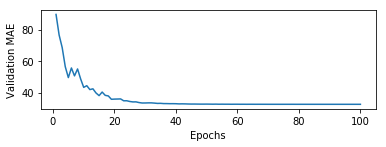

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()
ax1 = figure.add_subplot(211)
ax1.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

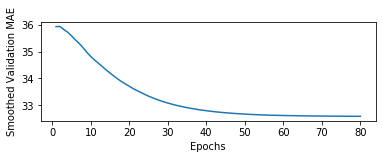

In [63]:
# Plottin validation scores, excluding the first 10 data points

def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor+point *(1-factor))
        else :
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[20:])

figure = plt.figure()
ax1 = figure.add_subplot(211)
ax1.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Smoothed Validation MAE')
plt.show()

## Use Case 3 - Reconstruction Error Check

    - Autoencoders are designed to 
        -- Take an input X
        -- Apply f(X) to generate h (also called Code and is generally a lower dimension represntation of X)
        -- Apply g(h) to output X'
    - Clearly we don't want X' to be same as X. Honestly we are not interested in X', we are actually interested in h via which we can generate X'.
    - So, this error of recontruction X' from h is what's called as Reconstruction Error
    - We would now evaluate how big is this reconstruction error - if this error is big then clearly h isn't a good representation

,Reconstruction_error,True_class
count,143.000000,143.000000
mean,39.499806,0.636364
std,12.959646,0.482737
min,28.068660,0.000000
25%,32.654836,0.000000
50%,35.358909,1.000000
75%,40.883886,1.000000
max,131.001290,1.000000


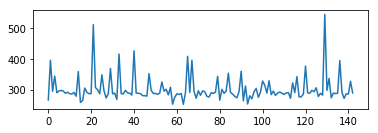

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

test_x_predictions = encoder_decoder_model.predict(testX)

euclidean_sq = np.square(testX - test_x_predictions)
mse = np.sqrt(np.sum(euclidean_sq, axis=1)).ravel()

#euclidean = testX - test_x_predictions
#mae = np.mean(euclidean_sq, axis=1).ravel()

figure = plt.figure()

ax1 = figure.add_subplot(211)
plt.plot(mae)

#mse = np.mean(np.power(testX - test_x_predictions, 2), axis=1)
#mae = np.mean(np.square(testX - test_x_predictions), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': testY})
error_df.describe()

# Precision Vs Recall

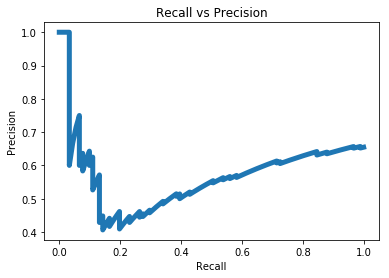

In [65]:
from sklearn.metrics import precision_recall_curve

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Reconstruction Error vs Threshold Check

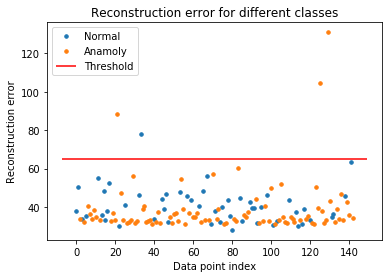

In [67]:
threshold_fixed = 65
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anamoly" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();